 ## UK Road Safety: Traffic Accidents and Vehicles
 
 The goal of this project is the investigate what causes Serious and Fatal accidents in hopes of preventing and decreasing the number of them. The dataset consists of accident records from the UK over the coarse of 15+ years. I hope to show the causes of these accidents through visualizations and create an algorithm that can predict the severity of accidents. 
 
The UK government collects and publishes (usually on an annual basis) detailed information about traffic accidents across the country. This information includes, but is not limited to, geographical locations, weather conditions, type of vehicles, number of casualties and vehicle manoeuvres, making this a very interesting and comprehensive dataset for analysis and research.

The data that I'm using is compiled and available through [Kaggle](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles) and in a less compliled form, [here](https://beta.ukdataservice.ac.uk/datacatalogue/series/series?id=2000045). 

Problem: Severe and fatal accidents.
Solution: Use data to figure out how to lower the number of accidents and the severity of them.

Questions:
1. What effects the severity of accidents?
2. Wbat measures should be looked into in order to lessen the severity of accidents?
3. Can we create an algorithm that correctly predicts the severity of accidents?
4. What are the limitations of the current data?
5. What things would help this research to be more accurate?
6. Who does this project benefit?


#### Column Descriptions




### Importing and Data Merging

In [2]:
#Import modules
import numpy as np
import holidays
import pandas as pd
import pickle

import datetime
import sklearn
import scipy
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
import math
from sklearn.model_selection import cross_val_score
import plotly
import plotly.graph_objects as go
import plotly.express as px

#importing some more modules
from sklearn import ensemble
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

#Import geospatial modules
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, shape
import fiona
from gmplot import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import folium 
import plotly

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.style.use('dark_background')
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import files

ac = pd.read_csv(r'Accident_Information.csv', low_memory=False, chunksize=30000)
vc = pd.read_csv(r'Vehicle_Information.csv', low_memory=False, chunksize=30000)

Previously, I did not remove "Data missing or out of range" from the datasets however through cleaning and checking the value counts I decided to do so for sanity purposes only. Most of the percentages that had this as a value were not a high percentage either. 

I also decided to only use data from 2010 and later. My reasoning for that was to further reduce size.

In [3]:
#chunk cleaning and dataframing for accident column
acchunk = []
for chunk in ac:
    acchunk_filter = chunk[
        (chunk.Year.astype(int) >= 2010) &
        (chunk['Road_Type'] != "Unknown") &
        (chunk['Junction_Control'] != "Data missing or out of range") &
        (chunk['Carriageway_Hazards'] != "Data missing or out of range") &
        (chunk['Junction_Detail'] != "Data missing or out of range") &
        (chunk['Road_Surface_Conditions'] != "Data missing or out of range") &
        (chunk['Special_Conditions_at_Site'] != "Data missing or out of range") &
        (chunk['Weather_Conditions'] != "Data missing or out of range") &
        (chunk['Latitude'].notnull()) &
        (chunk['Longitude'].notnull())
    ]
    acchunk.append(acchunk_filter)
df1 = pd.concat(acchunk)


In [4]:
#chunk cleaning for vehicles
vcchunk = []
for chunk2 in vc:
    vcchunk_filter = chunk2[
        (chunk2.Year.astype(int) >= 2010) &
        (chunk2['Driver_Home_Area_Type'] != "Data missing or out of range") &
        (chunk2['Journey_Purpose_of_Driver'] != "Data missing or out of range") &
        (chunk2['Junction_Location'] != "Data missing or out of range") &
        (chunk2['Was_Vehicle_Left_Hand_Drive'] != "Data missing or out of range") &
        (chunk2['Hit_Object_in_Carriageway'] != "Data missing or out of range") &
        (chunk2['Skidding_and_Overturning'] != "Data missing or out of range") &
        (chunk2['Towing_and_Articulation'] != "Data missing or out of range") &
        (chunk2['Vehicle_Leaving_Carriageway'] != "Data missing or out of range") &
        (chunk2['Vehicle_Manoeuvre'] != "Data missing or out of range") &
        (chunk2['Vehicle_Type'] != "Data missing or out of range") &
        (chunk2['X1st_Point_of_Impact'] != "Data missing or out of range") &
        (chunk2['Sex_of_Driver'] != "Data missing or out of range") &
        (chunk2['Age_Band_of_Driver'] != "Data missing or out of range")
        
    ]
    vcchunk.append(vcchunk_filter)
df2 = pd.concat(vcchunk)

In [5]:
#check columns
print("Accident's Columns:\n",df1.columns, "\n")

print("Vehicle's Columns:\n",df2.columns)

Accident's Columns:
 Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Year', 'InScotland'],
      dtype='object') 

Vehicle's Columns:
 Index(['Accident_Index', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Driver_Home_Area_Type', 'Driver_IMD_Decile', '

In [6]:
print('Accident Shape', df1.shape)
print('Vehicle Shape',df2.shape)

Accident Shape (691195, 34)
Vehicle Shape (1167198, 24)


In [7]:
#merge dataframes
df = pd.merge(df1,df2)

In [8]:
#check columns
print("Combined Columns:\n",df.columns, "\n")
print("\nShape:\n",df.shape)

Combined Columns:
 Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude',
       'LSOA_of_Accident_Location', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Police_Force',
       'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site',
       'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions',
       'Year', 'InScotland', 'Age_Band_of_Driver', 'Age_of_Vehicle',
       'Driver_Home_Area_Type', 'Driver_IMD_Decile', 'Engine_Capacity_.CC.',
       'Hit_Object_in_Carriageway', 'Hit_Object_o

In [9]:
df.describe(include ='all')

Accident_Index 1st_Road_Class  1st_Road_Number 2nd_Road_Class  \
count          720280         720280    720280.000000         699431   
unique         488010              6              NaN              6   
top     2016140142191              A              NaN   Unclassified   
freq               15         365390              NaN         473098   
mean              NaN            NaN      1051.470728            NaN   
std               NaN            NaN      1825.784600            NaN   
min               NaN            NaN         0.000000            NaN   
25%               NaN            NaN         0.000000            NaN   
50%               NaN            NaN       191.000000            NaN   
75%               NaN            NaN       900.000000            NaN   
max               NaN            NaN      9999.000000            NaN   

        2nd_Road_Number Accident_Severity Carriageway_Hazards        Date  \
count     710979.000000            720280              720280      720280   
unique              NaN                 3                   6        2557   
top                 NaN            Slight                None  2015-05-13   
freq                NaN            626656              714068         515   
mean         607.761499               NaN                 NaN         NaN   
std         1593.978070               NaN                 NaN         NaN   
min            0.000000               NaN                 NaN         NaN   
25%            0.000000               NaN                 NaN         NaN   
50%            0.000000               NaN                 NaN         NaN   
75%          173.000000               NaN                 NaN         NaN   
max         9999.000000               NaN                 NaN         NaN   

       Day_of_Week  Did_Police_Officer_Attend_Scene_of_Accident  ...  \
count       720280                                720279.000000  ...   
unique           7                                          NaN  ...   
top         Friday                                          NaN  ...   
freq        119324                                          NaN  ...   
mean           NaN                                     1.147353  ...   
std            NaN                                     0.357791  ...   
min            NaN                                     1.000000  ...   
25%            NaN                                     1.000000  ...   
50%            NaN                                     1.000000  ...   
75%            NaN                                     1.000000  ...   
max            NaN                                     3.000000  ...   

       Sex_of_Driver Skidding_and_Overturning  Towing_and_Articulation  \
count         720280                   720280                   720280   
unique             3                        6                        6   
top             Male                     None      No tow/articulation   
freq          484205                   659742                   713570   
mean             NaN                      NaN                      NaN   
std              NaN                      NaN                      NaN   
min              NaN                      NaN                      NaN   
25%              NaN                      NaN                      NaN   
50%              NaN                      NaN                      NaN   
75%              NaN                      NaN                      NaN   
max              NaN                      NaN                      NaN   

       Vehicle_Leaving_Carriageway Vehicle_Location.Restricted_Lane  \
count                       720280                    720269.000000   
unique                           9                              NaN   
top      Did not leave carriageway                              NaN   
freq                        663463                              NaN   
mean                           NaN                         0.086026   
std                            NaN   

### Data Cleaning

In [10]:
#check corr b/t Location_Easting_OSGR & Location_Northing_OSGR AND Longitude and Latitude

print(df['Location_Easting_OSGR'].corr(df['Longitude']))


print(df['Location_Northing_OSGR'].corr(df['Latitude']))

0.999425701544617
0.9999733124707393


In [11]:
#drop Location_Easting_OSGR & Location_Northing_OSGR
#because they are the similar to Latitude and Longitude 

df = df.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR'], axis=1)

In [12]:
df.shape

(720280, 54)

In [13]:
#standardize all column names to lowercase, and remove some characters 
#for ease of use in querying
df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace('.','')
df.columns = df.columns.str.replace('(','')
df.columns = df.columns.str.replace(')','')

In [14]:
#convert date/time to datetime datatype

df['date'] = pd.to_datetime((df['date']), format= "%Y-%m-%d")



In [15]:
#mistyped datatypes


df[['did_police_officer_attend_scene_of_accident',
    'driver_imd_decile','vehicle_reference',
    'vehicle_locationrestricted_lane','1st_road_number',
    '2nd_road_number','driver_imd_decile',
    'pedestrian_crossing-physical_facilities',
   'pedestrian_crossing-human_control']]= df[['did_police_officer_attend_scene_of_accident',
    'driver_imd_decile','vehicle_reference',
    'vehicle_locationrestricted_lane','1st_road_number',
    '2nd_road_number','driver_imd_decile',
    'pedestrian_crossing-physical_facilities',
   'pedestrian_crossing-human_control']].astype('object')



In [16]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('<M8[ns]'): Index(['date'], dtype='object'),
 dtype('int64'): Index(['number_of_casualties', 'number_of_vehicles', 'year'], dtype='object'),
 dtype('float64'): Index(['latitude', 'longitude', 'speed_limit', 'age_of_vehicle',
        'engine_capacity_cc'],
       dtype='object'),
 dtype('O'): Index(['accident_index', '1st_road_class', '1st_road_number', '2nd_road_class',
        '2nd_road_number', 'accident_severity', 'carriageway_hazards',
        'day_of_week', 'did_police_officer_attend_scene_of_accident',
        'junction_control', 'junction_detail', 'light_conditions',
        'local_authority_district', 'local_authority_highway',
        'lsoa_of_accident_location', 'pedestrian_crossing-human_control',
        'pedestrian_crossing-physical_facilities', 'police_force',
        'road_surface_conditions', 'road_type', 'special_conditions_at_site',
        'time', 'urban_or_rural_area', 'weather_conditions', 'inscotland',
        'age_band_of_driver', 'driver_home_area_type', 

#### Nulls

In [17]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

driver_imd_decile                              25.118565
age_of_vehicle                                 15.287805
model                                          11.636447
engine_capacity_cc                             11.283251
propulsion_code                                10.899928
make                                            5.846476
lsoa_of_accident_location                       5.674738
2nd_road_class                                  2.894569
2nd_road_number                                 1.291303
pedestrian_crossing-physical_facilities         0.006109
pedestrian_crossing-human_control               0.005276
time                                            0.004582
speed_limit                                     0.001805
vehicle_locationrestricted_lane                 0.001527
did_police_officer_attend_scene_of_accident     0.000139
day_of_week                                     0.000000
1st_road_class                                  0.000000
number_of_vehicles             

##### 2nd_road_class

In [18]:
# #2nd_road_class
df['2nd_road_class'].value_counts()/df.shape[0]*100

Unclassified    65.682512
A               15.892292
C                7.591909
B                6.494558
Motorway         1.301716
A(M)             0.142445
Name: 2nd_road_class, dtype: float64

With 40% of non null being unclassified and 39% of the overall 2nd_road_class column being null, I have decided to drop it in it's entirely. 

In [19]:
df = df.drop(['2nd_road_class'], axis=1)

##### driver_imd_decile

In [20]:
#driver_imd_decile
df['driver_imd_decile'].value_counts()/df.shape[0]*100

2.0     8.366469
3.0     8.281640
4.0     7.986339
1.0     7.888321
5.0     7.717554
6.0     7.530683
7.0     7.195674
8.0     6.948270
9.0     6.803049
10.0    6.163436
Name: driver_imd_decile, dtype: float64

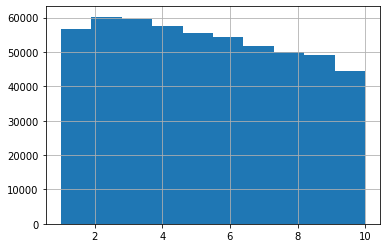

In [21]:
df['driver_imd_decile'].hist()
plt.style.use('dark_background')

Since the distribution of categories for 'driver_imd_decile seem very similar, I've decided not to use the mode but "method='ffill'"

In [22]:
df['driver_imd_decile'].fillna(method='ffill', inplace=True)

##### age_of_vehicle

In [23]:
df['age_of_vehicle'].describe()

count    610165.000000
mean          7.567473
std           4.751567
min           1.000000
25%           4.000000
50%           7.000000
75%          11.000000
max         105.000000
Name: age_of_vehicle, dtype: float64

In [24]:
df['age_of_vehicle'].median()

7.0

Changing the nulls of "age of vehicle" to median, then creating it as a category

In [25]:
#fillna by 7 
df['age_of_vehicle'].fillna(7, inplace=True)

#group age_of_vehicle
#1=0-3, 2=3-5, 3=5-8, 4=8-11, 5=
def fixedvehicleage(age):
    if age>=0 and age<=120:
        return age
    else:
        return np.nan

df['age_of_vehicle'] = df['age_of_vehicle'].apply(fixedvehicleage)


df['age_of_vehicle'] = pd.cut(df['age_of_vehicle'], 
                             [0,2,5,8,11,14,17,120], labels=['1', '2', '3','4','5','6','7'])


##### Model

In [26]:
#model
df['model'].value_counts()/df.shape[0]*100

MISSING                             0.743183
KA                                  0.336675
CLIO DYNAMIQUE 16V                  0.279058
FIESTA ZETEC                        0.247681
SPRINTER 313 CDI                    0.236158
206 LX                              0.220331
PUNTO ACTIVE                        0.212279
CLIO EXPRESSION 16V                 0.199783
YBR 125                             0.194785
FIESTA FINESSE                      0.177570
MINI COOPER                         0.175904
KA COLLECTION                       0.174793
CORSA CLUB 12V                      0.160910
MICRA S                             0.160493
FIESTA ZETEC CLIMATE                0.158827
CORSA CLUB 16V                      0.158272
PUNTO ACTIVE 8V                     0.141889
MINI ONE                            0.141334
KA STYLE                            0.140640
FIESTA STYLE                        0.140223
FIESTA LX                           0.140084
FOCUS ZETEC TDCI                    0.139113
107 URBAN 

In [27]:
df['model'].describe()

count      636465
unique      28664
top       MISSING
freq         5353
Name: model, dtype: object

Knowing that there are 28824 unique models for the model column I have decided to use the ffill method on it as well. 

In [28]:
df['model'].fillna(method='ffill', inplace=True)

Note: A lot of the values of "model' are labeled as "missing". I do not want to change these because the model could have actually been missing from the car from the accident or it could not be recognizable at the time of the accident.

#### engine_capacity_cc

In [29]:
#engine_capacity_cc
df['engine_capacity_cc'].describe()

count    639009.000000
mean       1848.094816
std        1573.057956
min           2.000000
25%        1248.000000
50%        1598.000000
75%        1995.000000
max       91000.000000
Name: engine_capacity_cc, dtype: float64

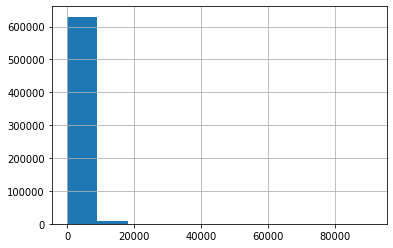

In [30]:
df['engine_capacity_cc'].hist()
plt.style.use('dark_background')

I am going to handle both outliers and the null values of engine_capacity_cc using the ideals of quantiles and the interquartile range (IQR).

In [32]:
#first I'm going to handle both ends of outliers.
#(determine the min and max cuttoffs for detecting the outlier)
q75, q25 = np.percentile(df['engine_capacity_cc'].dropna(), [75 ,25])
iqr = q75 - q25
 
ecmin = q25 - (iqr*1.5)
ecmax = q75 + (iqr*1.5)

print(ecmax)
print(ecmin)

3115.5
127.5


To explain, what I am going to do is use the ecmax number for the maximum engine_capacity_cc and ecmin for my engine_capacity_cc. Then I'm going to take the mean of those and use it as my fillna.

In [33]:
df = df[df['engine_capacity_cc']<=ecmax]

In [34]:
df = df[df['engine_capacity_cc']>=ecmin]

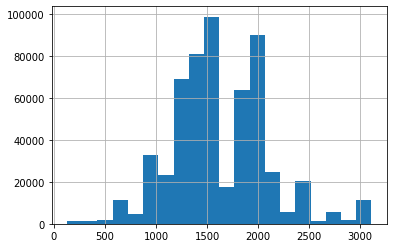

In [35]:
df['engine_capacity_cc'].hist(bins=20)
plt.style.use('dark_background')

I can accept this distribution and will now check and handle their nulls

In [37]:
#check values of 'engine_capacity_cc'
df['engine_capacity_cc'].describe()

count    569057.000000
mean       1633.351432
std         473.765085
min         128.000000
25%        1299.000000
50%        1598.000000
75%        1968.000000
max        3110.000000
Name: engine_capacity_cc, dtype: float64

In [38]:
df['engine_capacity_cc'].mean()

1633.3514322818276

Going to round this mean value

In [39]:
df['engine_capacity_cc'].fillna(1652, inplace=True)

Note: After doing the above null fixes, propulsion_code dropped from having 10% null values to 0. (see below). I will continue on and fix lsoa_of_accident_location then drop the rest of the null values with are all <5%.

In [40]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

lsoa_of_accident_location                      5.902045
2nd_road_number                                1.317618
make                                           0.063087
pedestrian_crossing-human_control              0.005448
pedestrian_crossing-physical_facilities        0.005096
time                                           0.003866
vehicle_locationrestricted_lane                0.001406
speed_limit                                    0.001230
did_police_officer_attend_scene_of_accident    0.000176
date                                           0.000000
accident_severity                              0.000000
road_type                                      0.000000
road_surface_conditions                        0.000000
police_force                                   0.000000
1st_road_class                                 0.000000
1st_road_number                                0.000000
number_of_vehicles                             0.000000
number_of_casualties                           0

#### lsoa_of_accident_location

In [41]:
# #lsoa_of_accident_location
df['lsoa_of_accident_location'].value_counts()

E01032739    440
E01004736    412
E01000004    410
E01018648    303
E01004689    261
E01002444    231
E01030458    229
E01011365    213
E01016012    203
E01012851    192
E01024335    188
E01010521    185
E01011107    184
E01007913    178
E01023732    176
E01008440    176
E01013607    176
E01009200    175
E01022677    173
E01016952    173
E01031587    171
E01031583    171
E01032740    170
E01023584    168
E01008397    167
E01007611    166
E01003482    165
E01018337    164
E01005131    163
E01024721    162
            ... 
E01027607      1
E01009585      1
E01004047      1
E01030562      1
E01033626      1
W01000035      1
E01018165      1
E01004998      1
E01008371      1
E01000398      1
E01014021      1
E01017856      1
E01029082      1
E01024399      1
E01028025      1
E01009157      1
E01033117      1
E01024144      1
E01023234      1
E01033028      1
W01001149      1
E01007265      1
E01017764      1
E01030065      1
E01002235      1
E01000048      1
E01029028      1
E01031930     

In [42]:
df['lsoa_of_accident_location'].describe()

count        535471
unique        33936
top       E01032739
freq            440
Name: lsoa_of_accident_location, dtype: object

With 35061 unique variable and a high count amount the top variables I am deciding to do ffill again. 

In [43]:
df['lsoa_of_accident_location'].fillna(method='ffill', inplace=True)

In [44]:
#### Check nulls for again
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

2nd_road_number                                1.317618
make                                           0.063087
pedestrian_crossing-human_control              0.005448
pedestrian_crossing-physical_facilities        0.005096
time                                           0.003866
vehicle_locationrestricted_lane                0.001406
speed_limit                                    0.001230
did_police_officer_attend_scene_of_accident    0.000176
carriageway_hazards                            0.000000
longitude                                      0.000000
road_type                                      0.000000
road_surface_conditions                        0.000000
police_force                                   0.000000
1st_road_class                                 0.000000
1st_road_number                                0.000000
number_of_vehicles                             0.000000
number_of_casualties                           0.000000
lsoa_of_accident_location                      0

Dropping the remaining nulls that are <1%.

In [45]:
#drop the remaining nulls that are <1%
df.dropna(inplace=True)

#last check
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

x1st_point_of_impact                           0.0
speed_limit                                    0.0
road_type                                      0.0
road_surface_conditions                        0.0
police_force                                   0.0
pedestrian_crossing-physical_facilities        0.0
pedestrian_crossing-human_control              0.0
number_of_vehicles                             0.0
number_of_casualties                           0.0
lsoa_of_accident_location                      0.0
longitude                                      0.0
local_authority_highway                        0.0
local_authority_district                       0.0
light_conditions                               0.0
latitude                                       0.0
junction_detail                                0.0
junction_control                               0.0
did_police_officer_attend_scene_of_accident    0.0
day_of_week                                    0.0
date                           

In [46]:
df.shape

(561135, 53)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561135 entries, 0 to 720279
Data columns (total 53 columns):
accident_index                                 561135 non-null object
1st_road_class                                 561135 non-null object
1st_road_number                                561135 non-null object
2nd_road_number                                561135 non-null object
accident_severity                              561135 non-null object
carriageway_hazards                            561135 non-null object
date                                           561135 non-null datetime64[ns]
day_of_week                                    561135 non-null object
did_police_officer_attend_scene_of_accident    561135 non-null object
junction_control                               561135 non-null object
junction_detail                                561135 non-null object
latitude                                       561135 non-null float64
light_conditions                        

#### More outliers, categorizing, and other cleanup

In [205]:
#detecting outliers of numerical columns (all floats/ints excluding lat/long and year)

df_num = df[['engine_capacity_cc','number_of_casualties','number_of_vehicles','speed_limit']]


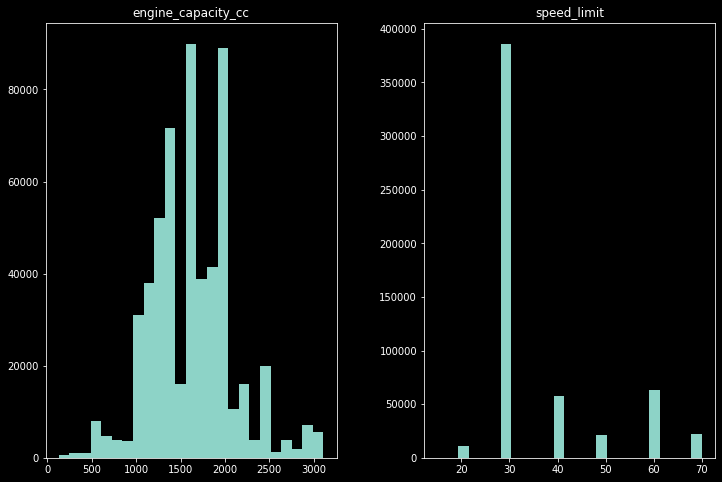

In [206]:
df_num.hist( bins=25, grid=False, figsize=(12,8))
plt.style.use('dark_background')

Column 'speed_limit' seems ok and was previously altered 'engine_capacity_cc'. However, 'number_of_casualties', and 'number_of_vehicles',will be evaluated. 

In [50]:
# #number_of_casualties
df['number_of_casualties'].value_counts()

1     391938
2     113736
3      35451
4      12511
5       4621
6       1739
7        599
8        243
9        146
10        52
11        29
12        28
13        15
16        10
14         4
15         3
17         3
24         2
21         2
19         1
22         1
43         1
Name: number_of_casualties, dtype: int64

In [51]:
#create casualities grouping

def casualities(num_cas):
    if num_cas >=1 and num_cas <2:
        return "1"
    elif num_cas >=2 and num_cas <3:
        return "2"
    elif num_cas >=3 and num_cas <4:
        return "3"
    elif num_cas >= 4 and num_cas <5:
        return "4"
    elif num_cas >= 5:
        return "5+"
  
    

In [52]:
#apply function   
df['number_of_casualties']= df['number_of_casualties'].apply(casualities)

In [53]:
#number_of_casualties
df['number_of_casualties'].value_counts()

1     391938
2     113736
3      35451
4      12511
5+      7499
Name: number_of_casualties, dtype: int64

In [54]:
df['propulsion_code'].value_counts()/df.shape[0]*100

Petrol                 60.540155
Heavy oil              38.544913
Hybrid electric         0.782699
Gas/Bi-fuel             0.094808
Petrol/Gas (LPG)        0.021207
Electric diesel         0.013188
Gas                     0.002317
New fuel technology     0.000356
Gas Diesel              0.000178
Fuel cells              0.000178
Name: propulsion_code, dtype: float64

In [55]:
#Clean the values for Propulsion Code. 
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Gas", value="Petrol")
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Gas/Bi-fuel", value="Bio-fuel")
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Petrol/Gas (LPG)", value="LPG Petrol")
df['propulsion_code'] = df['propulsion_code'].replace(to_replace="Gas Diesel", value="Diesel")

In [56]:
df['propulsion_code'].value_counts()/df.shape[0]*100

Petrol                 60.542472
Heavy oil              38.544913
Hybrid electric         0.782699
Bio-fuel                0.094808
LPG Petrol              0.021207
Electric diesel         0.013188
New fuel technology     0.000356
Diesel                  0.000178
Fuel cells              0.000178
Name: propulsion_code, dtype: float64

### Feature Manipulation, Creation and Engineering.


In [57]:
# #unique values
df.nunique().sort_values(ascending=False)

accident_index                                 412838
longitude                                      356283
latitude                                       346962
lsoa_of_accident_location                       33895
model                                           25688
2nd_road_number                                  5781
1st_road_number                                  5088
date                                             2557
time                                             1439
engine_capacity_cc                               1023
local_authority_district                          380
make                                              226
local_authority_highway                           207
police_force                                       51
vehicle_manoeuvre                                  18
vehicle_type                                       16
number_of_vehicles                                 15
vehicle_reference                                  15
hit_object_in_carriageway   

In [58]:
df['date'] = pd.to_datetime(df['date'])

In [59]:
df['month'] = df ['date'].apply(lambda time: time.month)

In [60]:
#creating a weekend feature that includes Friday-Sunday
df['weekend']= np.where(df['day_of_week'].isin(['Friday', 'Saturday', 'Sunday']), 1, 0)

In [61]:
#create time of day feature with Morning Rush, Day, Noon Rush, Afternoon, After Work Rush, Night

#time of day dictionary
timeofdaygroups = {1: "Morning Rush (6-10)",
                   2: "Day (10-12)",
                   3: "Lunch Rush (12-14)",
                   4: "Afternoon (14-16)",
                   5: "After Work Rush (16-18)",
                   6: "Evening (18-22)",
                   7: "Night (22-6)"}

In [62]:
#pull time data and create hour column
df['hour'] = df['time'].str[0:2]
 
#convert to numeric    
df['hour'] =  pd.to_numeric(df['hour'])

#convert to integer
df['hour'] = df['hour'].astype('int')

In [63]:
#create time_of_day grouping

def daygroup(hour):
    if hour >= 6 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 12:
        return "2"
    elif hour >= 12 and hour < 14:
        return "3"
    elif hour >= 14 and hour < 16:
        return "4"
    elif hour >= 16 and hour < 18:
        return "5"
    elif hour >= 18 and hour < 22:
        return "6"
    else:
        return "7"
    

In [64]:
#apply function   
#time of day function
df['time_of_day']= df['hour'].apply(daygroup)   

In [65]:
df[['weekend','day_of_week','time', 'time_of_day']].tail(10)

weekend day_of_week   time time_of_day
720270        0   Wednesday  08:45           1
720271        0   Wednesday  08:45           1
720272        0     Tuesday  18:12           6
720273        1      Sunday  11:00           2
720274        1      Sunday  11:00           2
720275        0      Monday  16:32           5
720276        0      Monday  16:32           5
720277        1      Friday  06:45           1
720278        0     Tuesday  16:45           5
720279        0     Tuesday  16:45           5

In [66]:
#vehicle_type
df['vehicle_type'].value_counts()/df.shape[0]*100

Car                                      86.052020
Van / Goods 3.5 tonnes mgw or under       5.481212
Motorcycle over 500cc                     3.999929
Taxi/Private hire car                     2.932628
Motorcycle over 125cc and up to 500cc     0.881428
Motorcycle 125cc and under                0.178567
Minibus (8 - 16 passenger seats)          0.140251
Other vehicle                             0.131519
Goods over 3.5t. and under 7.5t           0.083937
Motorcycle 50cc and under                 0.043840
Bus or coach (17 or more pass seats)      0.024771
Goods vehicle - unknown weight            0.015326
Goods 7.5 tonnes mgw and over             0.013188
Motorcycle - unknown cc                   0.013009
Agricultural vehicle                      0.007128
Electric motorcycle                       0.001247
Name: vehicle_type, dtype: float64

I want to condense the vehicle type variables. 

In [67]:
#motorcycles
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle over 500cc", 
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace=
                                                        "Motorcycle over 125cc and up to 500cc",
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle 125cc and under", 
                                                value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle 50cc and under", 
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Electric motorcycle", 
                                                        value="Motorcycle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Motorcycle - unknown cc", 
                                                        value="Motorcycle")


#Goods_vehicle
df['vehicle_type'] = df['vehicle_type'].replace(to_replace=
                                                        "Van / Goods 3.5 tonnes mgw or under", 
                                                        value="Van_Goods_vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Goods over 3.5t. and under 7.5t", 
                                                        value="Van_Goods_vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Goods vehicle - unknown weight", 
                                                        value="Van_Goods_vehicle")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Goods 7.5 tonnes mgw and over", 
                                                        value="Van_Goods_vehicle")

#car
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Taxi/Private hire car", 
                                                        value="Car")


#bus
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Minibus (8 - 16 passenger seats)", 
                                                        value="Bus")
df['vehicle_type'] = df['vehicle_type'].replace(to_replace=
                                                        "Bus or coach (17 or more pass seats", 
                                                        value="Bus")

#other vehicle
df['vehicle_type'] = df['vehicle_type'].replace(to_replace="Agricultural vehicle", 
                                                        value="Other vehicle")


In [68]:
#vehicle_type
df['vehicle_type'].value_counts()/df.shape[0]*100

Car                                     88.984647
Van_Goods_vehicle                        5.593663
Motorcycle                               5.118020
Bus                                      0.140251
Other vehicle                            0.138648
Bus or coach (17 or more pass seats)     0.024771
Name: vehicle_type, dtype: float64

Create more condense groups for age band of driver in order to deal with some potential outliers.

In [69]:
#age_band_of_driver 
df['age_band_of_driver'].value_counts()/df.shape[0]*100

26 - 35    22.598662
36 - 45    20.728345
46 - 55    17.551213
21 - 25    12.208827
56 - 65    10.373796
16 - 20     7.145696
66 - 75     5.624850
Over 75     3.757028
11 - 15     0.011049
6 - 10      0.000356
0 - 5       0.000178
Name: age_band_of_driver, dtype: float64

In [70]:
#I did this before hand because as "Over 75", it wouldnt convert in the codes below
df['age_band_of_driver']=df['age_band_of_driver'].replace("Over 75","75-100")

In [74]:
age1 = ["0 - 5", "6 - 10", "11 - 15"]
age2 = ["16 - 20","21 - 25"]
age3 = ["26 - 35","36 - 45"]
age4 = ["46 - 55", "56 - 65"]
age5 = ["66 - 75", "75-100"]

In [75]:
#over 75 wouldnt work in the string so I did it separately
for (row, col) in df.iterrows():

    if str.lower(col.age_band_of_driver) in age1:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='Under 16', inplace=True)

    if str.lower(col.age_band_of_driver) in age2:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='16-25', inplace=True)
    
    if str.lower(col.age_band_of_driver) in age3:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='26-45', inplace=True)
    if str.lower(col.age_band_of_driver) in age4:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='46-65', inplace=True)
    if str.lower(col.age_band_of_driver) in age5:
        df['age_band_of_driver'].replace(to_replace=col.age_band_of_driver, 
                                         value='Over 65', inplace=True)

In [76]:
#age_band_of_driver
print("Distinct responses for age_band_of_driver:\n", set(df['age_band_of_driver']))

Distinct responses for age_band_of_driver:
 {'46-65', '16-25', 'Over 65', 'Under 16', '26-45'}


In [71]:
# number_of_vehicles
df['number_of_vehicles'].value_counts()/df.shape[0]*100

2     72.944835
3     11.924403
1     11.570121
4      2.706122
5      0.582747
6      0.167874
7      0.059166
8      0.021385
11     0.005881
9      0.005881
10     0.004277
14     0.002317
13     0.002139
16     0.001782
12     0.001069
Name: number_of_vehicles, dtype: float64

In [72]:
#group number_of_vehicles

def vehicles(num_veh):
    if num_veh >=1 and num_veh <2:
        return "1"
    elif num_veh >=2 and num_veh <3:
        return "2"
    elif num_veh >=3 and num_veh <4:
        return "3"
    elif num_veh >= 4: 
        return "4+"
  
#apply function   
df['number_of_vehicles']= df['number_of_vehicles'].apply(vehicles)

In [73]:
# number_of_vehicles
df['number_of_vehicles'].value_counts()/df.shape[0]*100

2     72.944835
3     11.924403
1     11.570121
4+     3.560640
Name: number_of_vehicles, dtype: float64

In [77]:
df['number_of_vehicles'].dtypes

dtype('O')

In [78]:
df['number_of_vehicles']=df['number_of_vehicles'].astype('object')

In [195]:
#dropping driver_home_area_type because of its redunancy with urban_or_rural area
df = df.drop(['driver_home_area_type'], axis=1)

In [196]:
#unique values
df.nunique().sort_values(ascending=False)

accident_index                                 412838
longitude                                      356283
latitude                                       346962
lsoa_of_accident_location                       33895
model                                           25688
2nd_road_number                                  5781
1st_road_number                                  5088
date                                             2557
time                                             1439
engine_capacity_cc                               1023
local_authority_district                          380
make                                              226
local_authority_highway                           207
police_force                                       51
hour                                               24
vehicle_manoeuvre                                  18
vehicle_reference                                  15
hit_object_off_carriageway                         12
month                       

In [80]:
#pickling everything to speed up restarting
df.to_pickle("df.pkl")

In [239]:
#import pickled file
df = pd.read_pickle("df.pkl")
df.head()

accident_index 1st_road_class 1st_road_number 2nd_road_number  \
0  201001BS70003              B             302               0   
1  201001BS70004              A             402            4204   
3  201001BS70007   Unclassified               0               0   
4  201001BS70007   Unclassified               0               0   
5  201001BS70008              A            3217            3220   

  accident_severity carriageway_hazards       date day_of_week  \
0            Slight                None 2010-01-11      Monday   
1            Slight                None 2010-01-11      Monday   
3            Slight                None 2010-01-02    Saturday   
4            Slight                None 2010-01-02    Saturday   
5            Slight                None 2010-01-04      Monday   

  did_police_officer_attend_scene_of_accident          junction_control  ...  \
0                                           1  Give way or uncontrolled  ...   
1                                           1       Auto traffic signal  ...   
3                                           1  Give way or uncontrolled  ...   
4                                           1  Give way or uncontrolled  ...   
5                                           1       Auto traffic signal  ...   

  vehicle_locationrestricted_lane            vehicle_manoeuvre  \
0                               0                Turning right   
1                               0            Going ahead other   
3                               0  Going ahead right-hand bend   
4                               0            Going ahead other   
5                               0                Turning right   

  vehicle_reference       vehicle_type was_vehicle_left_hand_drive  \
0                 1  Van_Goods_vehicle                          No   
1                 1                Car                          No   
3                 1                Car                          No   
4                 2                Car                          No   
5                 1                Car                          No   

   x1st_point_of_impact month weekend hour time_of_day  
0                 Front     1       0    7           1  
1                 Front     1       0   18           6  
3              Nearside     1       1   21           6  
4                 Front     1       1   21           6  
5              Nearside     1       0   20           6  

[5 rows x 57 columns]

### General Visualizations

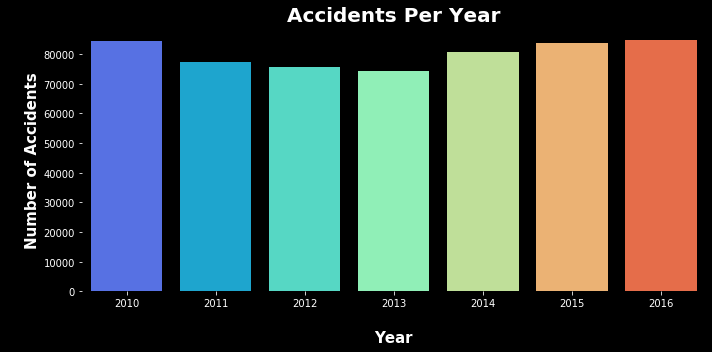

In [221]:
accidentsperyear = df.groupby(['year'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(10,5))
colors = sns.color_palette("rainbow", n_colors=7)
sns.barplot(accidentsperyear.index,accidentsperyear.values, palette=colors)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Year",fontsize=20,fontweight="bold")
plt.xlabel("\nYear", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tight_layout()


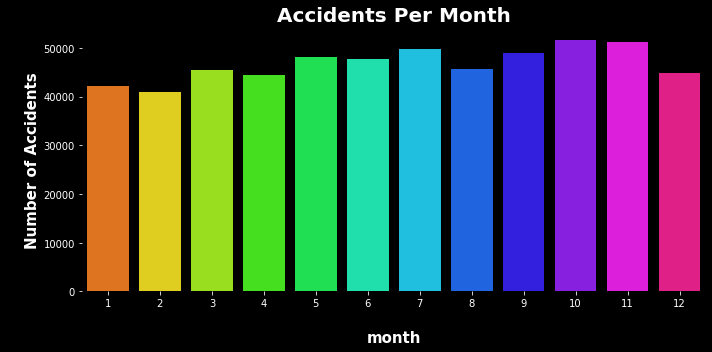

In [83]:
accidentspermonth = df.groupby(['month'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(10,5))
colors = sns.color_palette("hsv", n_colors=12)
sns.barplot(accidentspermonth.index,accidentspermonth.values, palette=colors)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Month",fontsize=20,fontweight="bold")
plt.xlabel("\nmonth", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tight_layout()


Text(87.0, 0.5, '')

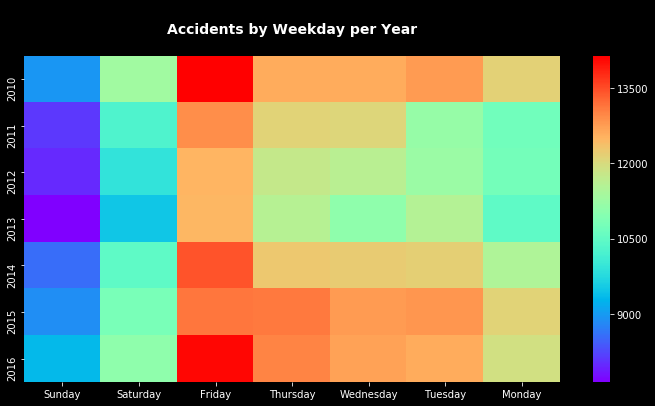

In [84]:
weekdays = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']
accweekday = df.groupby(['year', 'day_of_week']).size()
accweekday = accweekday.rename_axis(['year', 'day_of_week'])\
                               .unstack('day_of_week')\
                               .reindex(columns=weekdays)
plt.figure(figsize=(12,6))
plt.style.use('dark_background')
sns.heatmap(accweekday, cmap='rainbow')
plt.title('\nAccidents by Weekday per Year\n', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('')

Fridays are the day of the week where the most accidents occur.

In [86]:
print(df.columns)

Index(['accident_index', '1st_road_class', '1st_road_number',
       '2nd_road_number', 'accident_severity', 'carriageway_hazards', 'date',
       'day_of_week', 'did_police_officer_attend_scene_of_accident',
       'junction_control', 'junction_detail', 'latitude', 'light_conditions',
       'local_authority_district', 'local_authority_highway', 'longitude',
       'lsoa_of_accident_location', 'number_of_casualties',
       'number_of_vehicles', 'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'police_force',
       'road_surface_conditions', 'road_type', 'special_conditions_at_site',
       'speed_limit', 'time', 'urban_or_rural_area', 'weather_conditions',
       'year', 'inscotland', 'age_band_of_driver', 'age_of_vehicle',
       'driver_home_area_type', 'driver_imd_decile', 'engine_capacity_cc',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'journey_purpose_of_driver', 'junction_location', 'make', 'model',
       'pr

In [87]:
#change objects to category
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))


In [198]:
#correlation by accident severity
corrdf=df.apply(LabelEncoder().fit_transform)
corr=corrdf.corr()['accident_severity']
corr[np.argsort(corr,axis=0)[::-1]]

accident_severity                              1.000000
urban_or_rural_area                            0.071467
number_of_vehicles                             0.061327
vehicle_manoeuvre                              0.052022
engine_capacity_cc                             0.045978
vehicle_reference                              0.034229
weather_conditions                             0.029851
longitude                                      0.025443
road_surface_conditions                        0.015050
light_conditions                               0.013423
pedestrian_crossing-physical_facilities        0.012966
hit_object_in_carriageway                      0.011873
police_force                                   0.010346
2nd_road_number                                0.008992
1st_road_class                                 0.008150
local_authority_highway                        0.005513
was_vehicle_left_hand_drive                    0.003404
journey_purpose_of_driver                      0

In [240]:
#correlation where accidents are Slight
slight =  df[(df['accident_severity']=='Slight')]
print("Slight Severity Group Shape:", slight.shape)

Slight Severity Group Shape: (492804, 57)


In [241]:
#correlation where accidents are serious or fatal
nonslight =  df[(df['accident_severity']!='Slight')]
print("Non-Slight Severity Group Shape:", nonslight.shape)
#correlation by accident severity
corrnonslight=nonslight.apply(LabelEncoder().fit_transform)
corrnonslight=corrnonslight.corr()['accident_severity']
corrnonslight[np.argsort(corrnonslight,axis=0)[::-1]]

Non-Slight Severity Group Shape: (68331, 57)


accident_severity                              1.000000
urban_or_rural_area                            0.096124
vehicle_manoeuvre                              0.068341
1st_road_class                                 0.051743
driver_home_area_type                          0.039630
did_police_officer_attend_scene_of_accident    0.038997
year                                           0.024174
date                                           0.023600
longitude                                      0.022472
road_type                                      0.021559
accident_index                                 0.020907
light_conditions                               0.015629
pedestrian_crossing-physical_facilities        0.015577
weather_conditions                             0.013667
hit_object_in_carriageway                      0.013469
pedestrian_crossing-human_control              0.012700
junction_location                              0.012395
hour                                           0

Looking at this I wanted to visualize some of the higher pos/negative correlations against accident severity.

## Visualizations In Relation to Accident Severity 
## (Slight vs Non-Slight)

In [242]:
#create time of day feature with Morning Rush, Day, Noon Rush, Afternoon, After Work Rush, Night

#time of day dictionary
timeofdaygroups = {"1": "Morning Rush (6-10)",
                   "2": "Day (10-12)",
                   "3": "Lunch Rush (12-14)",
                   "4": "Afternoon (14-16)",
                   "5": "After Work Rush (16-18)",
                   "6": "Evening (18-22)",
                   "7": "Night (22-6)"}

df['time_of_day']=df['time_of_day'].map(timeofdaygroups)
slight['time_of_day']=slight['time_of_day'].map(timeofdaygroups)
nonslight['time_of_day']=nonslight['time_of_day'].map(timeofdaygroups)
fatal['time_of_day']=fatal['time_of_day'].map(timeofdaygroups)
serious['time_of_day']=serious['time_of_day'].map(timeofdaygroups)

#Weekend
isweekend = {1:"Yes", 0:"No"}
df['weekend'] = df['weekend'].map(isweekend)
slight['weekend'] = slight['weekend'].map(isweekend)
nonslight['weekend'] = nonslight['weekend'].map(isweekend)
fatal['weekend'] = fatal['weekend'].map(isweekend)
serious['weekend'] = serious['weekend'].map(isweekend)

#replace 1, 2, 3 in did_police_officer_attend_scene_of_accident with Yes, No,Self-reported
slight['did_police_officer_attend_scene_of_accident']=slight['did_police_officer_attend_scene_of_accident'].map(policeattend)
nonslight['did_police_officer_attend_scene_of_accident']=nonslight['did_police_officer_attend_scene_of_accident'].map(policeattend)
df['did_police_officer_attend_scene_of_accident']=df['did_police_officer_attend_scene_of_accident'].map(policeattend)
policeattend = {1: "Yes", 2:"No", 3:"Self-Reported"}
serious['did_police_officer_attend_scene_of_accident']=serious['did_police_officer_attend_scene_of_accident'].map(policeattend)
fatal['did_police_officer_attend_scene_of_accident']=fatal['did_police_officer_attend_scene_of_accident'].map(policeattend)

#### Did Police Officer Attend Scene Of Accident

In [250]:
#did_police_officer_attend_scene_of_accident
dpanonslight=nonslight.groupby(['did_police_officer_attend_scene_of_accident'])['accident_severity'].count().sort_values(ascending=False)
dpanonslighttot = nonslight['accident_severity'].count()


dpaslight=slight.groupby(['did_police_officer_attend_scene_of_accident'])['accident_severity'].count().sort_values(ascending=False)
dpaslighttot = slight['accident_severity'].count()


print("Non-Slight Severity Overall Totals by Police Attendance:\n", dpanonslight)
print('\n')
print("Non-Slight Percentages:\n", dpanonslight/dpanonslighttot)
print('\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('\n')
print("Slight Severity Overall Totals by Police Attendance:\n", dpaslight)
print('\n')
print("Slight Percentages:\n", dpaslight/dpaslighttot)

Non-Slight Severity Overall Totals by Police Attendance:
 did_police_officer_attend_scene_of_accident
Yes              64220
No                4094
Self-Reported       17
Name: accident_severity, dtype: int64


Non-Slight Percentages:
 did_police_officer_attend_scene_of_accident
Yes              0.939837
No               0.059914
Self-Reported    0.000249
Name: accident_severity, dtype: float64


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Slight Severity Overall Totals by Police Attendance:
 did_police_officer_attend_scene_of_accident
Yes              417510
No                74812
Self-Reported       482
Name: accident_severity, dtype: int64


Slight Percentages:
 did_police_officer_attend_scene_of_accident
Yes              0.847213
No               0.151809
Self-Reported    0.000978
Name: accident_severity, dtype: float64


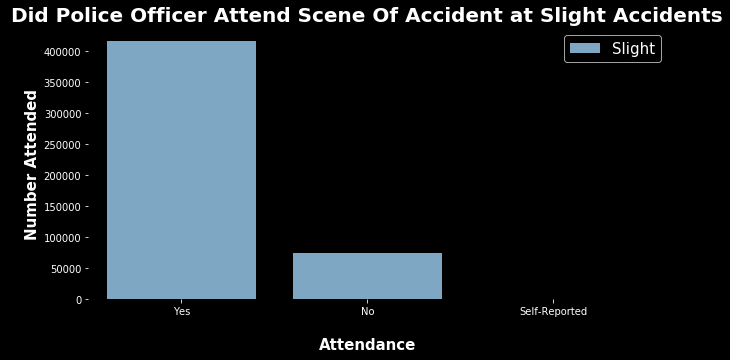

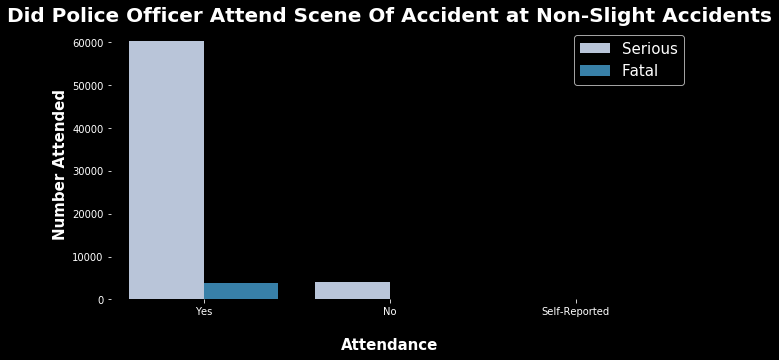

In [251]:
#Did Police Officer Attend Scene Of Accident (slight)

plt.figure(figsize=(10,5))
sns.countplot("did_police_officer_attend_scene_of_accident", hue="accident_severity",  
              palette="PuBu", data=slight)

plt.title("Did Police Officer Attend Scene Of Accident at Slight Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nAttendance", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber Attended", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Did Police Officer Attend Scene Of Accident (Non-slight)

plt.figure(figsize=(10,5))
sns.countplot("did_police_officer_attend_scene_of_accident", hue="accident_severity",  
              palette="PuBu", data=nonslight)

plt.title("Did Police Officer Attend Scene Of Accident at Non-Slight Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nAttendance", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber Attended", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#### Urban  or Rural  Area vs Accident Severity

In [252]:
#urban_or_rural_area
uornonslight=nonslight.groupby(['urban_or_rural_area'])['accident_severity'].count().sort_values(ascending=False)
uornonslighttot = nonslight['accident_severity'].count()



uorslight=slight.groupby(['urban_or_rural_area'])['accident_severity'].count().sort_values(ascending=False)
uorslighttot = slight['accident_severity'].count()


print("Non-Slight Severity Totals by Police Attendance:\n", uornonslight)
print('\n')
print("NonSlight Percentages:\n", uornonslight/uornonslighttot)
print('\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('\n')
print("Slight Severity Totals by Police Attendance:\n", uorslight)
print('\n')
print("Slight Percentages:\n", uorslight/uorslighttot)

Non-Slight Severity Totals by Police Attendance:
 urban_or_rural_area
Urban    42671
Rural    25660
Name: accident_severity, dtype: int64


NonSlight Percentages:
 urban_or_rural_area
Urban    0.624475
Rural    0.375525
Name: accident_severity, dtype: float64


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Slight Severity Totals by Police Attendance:
 urban_or_rural_area
Urban    352498
Rural    140306
Name: accident_severity, dtype: int64


Slight Percentages:
 urban_or_rural_area
Urban    0.71529
Rural    0.28471
Name: accident_severity, dtype: float64


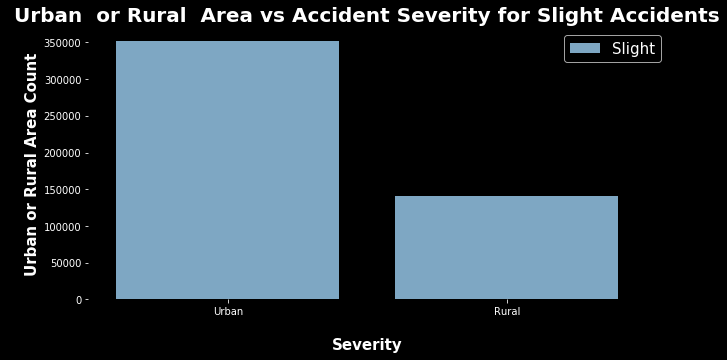

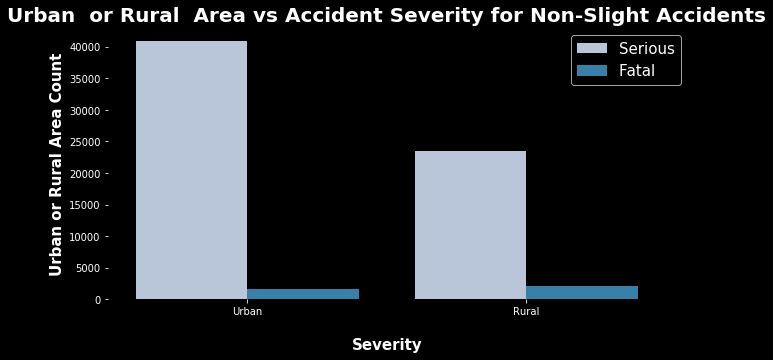

In [253]:
#urban_or_rural_area vs accident severity slight

plt.figure(figsize=(10,5))
sns.countplot("urban_or_rural_area", hue="accident_severity",  
              palette="PuBu", data=slight)

plt.title("Urban  or Rural  Area vs Accident Severity for Slight Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nSeverity", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nUrban or Rural Area Count", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#urban_or_rural_area vs accident severity non slight

plt.figure(figsize=(10,5))
sns.countplot("urban_or_rural_area", hue="accident_severity",  
              palette="PuBu", data=nonslight)

plt.title("Urban  or Rural  Area vs Accident Severity for Non-Slight Accidents",fontsize=20,fontweight="bold")
plt.style.use('dark_background')
plt.xlabel("\nSeverity", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nUrban or Rural Area Count", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

Looking at the groupbys I see that there are more total fatal accidents in rural areas and a higher percentage of serious accidents in rural areas.

#### Number of Vehicles

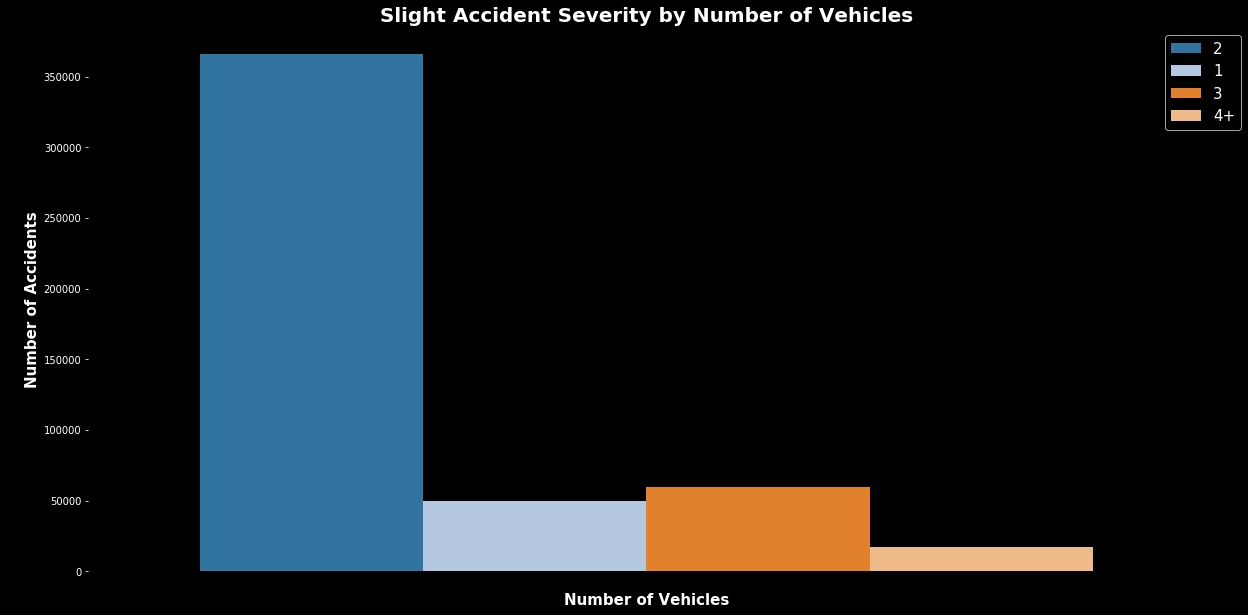

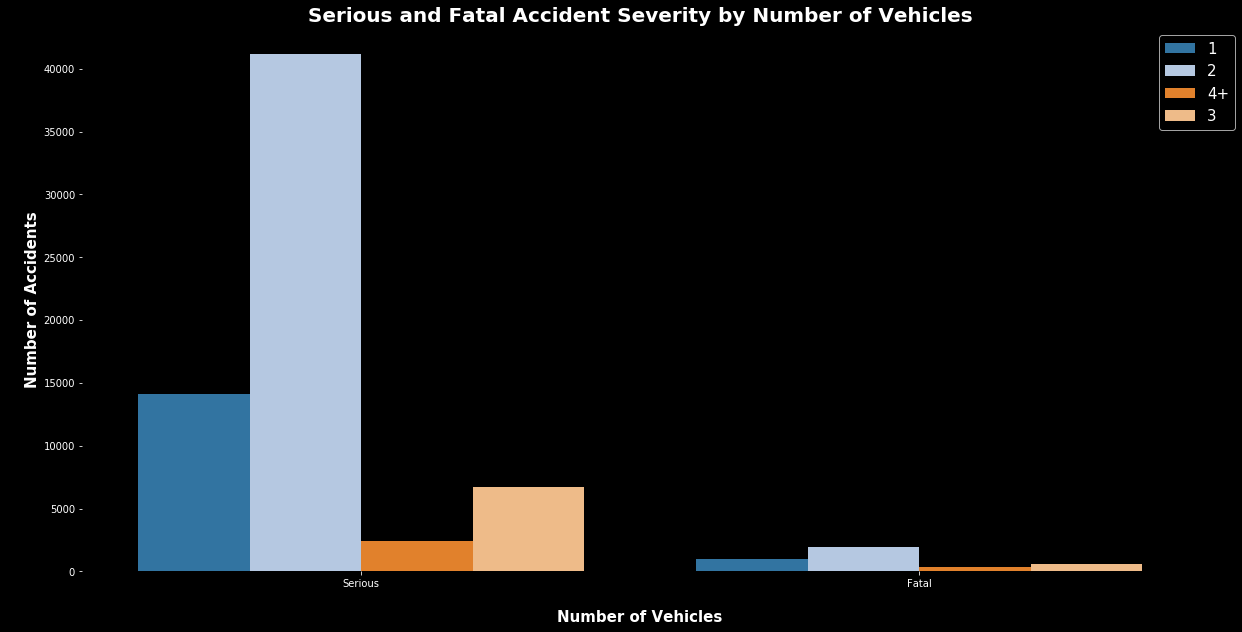

In [256]:
#all number of vehicles vs accident severity(slight)

plt.figure(figsize=(20,10))
sns.countplot("accident_severity", hue="number_of_vehicles",
              palette="tab20", data=slight)

plt.style.use('dark_background')
plt.title("Slight Accident Severity by Number of Vehicles",
          fontsize=20, fontweight="bold")

plt.xlabel("\nNumber of Vehicles", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#nonslight number of vehicles vs accident severity (nonslight)

plt.figure(figsize=(20,10))
sns.countplot("accident_severity", hue="number_of_vehicles",
              palette="tab20", data=nonslight)

plt.style.use('dark_background')
plt.title("Serious and Fatal Accident Severity by Number of Vehicles",
          fontsize=20, fontweight="bold")

plt.xlabel("\nNumber of Vehicles", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



When there were serious and fatal accidents the majority of the time it involved 2 cars. 

#### Vehicle Manoeuvres

In [190]:
print("Slight Totals by  Vehicle Manuevers:\n",
      slight.groupby(['vehicle_manoeuvre'])['accident_severity'].count().sort_values(ascending=False))
print('\n')
print("Non-Slight Severity Overall Totals by Vehicle Manuevers:\n",
      nonslight.groupby(['vehicle_manoeuvre'])['accident_severity'].count().sort_values(ascending=False))

Severity Overall Totals by  Vehicle Manuevers:
 vehicle_manoeuvre
Going ahead other                      232821
Turning right                           99491
Waiting to go - held up                 45536
Slowing or stopping                     40486
Moving off                              30965
Turning left                            28497
Waiting to turn right                   16009
Going ahead right-hand bend             12816
Going ahead left-hand bend              10321
Parked                                   8151
Overtaking moving vehicle - offside      7014
Reversing                                5992
Waiting to turn left                     5698
Overtaking static vehicle - offside      4570
U-turn                                   3967
Changing lane to right                   3451
Changing lane to left                    3327
Overtaking - nearside                    2023
Name: accident_severity, dtype: int64


Non-Slight Severity Overall Totals by Vehicle Manuevers:
 vehicle_

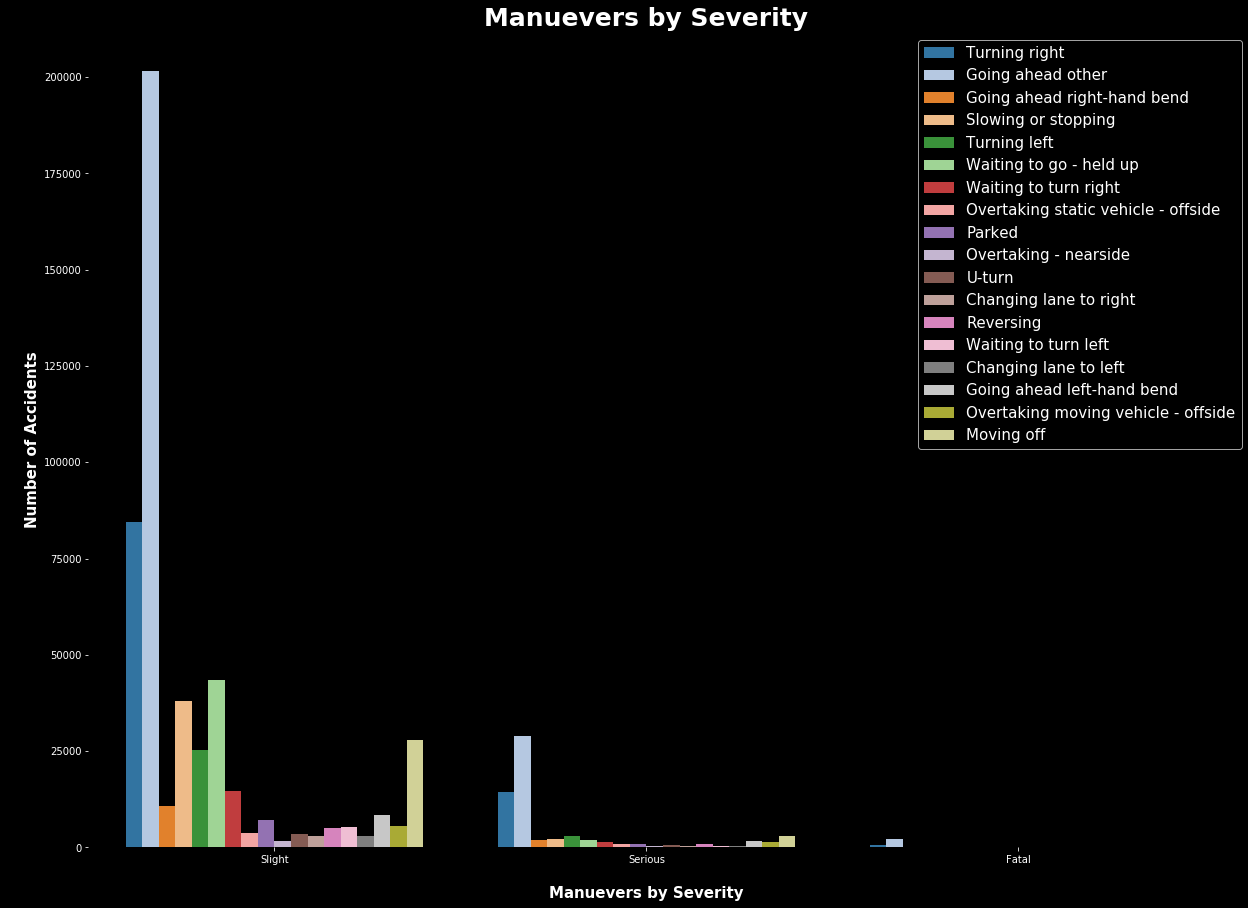

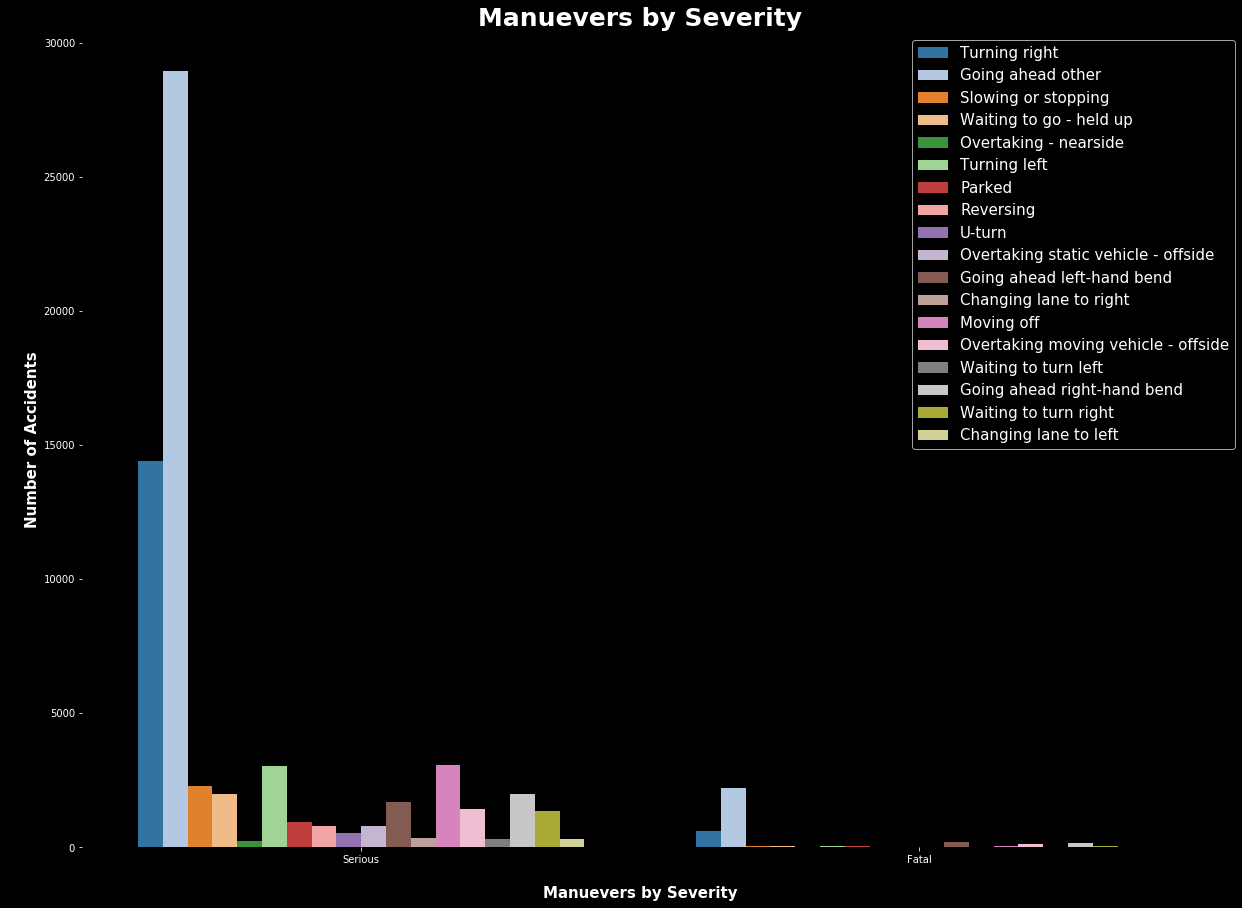

In [185]:
#Manuevers by Severity
plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="vehicle_manoeuvre",
              palette="tab20", data=df)

plt.style.use('dark_background')
plt.title("Manuevers by Severity",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers by Severity", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Manuevers by Severity
plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="vehicle_manoeuvre",
              palette="tab20", data=nonslight)

plt.style.use('dark_background')
plt.title("Manuevers by Severity",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers by Severity", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

"Going ahead other" and "Turning right" were the vehicle manuevers of the majority of accidents. Waiting to go and being held up was the 3rd vehicle manuever for overall accidents and when they were more severe, the 3rd manuever was "Moving off".

In [ ]:
#driver_home_area_type


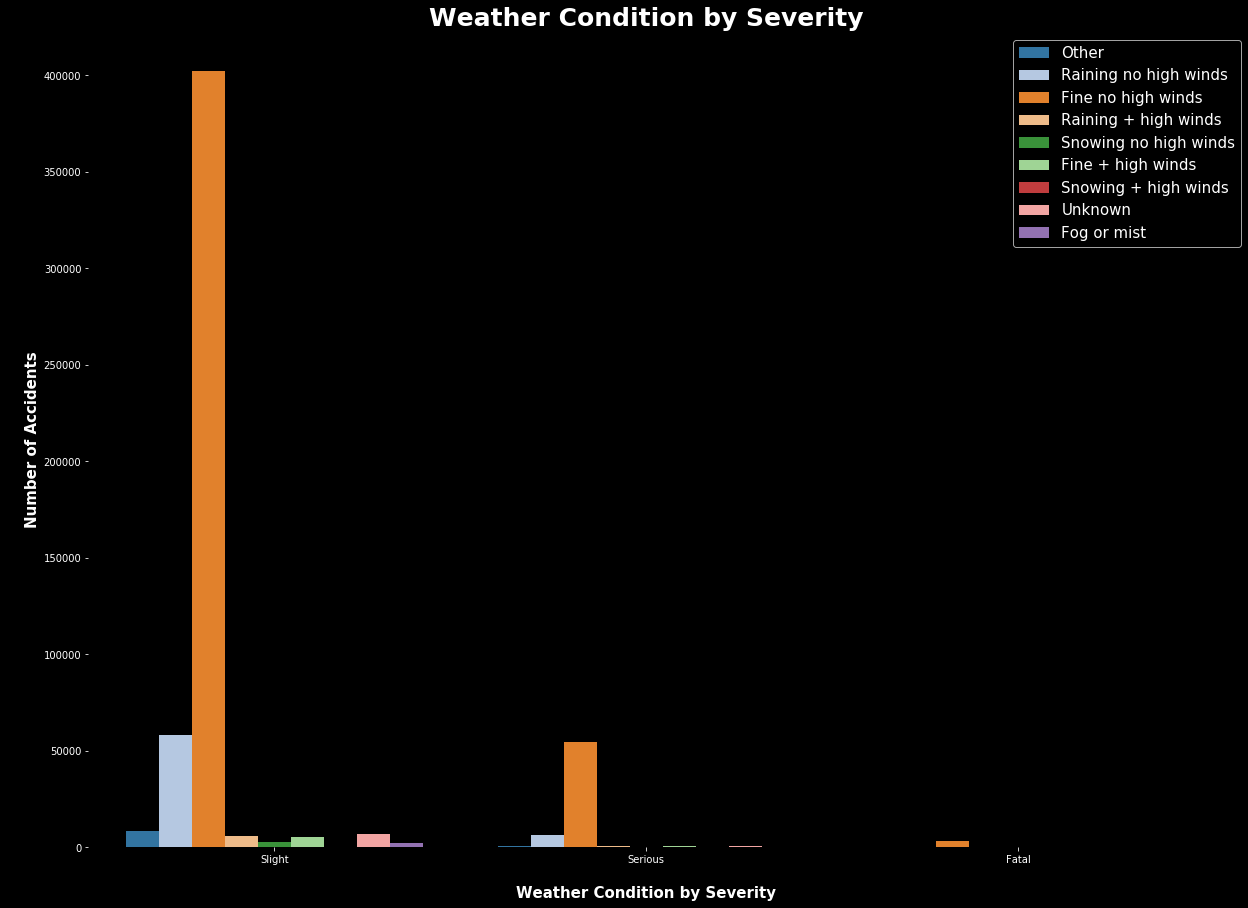

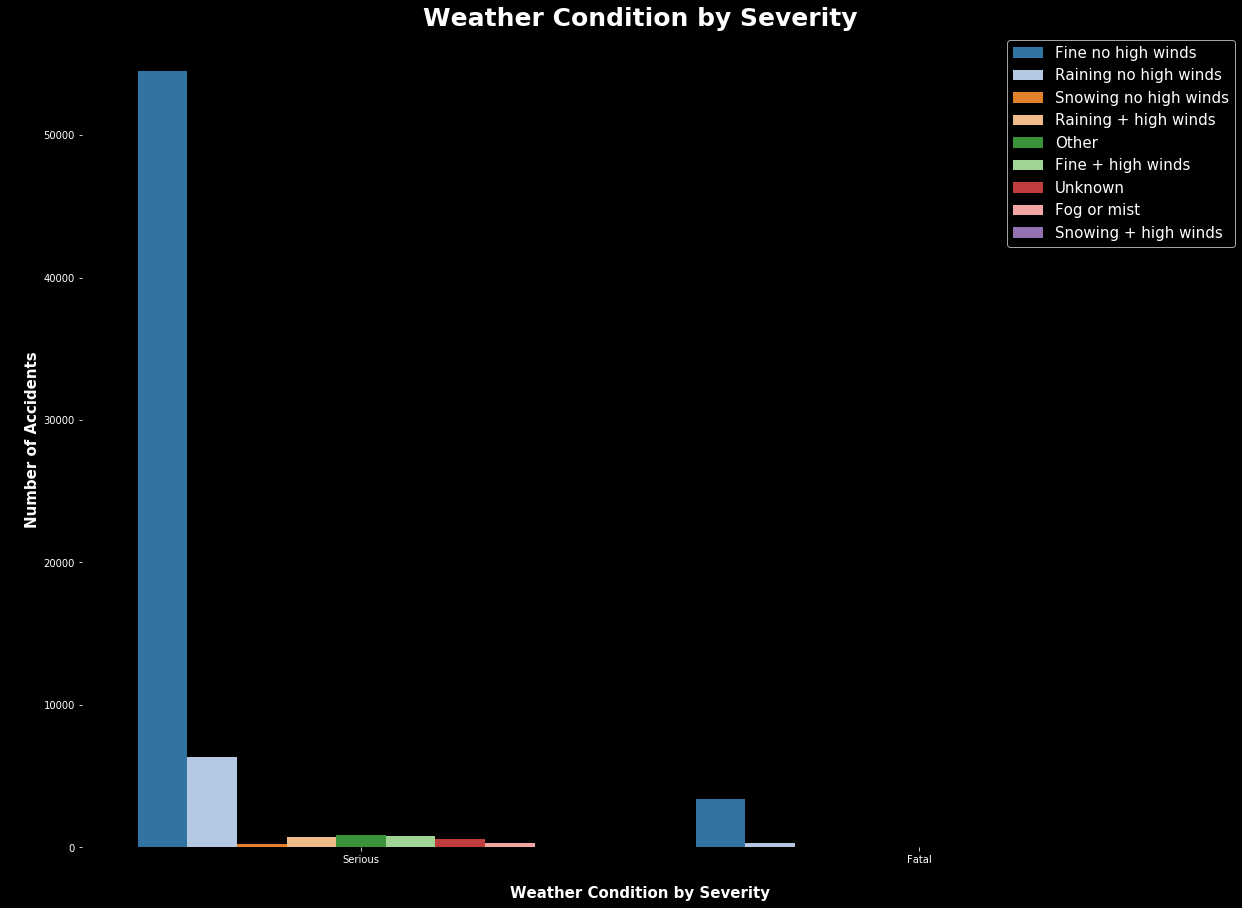

In [200]:
#Weather Condition by Severity
plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="weather_conditions",
              palette="tab20", data=df)

plt.style.use('dark_background')
plt.title("Weather Condition by Severity",fontsize=25,fontweight="bold")
plt.xlabel("\nWeather Condition by Severity", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Weather Condition by Severity
plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="weather_conditions",
              palette="tab20", data=nonslight)

plt.style.use('dark_background')
plt.title("Weather Condition by Severity",fontsize=25,fontweight="bold")
plt.xlabel("\nWeather Condition by Severity", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

Majority of accidents seem to happen in Fine weather. No weather significance is seen.

*I would like to know the number of cars on the road during these weather conditions. I think ratios would be better here over total numbers. 

#### 1st Road Class

In [204]:
#1st_road_class 
print("Severity Overall Totals by  1st_road_class:\n",
      df.groupby(['1st_road_class'])['accident_severity'].count().sort_values(ascending=False))
print('\n')
print("Non-Slight Severity Overall Totals by 1st_road_class:\n",
      nonslight.groupby(['1st_road_class'])['accident_severity'].count().sort_values(ascending=False))

Severity Overall Totals by  1st_road_class:
 1st_road_class
A               282563
Unclassified    149103
B                74182
C                45488
Motorway          8683
A(M)              1116
Name: accident_severity, dtype: int64


Non-Slight Severity Overall Totals by 1st_road_class:
 1st_road_class
A               34416
Unclassified    17841
B                9868
C                5299
Motorway          818
A(M)               89
Name: accident_severity, dtype: int64


The majority of acccidents seem to be caused on A type rosds followed by Unclassified roads. As a limitiation of the data that I have, understanding more about these roads is not possible. Also, as a personal choice, I decided not to graph this.

#### Hit Object Off Carriageway


In [257]:
#hit_object_off_carriageway


hitslight=slight.groupby(['hit_object_off_carriageway'])['accident_severity'].count().sort_values(ascending=False)
hitslighttot =  slight['accident_severity'].count()


hitnonslight=nonslight.groupby(['hit_object_off_carriageway'])['accident_severity'].count().sort_values(ascending=False)
hitnonslighttot = nonslight['accident_severity'].count()


print("Severity Overslight Totals by  Object Hit:\n", hitslight )
print('\n')
print("Total Percentages:\n", hitslight/hitslighttot)
print('\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('\n')
print("Non-Slight Severity Overslight Totals by Object Hit:\n", hitnonslight)
print('\n')
print("NonSlight Percentages:\n", hitnonslight/hitnonslighttot)

Severity Overslight Totals by  Object Hit:
 hit_object_off_carriageway
None                             464764
Other permanent object             8606
Road sign or traffic signal        4802
Lamp post                          3452
Tree                               2702
Wall or fence                      2467
Near/Offside crash barrier         2250
Entered ditch                      1566
Central crash barrier              1240
Telegraph or electricity pole       714
Bus stop or bus shelter             228
Submerged in water                   13
Name: accident_severity, dtype: int64


Total Percentages:
 hit_object_off_carriageway
None                             0.943101
Other permanent object           0.017463
Road sign or traffic signal      0.009744
Lamp post                        0.007005
Tree                             0.005483
Wall or fence                    0.005006
Near/Offside crash barrier       0.004566
Entered ditch                    0.003178
Central crash barrier     

The majority of accidents did not involve objects being hit but when they were it was a miscellaneous permanent object or a tree. For more severe accidents, there were a higher chance of an object off the carriageway being hit.

#### Junction Control

In [222]:
#junction_control


juncall=df.groupby(['junction_control'])['accident_severity'].count().sort_values(ascending=False)
juncalltot =  df['accident_severity'].count()


juncnonslight=nonslight.groupby(['junction_control'])['accident_severity'].count().sort_values(ascending=False)
juncnonslighttot = nonslight['accident_severity'].count()


print("Severity Overall Totals by Junction Control:\n", juncall )
print('\n')
print("Total Percentages:\n", juncall/juncalltot)
print('\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('\n')
print("Non-Slight Severity Overall Totals by Junction Control:\n", juncnonslight)
print('\n')
print("NonSlight Percentages:\n", juncnonslight/juncnonslighttot)

Severity Overall Totals by Junction Control:
 junction_control
Give way or uncontrolled               449396
Auto traffic signal                     96040
Not at junction or within 20 metres      9339
Stop sign                                5096
Authorised person                        1264
Name: accident_severity, dtype: int64


Total Percentages:
 junction_control
Give way or uncontrolled               0.800870
Auto traffic signal                    0.171153
Not at junction or within 20 metres    0.016643
Stop sign                              0.009082
Authorised person                      0.002253
Name: accident_severity, dtype: float64


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Non-Slight Severity Overall Totals by Junction Control:
 junction_control
Give way or uncontrolled               56961
Auto traffic signal                     8953
Not at junction or within 20 metres     1644
Stop sign                                612
Authorised person              

The majority of accidents happened in an area that was uncontrolled however more serious accidents had a higher percentage of uncontrolled accidents.

#### Age Band of Driver

In [226]:
#age_band_of_driver 


ageall=df.groupby(['age_band_of_driver'])['accident_severity'].count().sort_values(ascending=False)
agealltot =  df['accident_severity'].count()


agenonslight=nonslight.groupby(['age_band_of_driver'])['accident_severity'].count().sort_values(ascending=False)
agenonslighttot = nonslight['accident_severity'].count()


print("Severity Overall Totals by Age:\n", ageall )
print('\n')
print("Total Percentages:\n", ageall/agealltot)
print('\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('\n')
print("Non-Slight Severity Overall Totals by Age:\n", agenonslight)
print('\n')
print("NonSlight Percentages:\n", agenonslight/agenonslighttot)

Severity Overall Totals by Age:
 age_band_of_driver
26-45       243123
46-65       156697
16-25       108605
Over 65      52645
Under 16        65
Name: accident_severity, dtype: int64


Total Percentages:
 age_band_of_driver
26-45       0.433270
46-65       0.279250
16-25       0.193545
Over 65     0.093819
Under 16    0.000116
Name: accident_severity, dtype: float64


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Non-Slight Severity Overall Totals by Age:
 age_band_of_driver
26-45       27198
46-65       20272
16-25       12290
Over 65      8559
Under 16       12
Name: accident_severity, dtype: int64


NonSlight Percentages:
 age_band_of_driver
26-45       0.398033
46-65       0.296674
16-25       0.179860
Over 65     0.125258
Under 16    0.000176
Name: accident_severity, dtype: float64


The majority of accidents are involving people between 26-45. They were also in the more serious accidents. The percentages of people in more severe accidents were a lot closer among the age groups 26-45 and 46-65. There were a higher pecentage of people over 65 and under 16 in more serious accidents than they were in accidents overall. These percentages were lower in other groups. 

In [ ]:
#

In [227]:
#vehicle_type



vehall=df.groupby(['vehicle_type'])['accident_severity'].count().sort_values(ascending=False)
vehalltot =  df['accident_severity'].count()


vehnonslight=nonslight.groupby(['vehicle_type'])['accident_severity'].count().sort_values(ascending=False)
vehnonslighttot = nonslight['accident_severity'].count()


print("Severity Overall Totals by Vehice Type:\n", vehall )
print('\n')
print("Total Percentages:\n", vehall/vehalltot)
print('\n')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('\n')
print("Non-Slight Severity Overall Totals by Vehicle Type:\n", vehnonslight)
print('\n')
print("NonSlight Percentages:\n", vehnonslight/vehnonslighttot)

Severity Overall Totals by Vehice Type:
 vehicle_type
Car                                     499324
Van_Goods_vehicle                        31388
Motorcycle                               28719
Bus                                        787
Other vehicle                              778
Bus or coach (17 or more pass seats)       139
Name: accident_severity, dtype: int64


Total Percentvehs:
 vehicle_type
Car                                     0.889846
Van_Goods_vehicle                       0.055937
Motorcycle                              0.051180
Bus                                     0.001403
Other vehicle                           0.001386
Bus or coach (17 or more pass seats)    0.000248
Name: accident_severity, dtype: float64


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Non-Slight Severity Overall Totals by Vehicle Type:
 vehicle_type
Car                                     54464
Motorcycle                               9384
Van_Goods_vehicle                 

In [109]:
#create junction_detail groupings
df_miniround = df[(df['junction_detail']=='Mini-roundabout')]
df_more4arms = df[(df['junction_detail']=='More than 4 arms (not roundabout)')]
df_notjunction = df[(df['junction_detail']=='Not at junction or within 20 metres')]
df_otherjunction = df[(df['junction_detail']=='Other junction')]
df_private = df[(df['junction_detail']=='Private drive or entrance')]
df_roundabout = df[(df['junction_detail']=='Roundabout')]
df_sliproad = df[(df['junction_detail']=='Slip road')]
df_tstaggered = df[(df['junction_detail']=='T or staggered junction')]

#setup groupings for impact points
df_front = df[(df['x1st_point_of_impact']=='Front')]
df_nearside = df[(df['x1st_point_of_impact']=='Nearside')]
df_back = df[(df['x1st_point_of_impact']=='Back')]
df_offside = df[(df['x1st_point_of_impact']=='Offside')]
df_noimpact = df[(df['x1st_point_of_impact']=='Did not impact')]

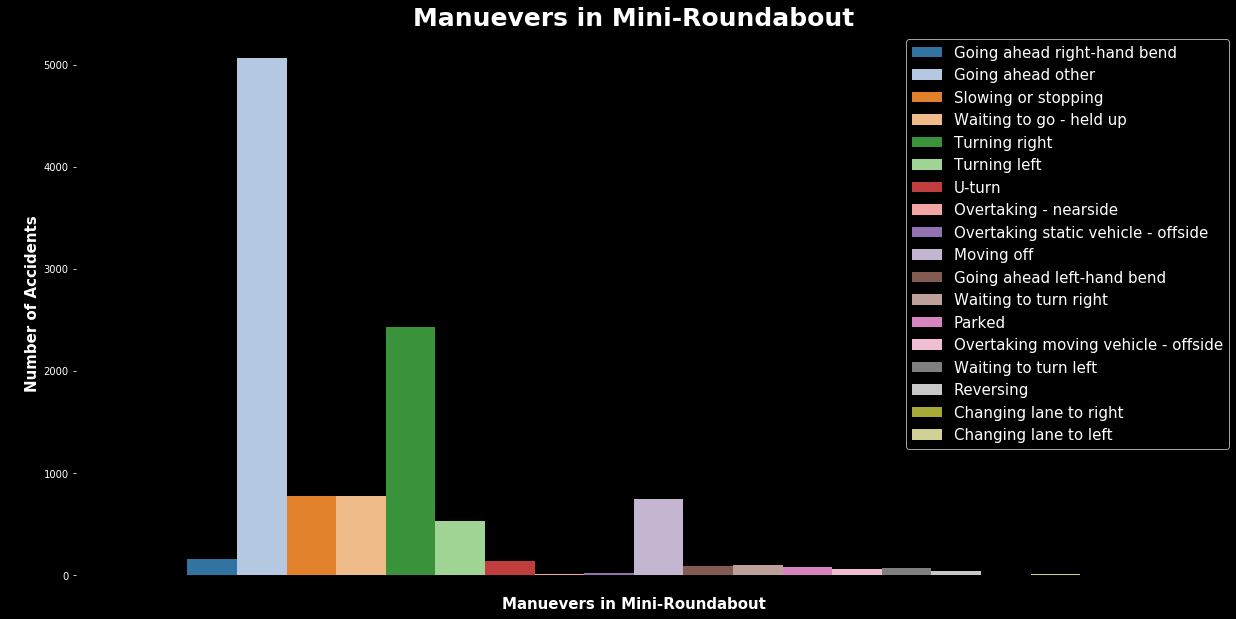

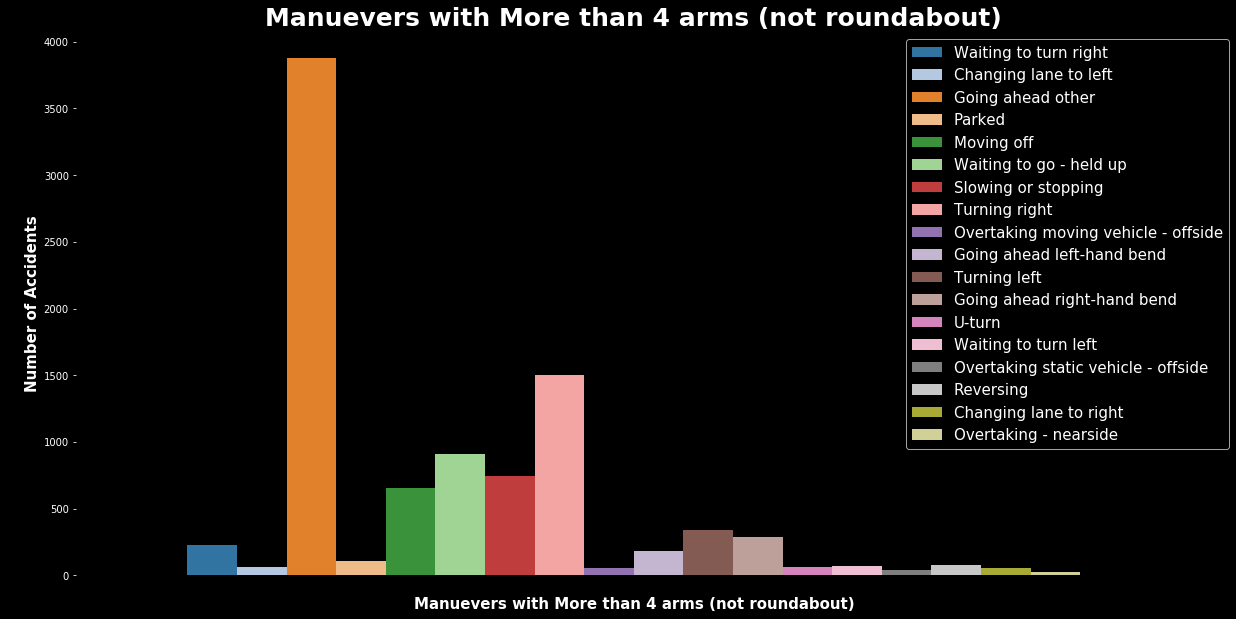

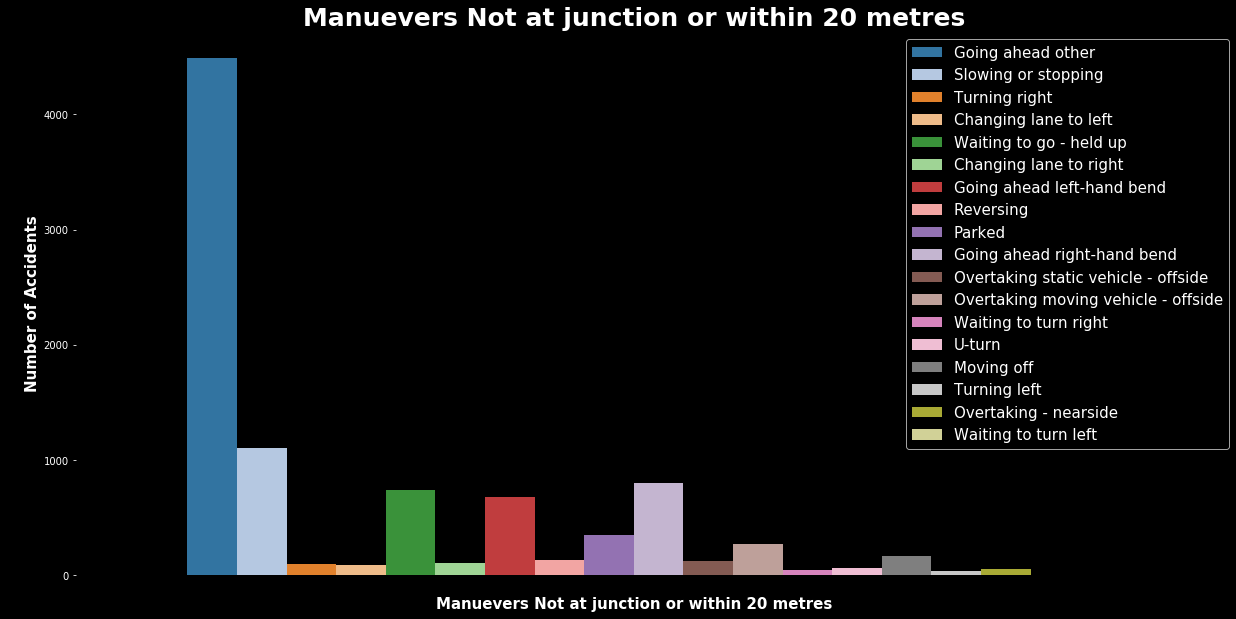

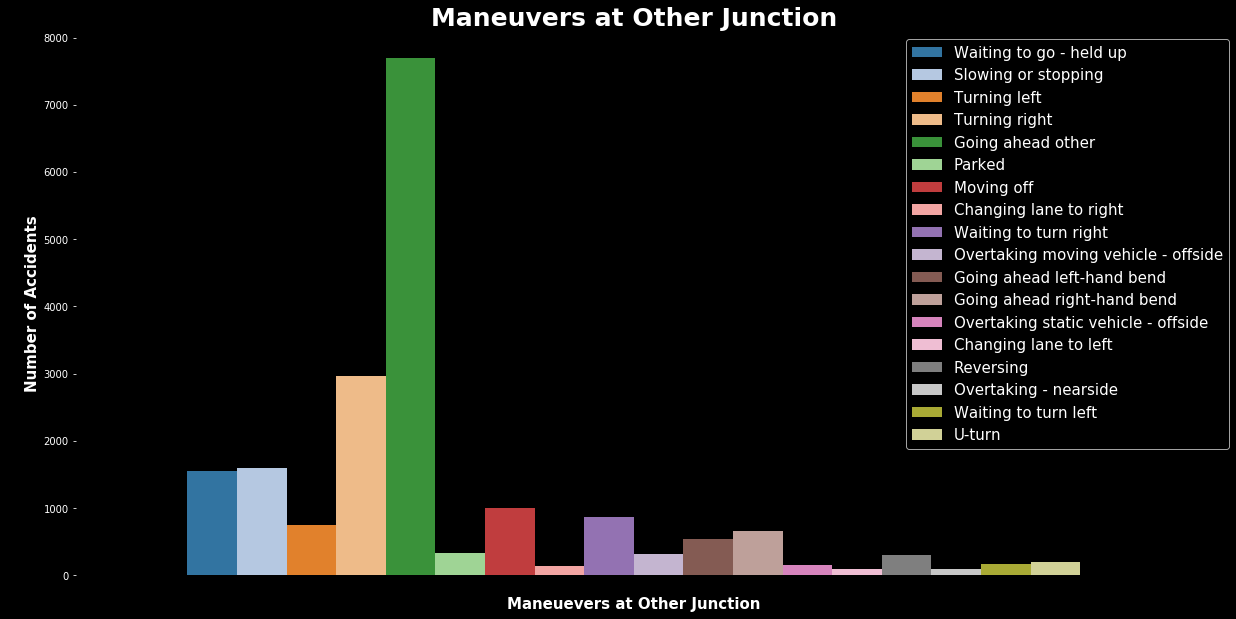

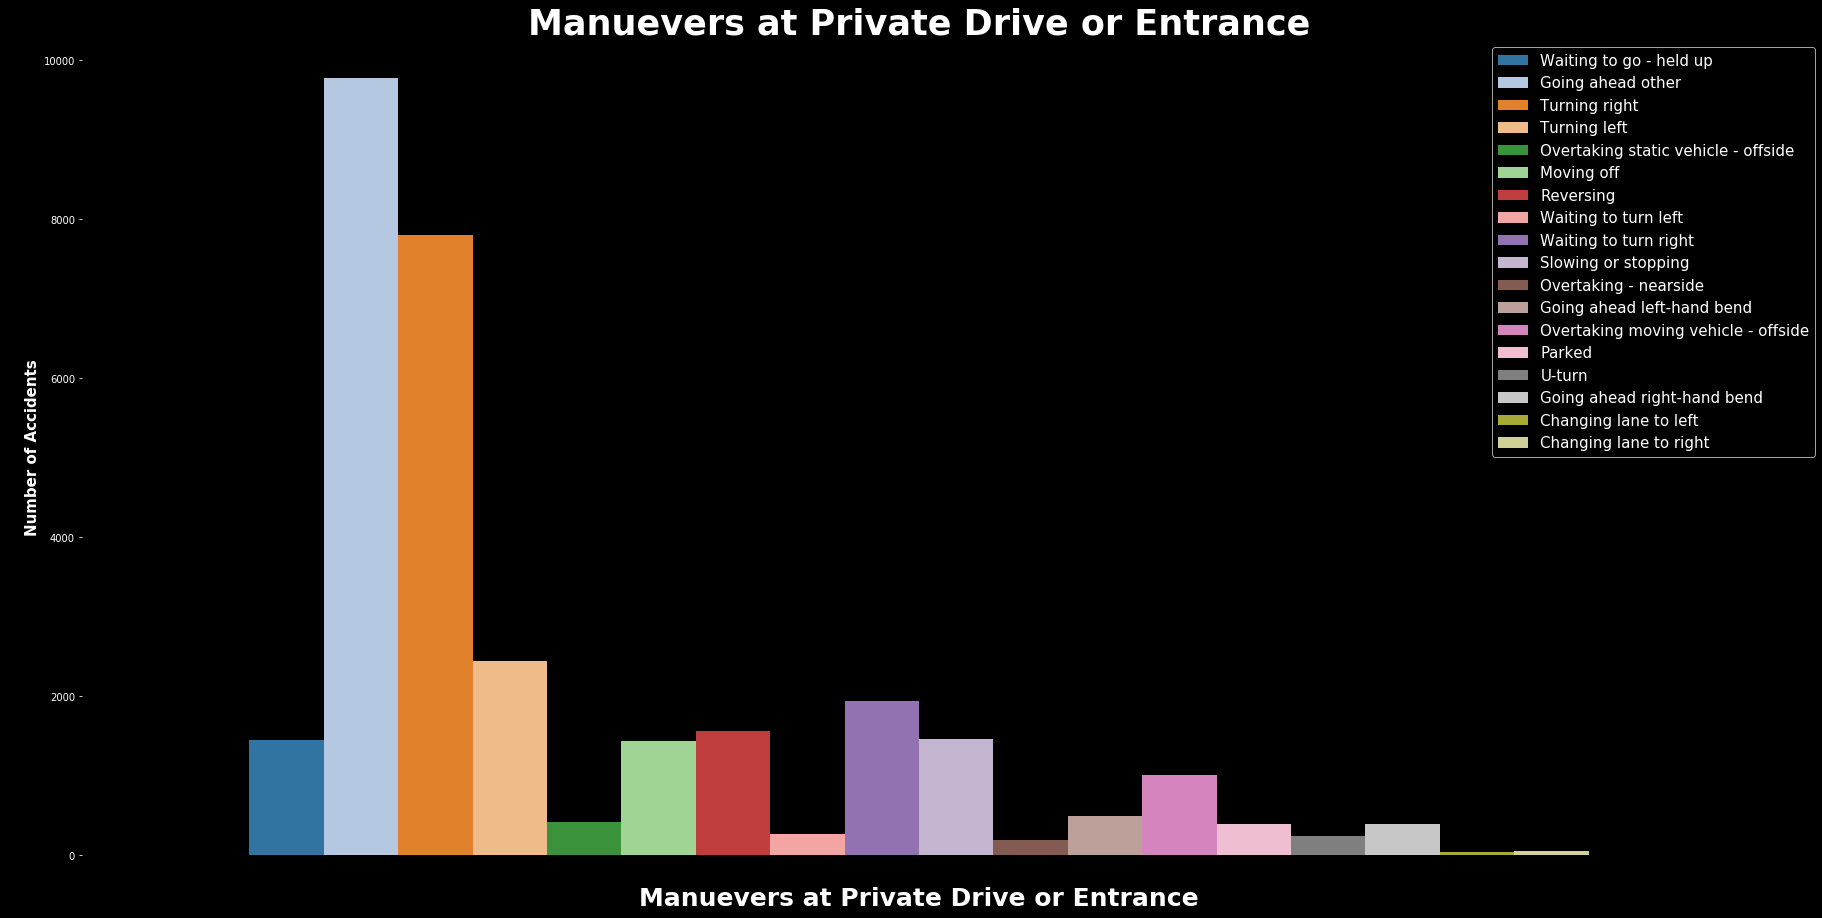

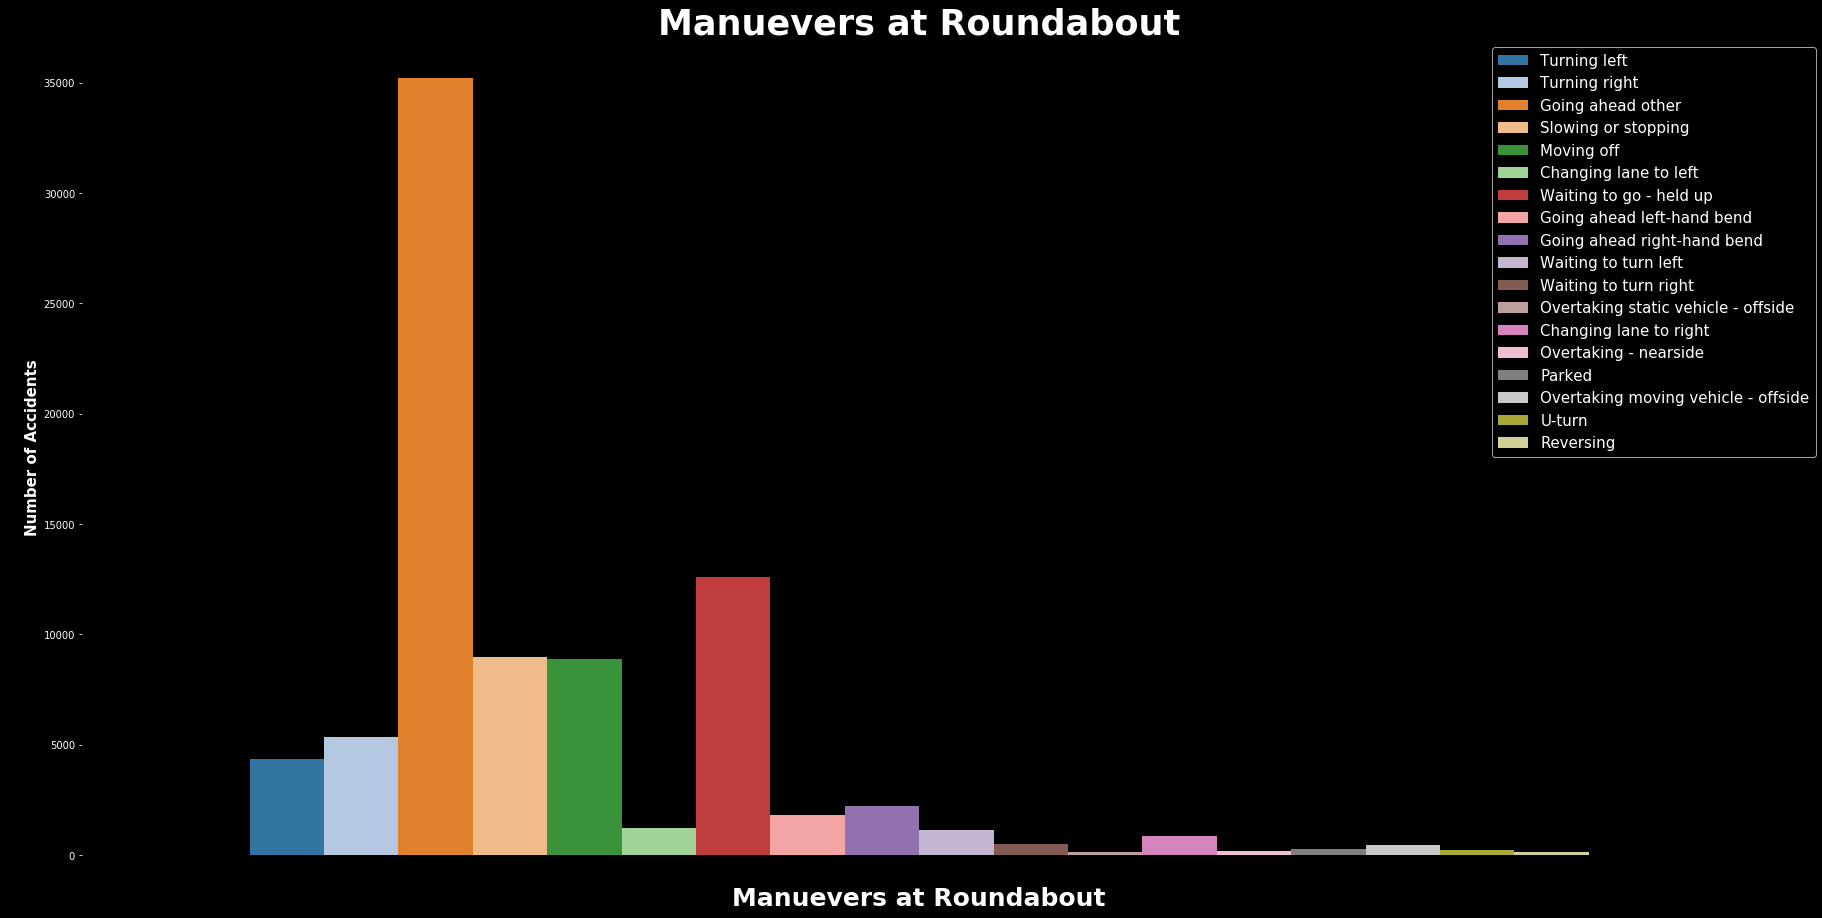

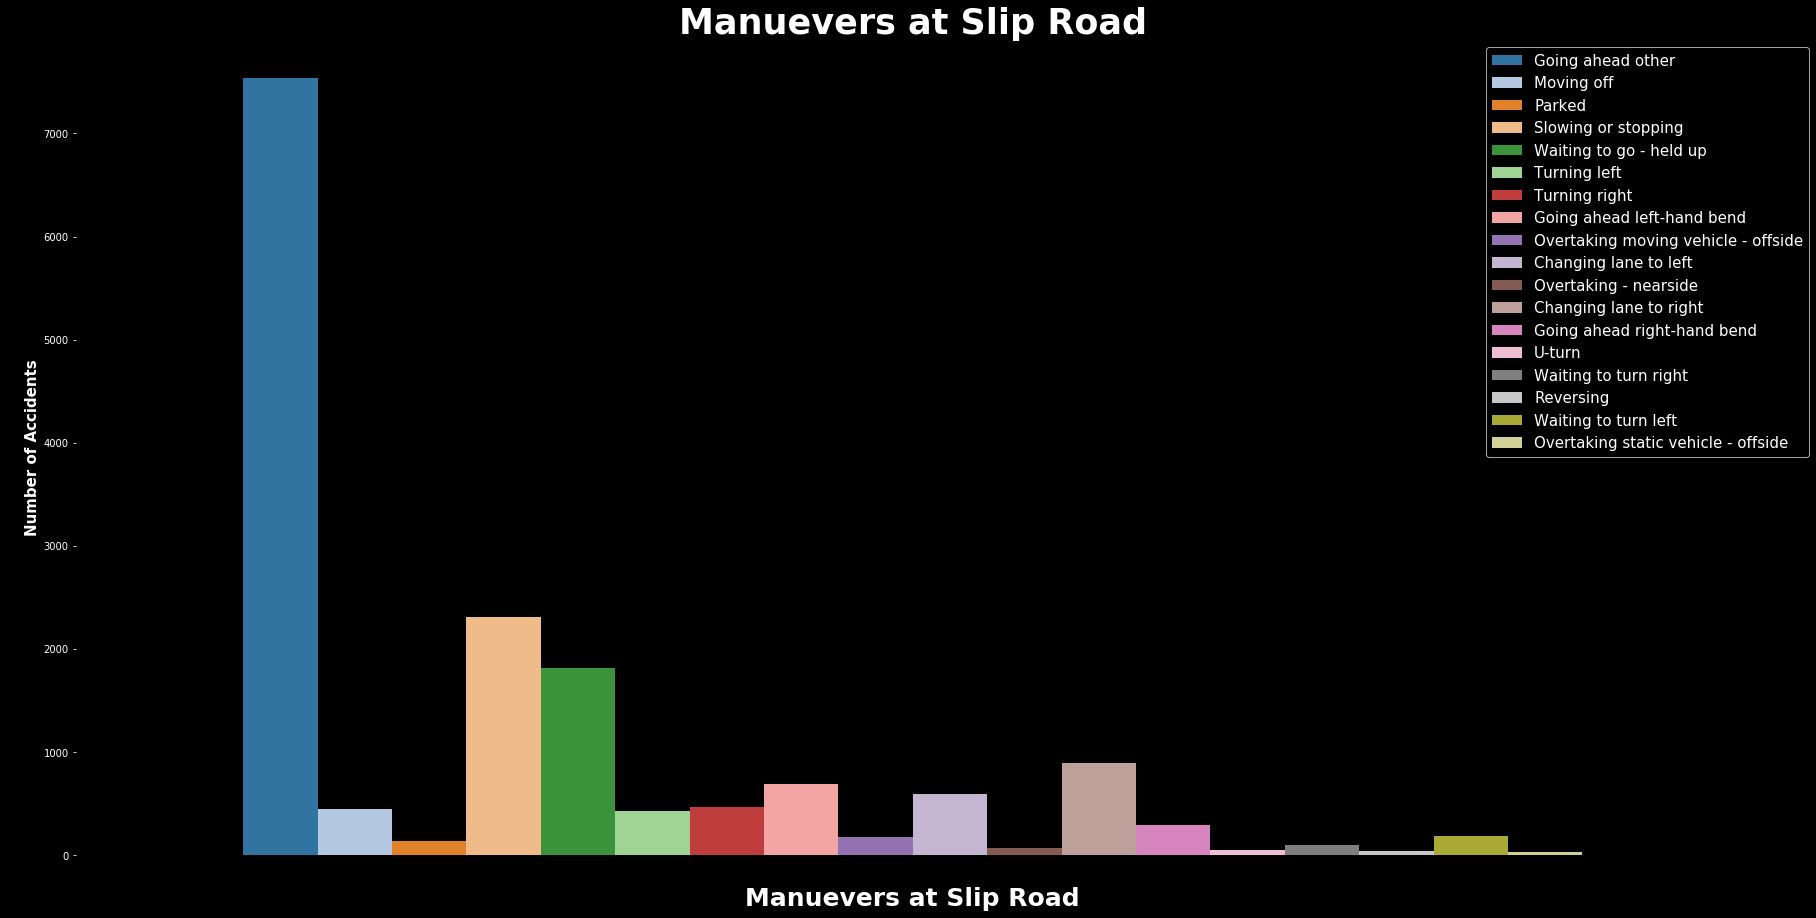

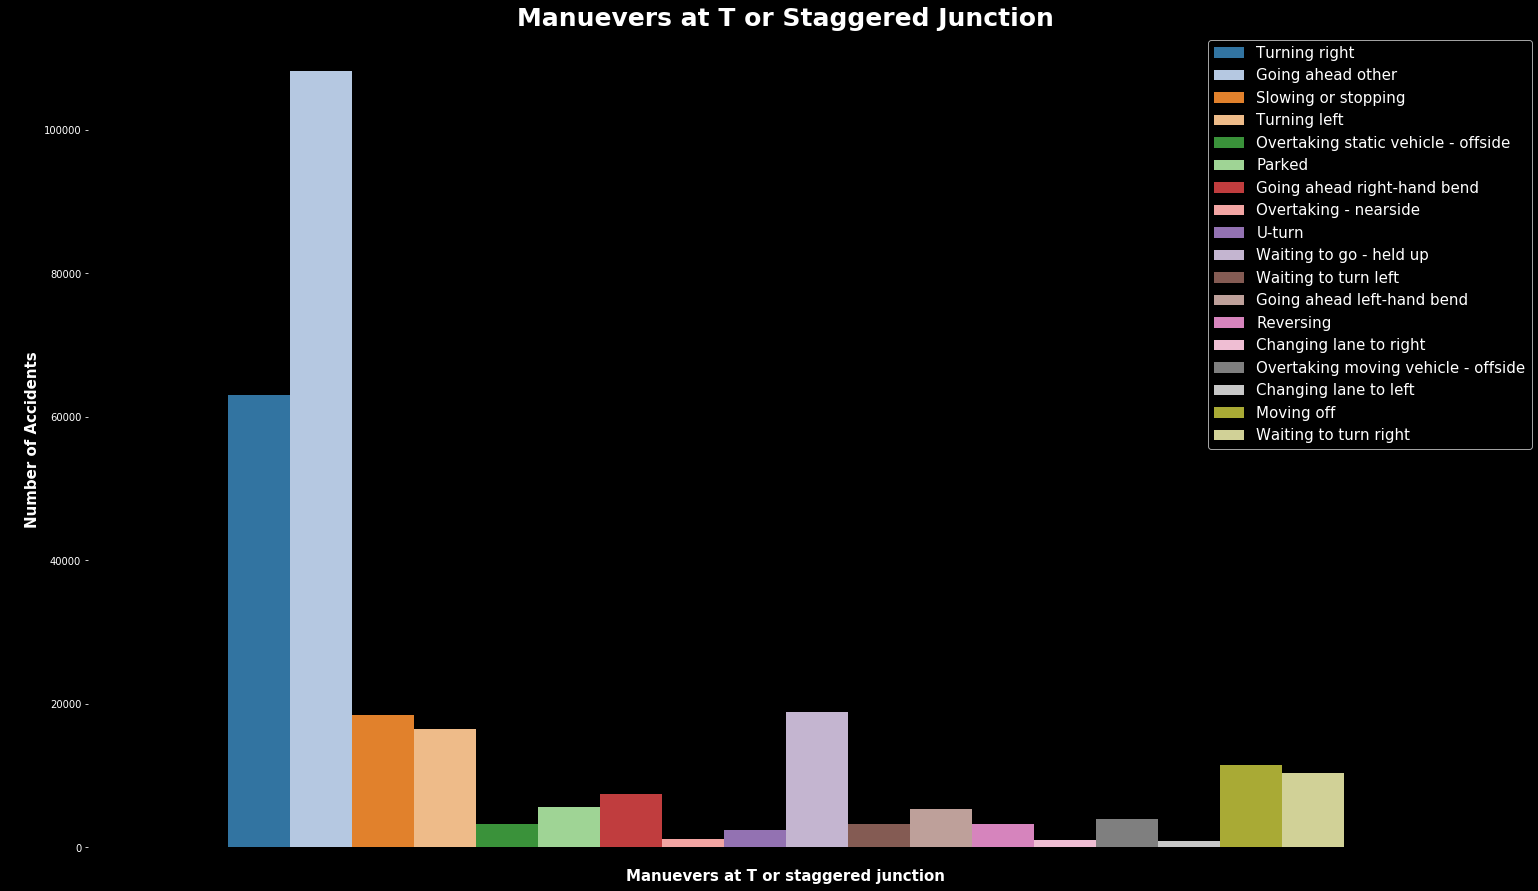

In [147]:
#Manuevers in Mini-Roundabout
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_miniround)

plt.style.use('dark_background')
plt.title("Manuevers in Mini-Roundabout",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers in Mini-Roundabout", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Manuevers with More than 4 arms (not roundabout)
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_more4arms)

plt.style.use('dark_background')
plt.title("Manuevers with More than 4 arms (not roundabout)",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers with More than 4 arms (not roundabout)", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#Manuevers Not at junction or within 20 metres
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_notjunction)

plt.style.use('dark_background')
plt.title("Manuevers Not at junction or within 20 metres",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers Not at junction or within 20 metres", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Maneuevers at Other Junction
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_otherjunction)
plt.style.use('dark_background')
plt.title("Maneuvers at Other Junction",fontsize=25,fontweight="bold")
plt.xlabel("\nManeuevers at Other Junction", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Manuevers at Private drive or entrance
plt.figure(figsize=(30,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_private)

plt.style.use('dark_background')
plt.title("Manuevers at Private Drive or Entrance",
          fontsize=35, fontweight="bold")
plt.xlabel("\nManuevers at Private Drive or Entrance", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Roundabout
plt.figure(figsize=(30,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_roundabout)

plt.style.use('dark_background')
plt.title("Manuevers at Roundabout",fontsize=35,fontweight="bold")
plt.xlabel("\nManuevers at Roundabout", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Slip road
plt.figure(figsize=(30,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_sliproad )

plt.style.use('dark_background')
plt.title("Manuevers at Slip Road",fontsize=35,fontweight="bold")
plt.xlabel("\nManuevers at Slip Road", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#T or staggered junction
tstaggered = fatal[(fatal['junction_detail']=='T or staggered junction')]
plt.figure(figsize=(25,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=df_tstaggered)

plt.style.use('dark_background')
plt.title("Manuevers at T or Staggered Junction",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers at T or staggered junction", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

I wanted to look at the breakdown of each accident severity more closely. 

In [103]:
print(df.groupby(['x1st_point_of_impact'])['junction_detail'].count().sort_values(ascending=False))
print('\n')
print(df.groupby(['junction_detail'])['x1st_point_of_impact'].count().sort_values(ascending=False))

x1st_point_of_impact
Front             275785
Back              104433
Offside            86833
Nearside           78489
Did not impact     15595
Name: junction_detail, dtype: int64


junction_detail
T or staggered junction                284673
Crossroads                              95356
Roundabout                              84344
Private drive or entrance               31295
Other junction                          19440
Slip road                               16239
Mini-roundabout                         11140
Not at junction or within 20 metres      9366
More than 4 arms (not roundabout)        9282
Name: x1st_point_of_impact, dtype: int64


In [108]:
# print(slight.groupby(['x1st_point_of_impact','junction_detail'])['junction_detail'].count().sort_values(ascending=False))
print('\n')
print(slight.groupby(['junction_detail',
                      'x1st_point_of_impact'])['x1st_point_of_impact'].count())



junction_detail                      x1st_point_of_impact
Crossroads                           Back                     11632
                                     Did not impact            1622
                                     Front                    43095
                                     Nearside                 13991
                                     Offside                  13892
Mini-roundabout                      Back                      1428
                                     Did not impact             225
                                     Front                     5196
                                     Nearside                  1582
                                     Offside                   1729
More than 4 arms (not roundabout)    Back                      1696
                                     Did not impact             230
                                     Front                     4097
                                     Nearside           

In [105]:
print(serious.groupby(['x1st_point_of_impact'])['junction_detail'].count().sort_values(ascending=False))
print('\n')
print(serious.groupby(['junction_detail'])['x1st_point_of_impact'].count().sort_values(ascending=False))

x1st_point_of_impact
Front             35089
Offside           11589
Nearside           9755
Back               5388
Did not impact     2626
Name: junction_detail, dtype: int64


junction_detail
T or staggered junction                35686
Crossroads                             10559
Roundabout                              6646
Private drive or entrance               4356
Other junction                          2309
Slip road                               1571
Not at junction or within 20 metres     1443
Mini-roundabout                          946
More than 4 arms (not roundabout)        931
Name: x1st_point_of_impact, dtype: int64


In [102]:
print(fatal.groupby(['x1st_point_of_impact'])['junction_detail'].count())
print('\n')
print(fatal.groupby(['junction_detail'])['x1st_point_of_impact'].count())

x1st_point_of_impact
Back               222
Did not impact     177
Front             2390
Nearside           462
Offside            633
Name: junction_detail, dtype: int64


junction_detail
Crossroads                              565
Mini-roundabout                          34
More than 4 arms (not roundabout)        40
Not at junction or within 20 metres     202
Other junction                          176
Private drive or entrance               331
Roundabout                              190
Slip road                               177
T or staggered junction                2169
Name: x1st_point_of_impact, dtype: int64


### Fatal Accidents Analysis

In [218]:
fatal.groupby(['x1st_point_of_impact'])['junction_detail'].count().sort_values(ascending=False)


x1st_point_of_impact
Front             2390
Offside            633
Nearside           462
Back               222
Did not impact     177
Name: junction_detail, dtype: int64

In [219]:
fatal.groupby(['junction_detail'])['x1st_point_of_impact'].count().sort_values(ascending=False)

junction_detail
T or staggered junction                2169
Crossroads                              565
Private drive or entrance               331
Not at junction or within 20 metres     202
Roundabout                              190
Slip road                               177
Other junction                          176
More than 4 arms (not roundabout)        40
Mini-roundabout                          34
Name: x1st_point_of_impact, dtype: int64

T or staggered junction is causing most fatal accidents along with front collisions

In [8]:
#Looking into Junction Details more
set(fatal['junction_detail'])

{'Crossroads',
 'Mini-roundabout',
 'More than 4 arms (not roundabout)',
 'Not at junction or within 20 metres',
 'Other junction',
 'Private drive or entrance',
 'Roundabout',
 'Slip road',
 'T or staggered junction'}

### Fatal Junction Details vs Vehicle Manoeuvres

I decided to break these down more because when combined the graphs were harder to read. I decided to use the junction details as the variable for separation.

For all of the graphs below, you will notice that when looking at fatal accidents, and the junction details, it shows that the majority of the fatal accidents occured when a driver was going ahead of the other driver. 

In [77]:
#create junction_detail groupings
miniround = fatal[(fatal['junction_detail']=='Mini-roundabout')]
more4arms = fatal[(fatal['junction_detail']=='More than 4 arms (not roundabout)')]
notjunction = fatal[(fatal['junction_detail']=='Not at junction or within 20 metres')]
otherjunction = fatal[(fatal['junction_detail']=='Other junction')]
private = fatal[(fatal['junction_detail']=='Private drive or entrance')]
roundabout = fatal[(fatal['junction_detail']=='Roundabout')]
sliproad = fatal[(fatal['junction_detail']=='Slip road')]
tstaggered = fatal[(fatal['junction_detail']=='T or staggered junction')]

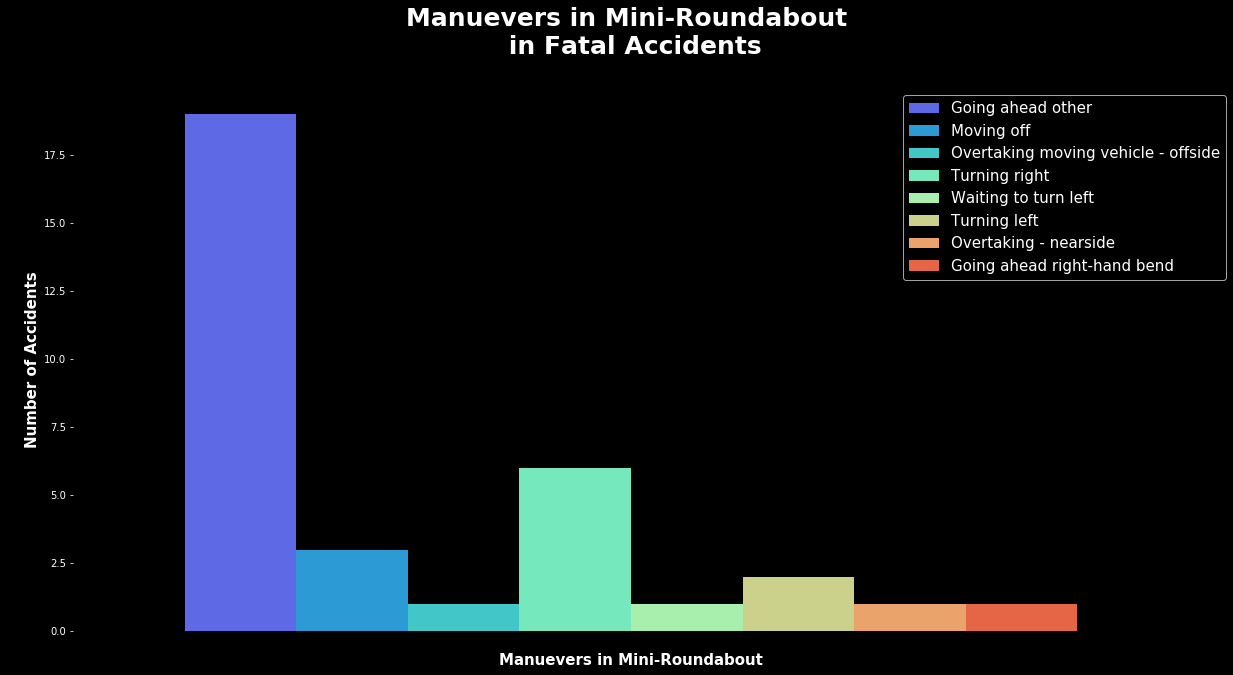

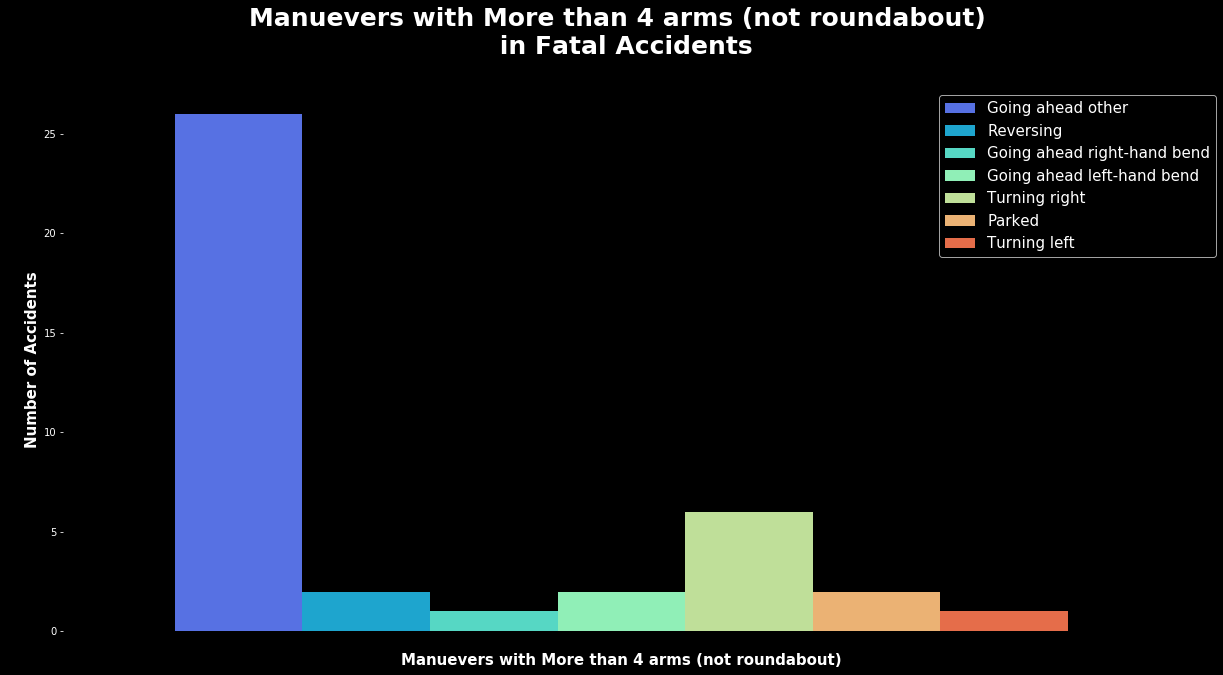

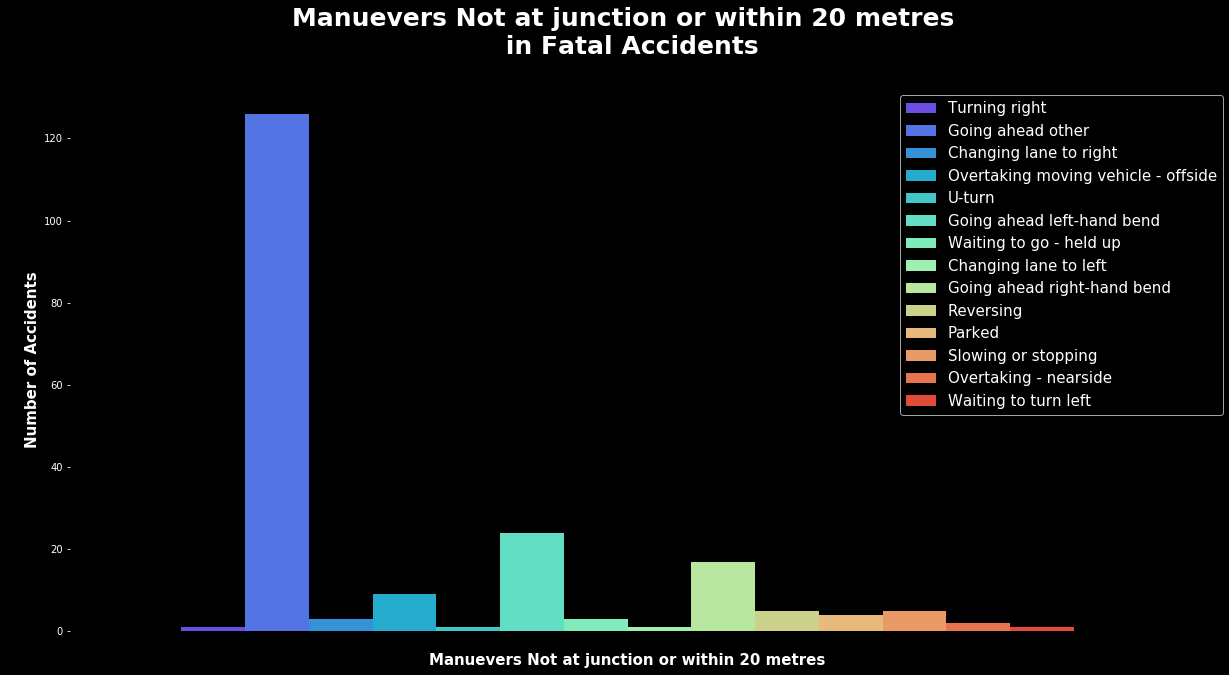

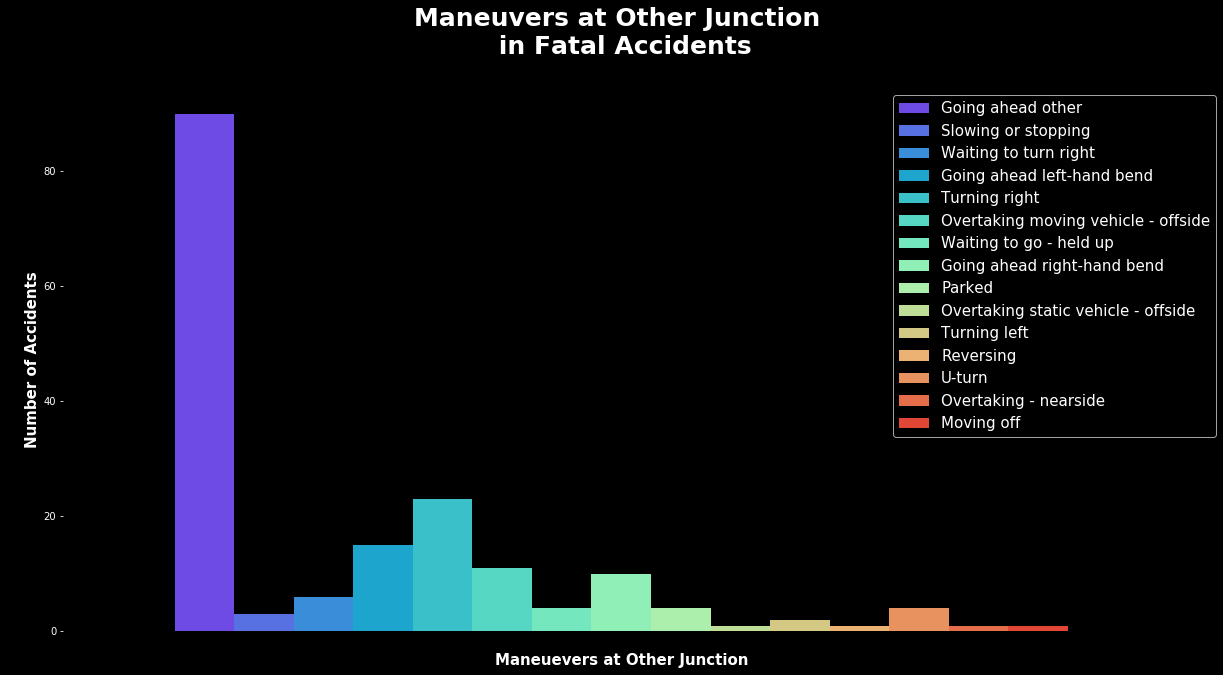

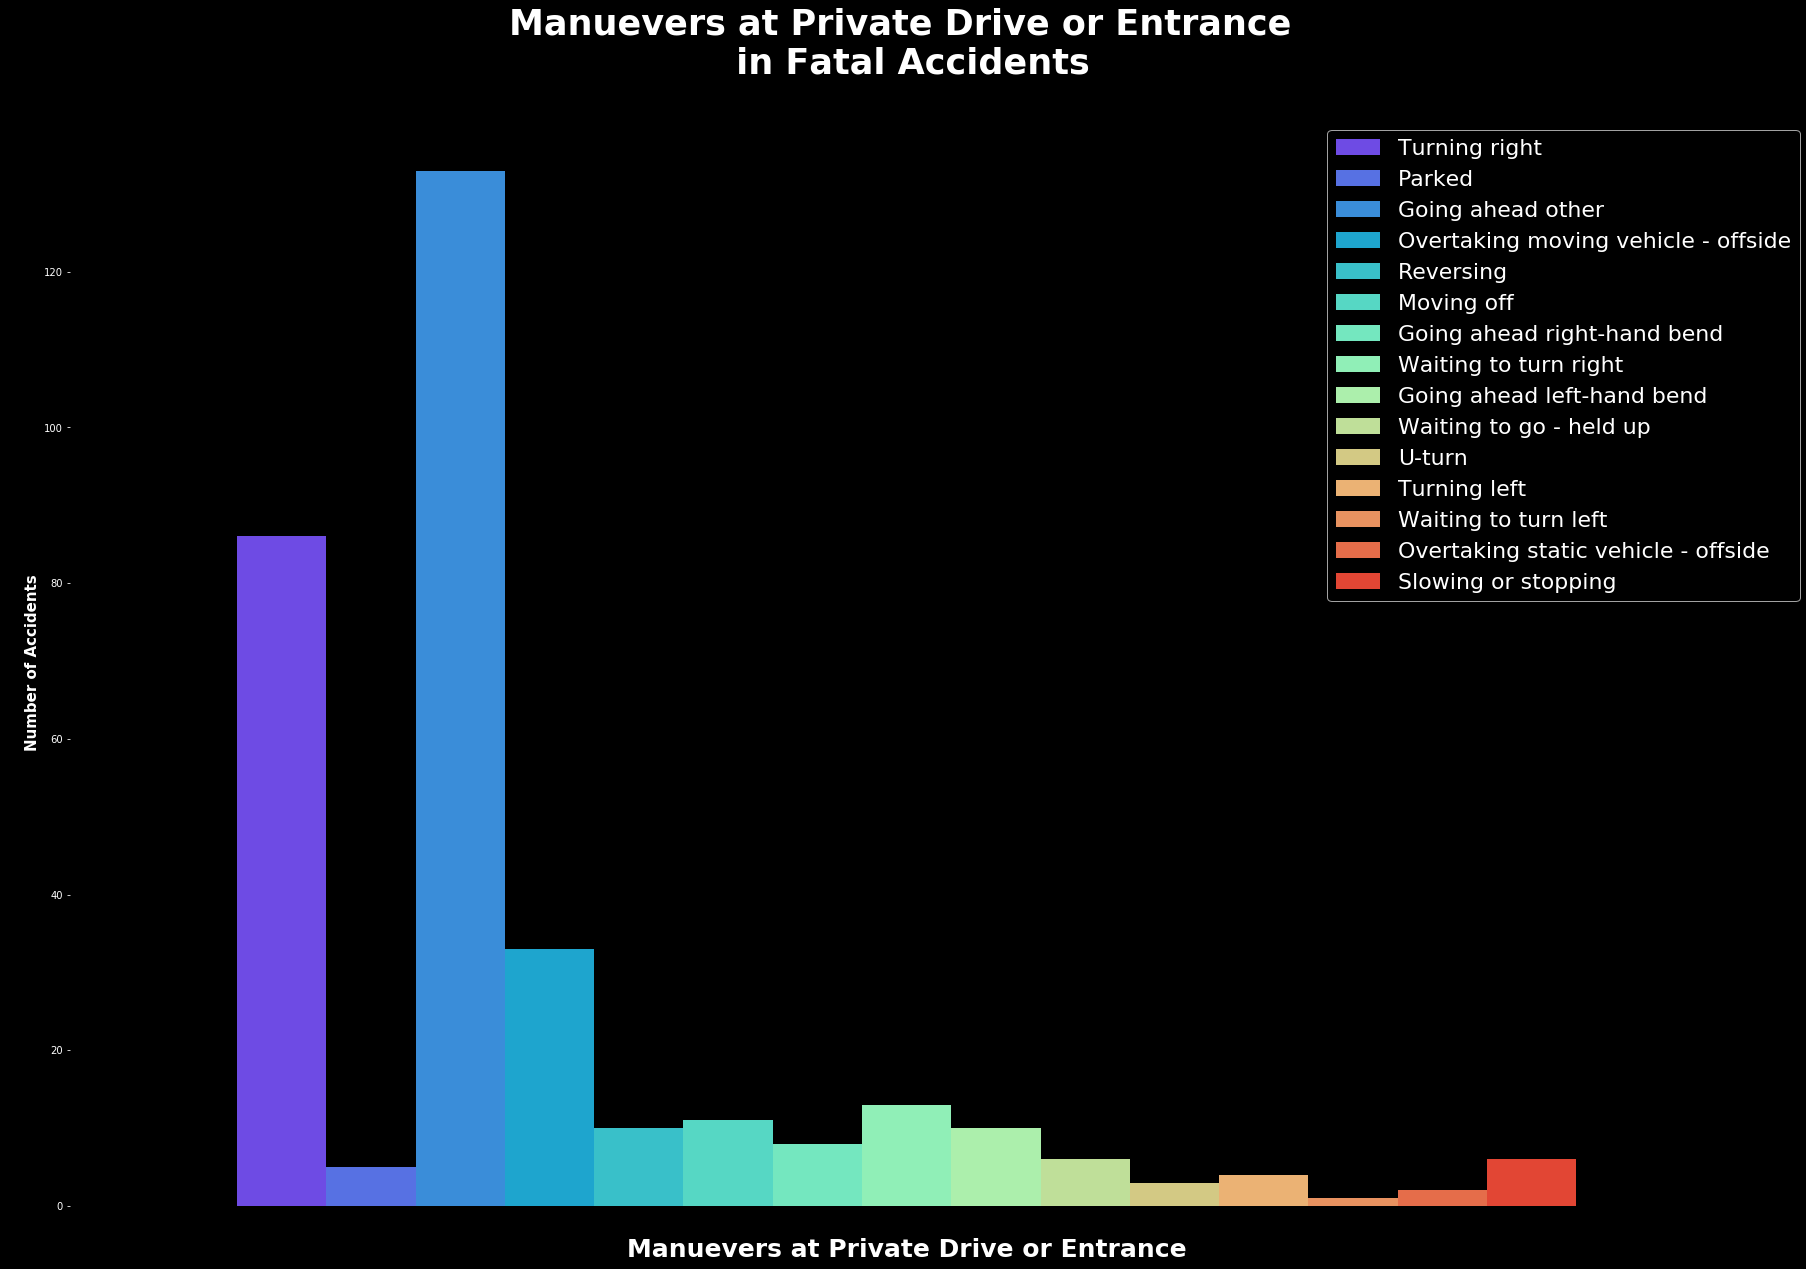

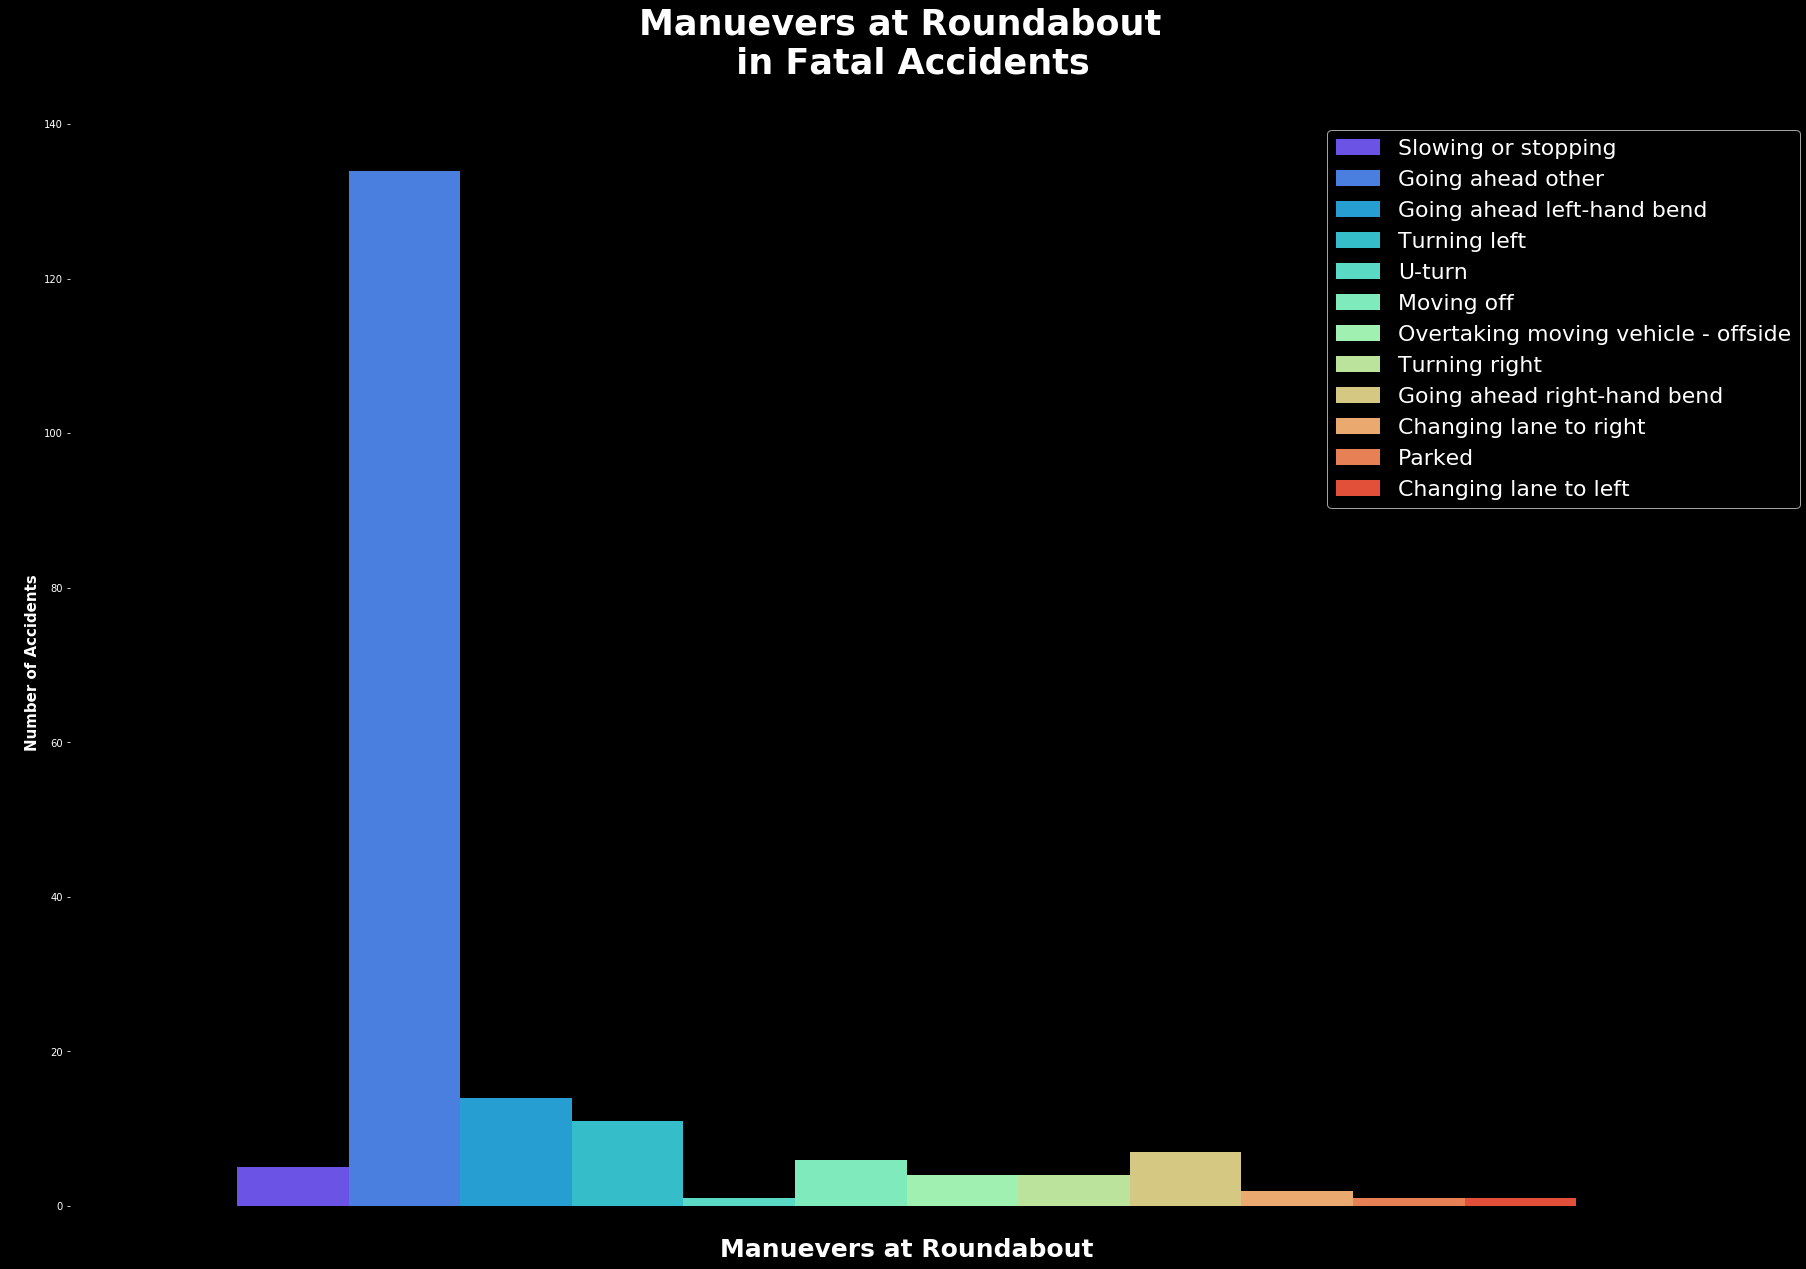

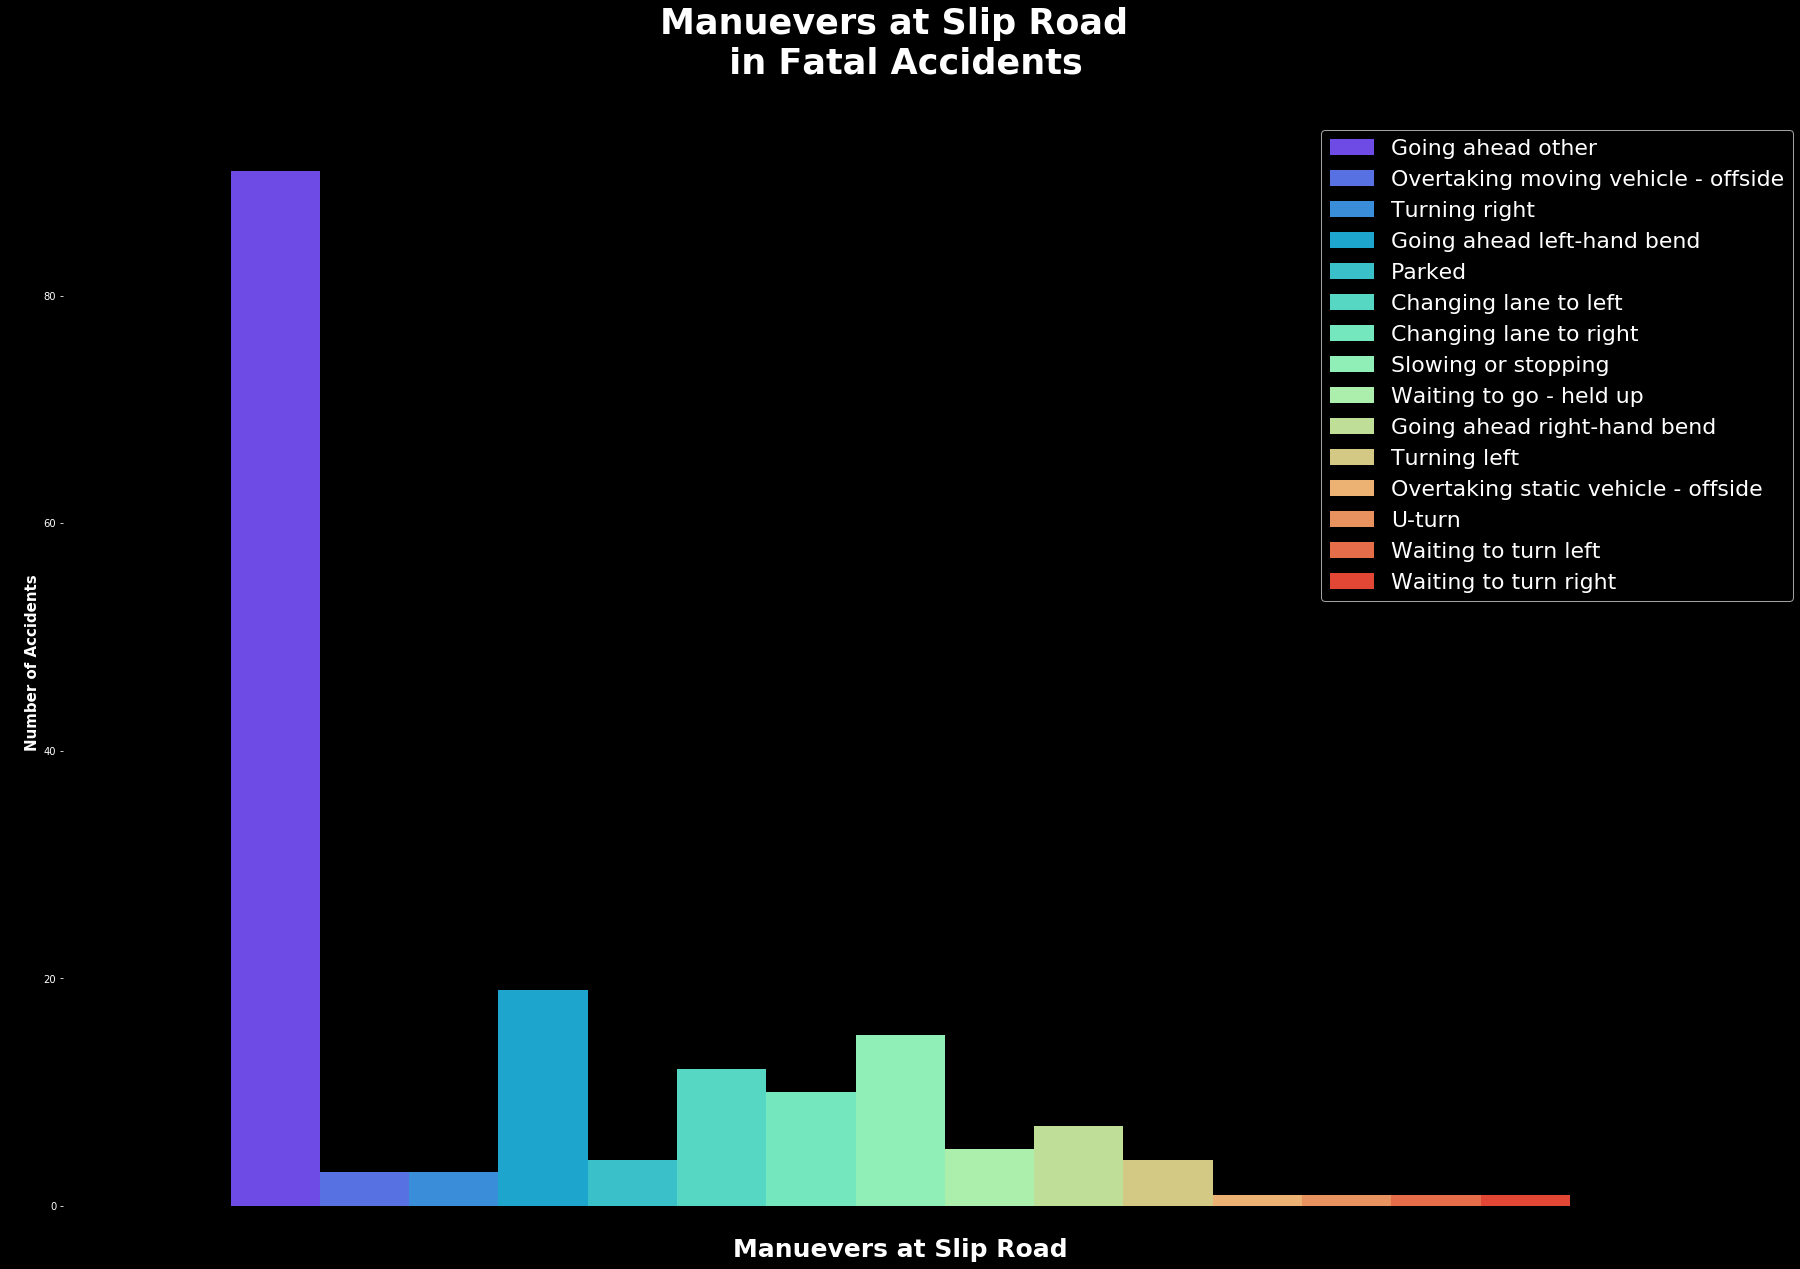

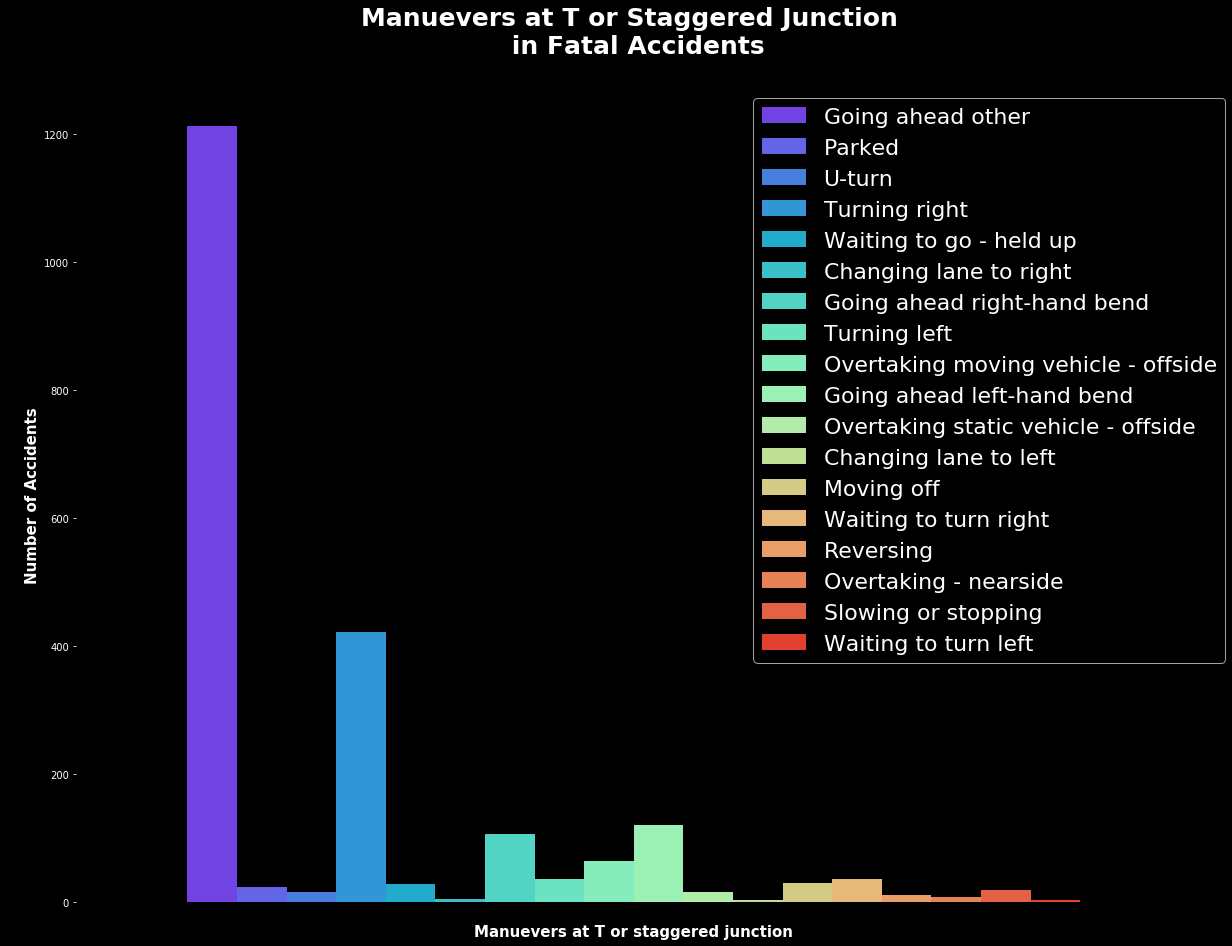

In [81]:
#Manuevers in Mini-Roundabout
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=miniround)

plt.style.use('dark_background')
plt.title("Manuevers in Mini-Roundabout \n in Fatal Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers in Mini-Roundabout", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Manuevers with More than 4 arms (not roundabout)
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=more4arms)

plt.style.use('dark_background')
plt.title("Manuevers with More than 4 arms (not roundabout) \n in Fatal Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers with More than 4 arms (not roundabout)", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#Manuevers Not at junction or within 20 metres
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=notjunction)

plt.style.use('dark_background')
plt.title("Manuevers Not at junction or within 20 metres \n in Fatal Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers Not at junction or within 20 metres", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Maneuevers at Other Junction
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=otherjunction)
plt.style.use('dark_background')
plt.title("Maneuvers at Other Junction \n in Fatal Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManeuevers at Other Junction", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Manuevers at Private drive or entrance
plt.figure(figsize=(30,20))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=private)

plt.style.use('dark_background')
plt.title("Manuevers at Private Drive or Entrance \n in Fatal Accidents\n",
          fontsize=35, fontweight="bold")
plt.xlabel("\nManuevers at Private Drive or Entrance", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#Roundabout
plt.figure(figsize=(30,20))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=roundabout)

plt.style.use('dark_background')
plt.title("Manuevers at Roundabout \n in Fatal Accidents\n",fontsize=35,fontweight="bold")
plt.xlabel("\nManuevers at Roundabout", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Slip road
plt.figure(figsize=(30,20))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=sliproad )

plt.style.use('dark_background')
plt.title("Manuevers at Slip Road \n in Fatal Accidents\n",fontsize=35,fontweight="bold")
plt.xlabel("\nManuevers at Slip Road", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#T or staggered junction
tstaggered = fatal[(fatal['junction_detail']=='T or staggered junction')]
plt.figure(figsize=(20,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="rainbow", data=tstaggered)

plt.style.use('dark_background')
plt.title("Manuevers at T or Staggered Junction \n in Fatal Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers at T or staggered junction", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

### Junction Details vs 1st Point of Impact

I decided to break these down more because when combined the graphs were harder to read. I decided to use the 1st points of impact as the variable for separation. I did this because I wanted to look at the junction detals as the counted variable in the legend.

For all of the graphs below, you will notice that when looking at fatal accidents, the junction detail that caused the most fatal accidents in comparison to points of impact were T or staggered junctions. Also, the majority of the fatal accidents were from front impacts. 

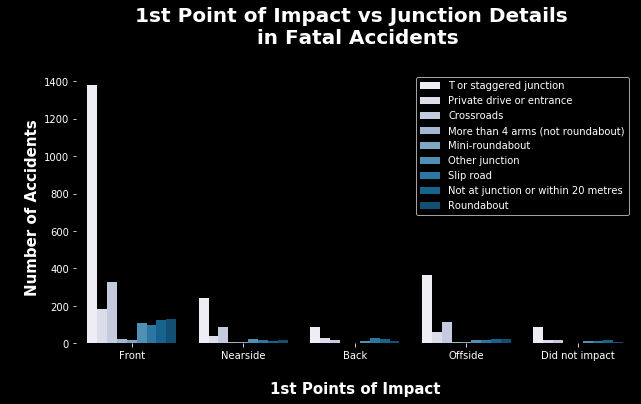

In [46]:
#x1st_point_of_impact vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="PuBu", data=fatal)

plt.style.use('dark_background')
plt.title("1st Point of Impact vs Junction Details \n in Fatal Accidents\n",
          fontsize=20, fontweight="bold")

plt.xlabel("\n1st Points of Impact", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [83]:
#setup grouping for impact points
front = fatal[(fatal['x1st_point_of_impact']=='Front')]
nearside = fatal[(fatal['x1st_point_of_impact']=='Nearside')]
back = fatal[(fatal['x1st_point_of_impact']=='Back')]
offside = fatal[(fatal['x1st_point_of_impact']=='Offside')]
noimpact = fatal[(fatal['x1st_point_of_impact']=='Did not impact')]

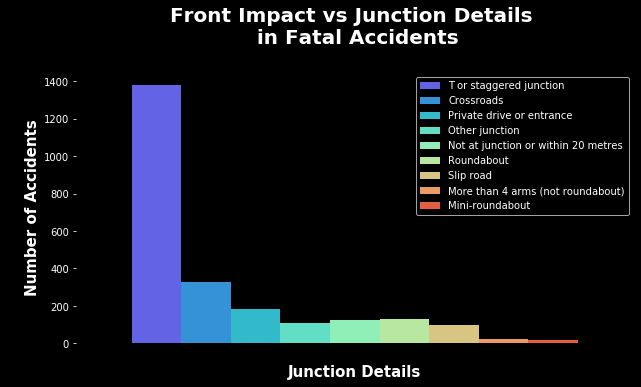

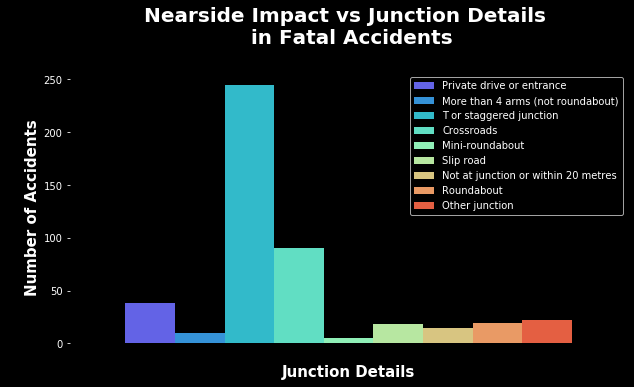

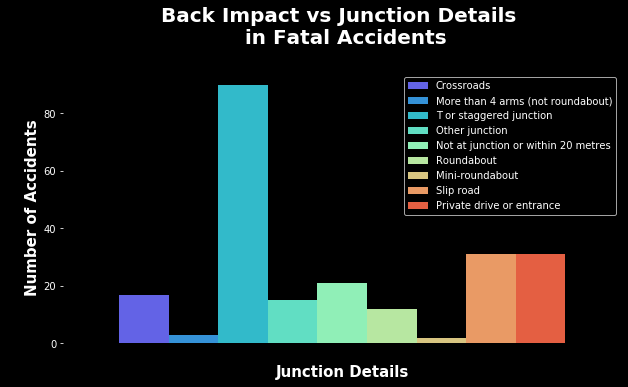

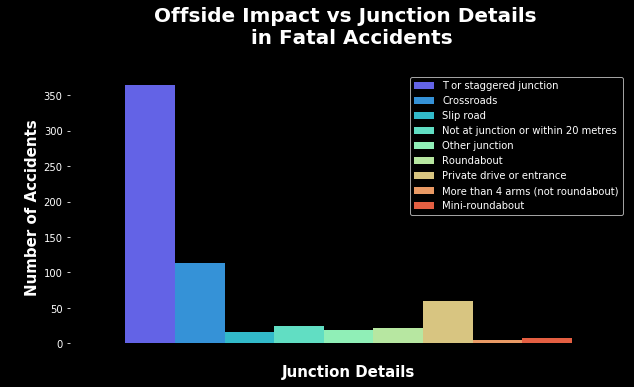

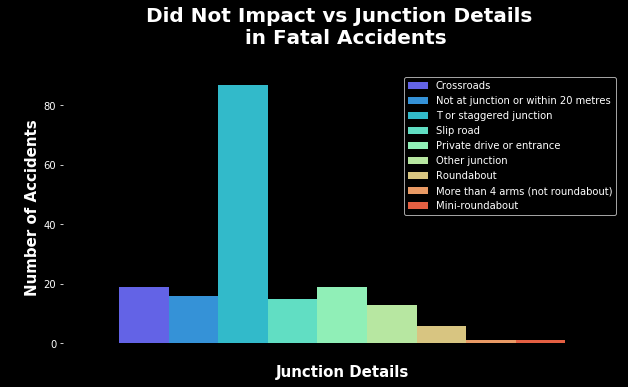

In [84]:
#front x1st_point_of_impact vs junction details
plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=front)

plt.style.use('dark_background')
plt.title("Front Impact vs Junction Details \n in Fatal Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#nearside x1st_point_of_impact vs junction details
plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=nearside)

plt.style.use('dark_background')
plt.title("Nearside Impact vs Junction Details \n in Fatal Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#back x1st_point_of_impact vs junction details
plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=back)

plt.style.use('dark_background')
plt.title("Back Impact vs Junction Details \n in Fatal Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#offside x1st_point_of_impact vs junction details
plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=offside)

plt.style.use('dark_background')
plt.title("Offside Impact vs Junction Details \n in Fatal Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#noimpact x1st_point_of_impact vs junction details
plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=noimpact)

plt.style.use('dark_background')
plt.title("Did Not Impact vs Junction Details \n in Fatal Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

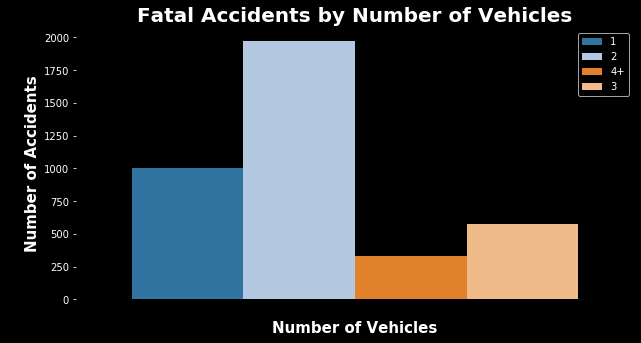

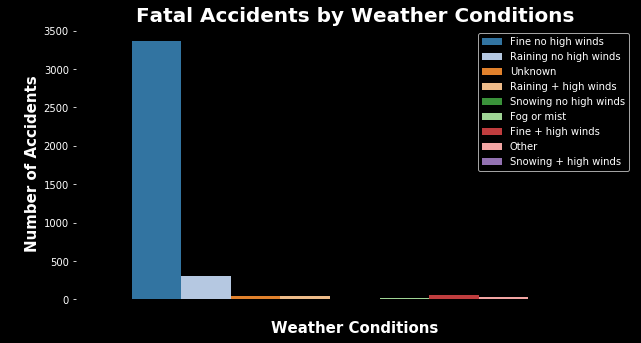

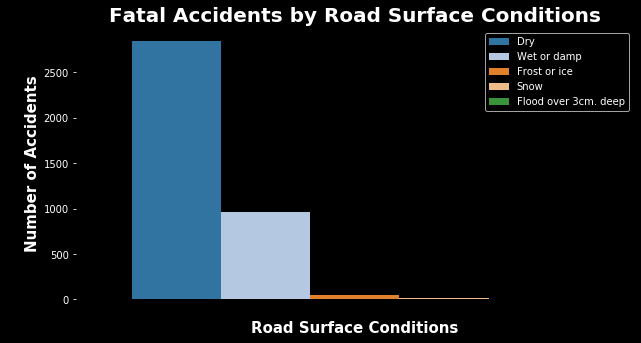

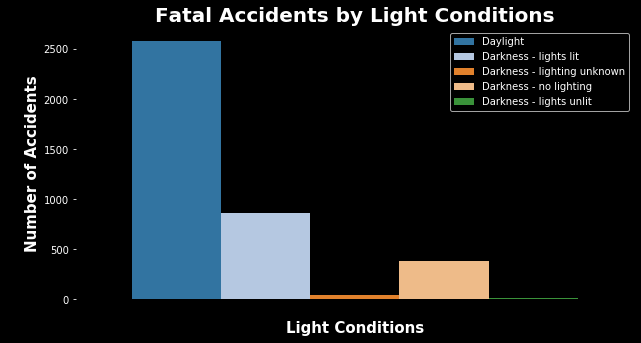

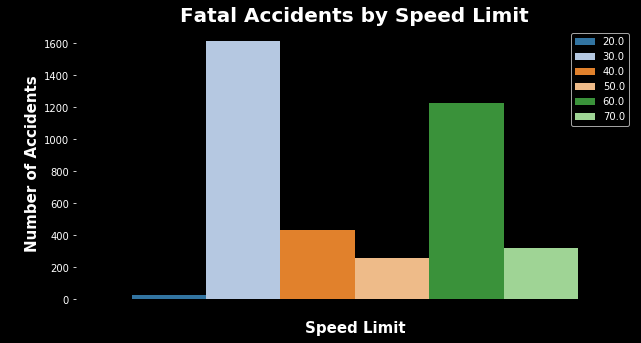

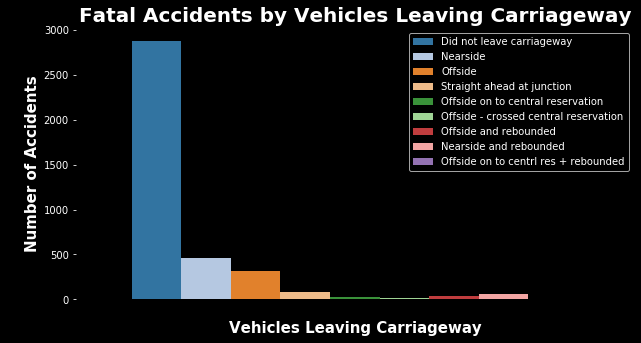

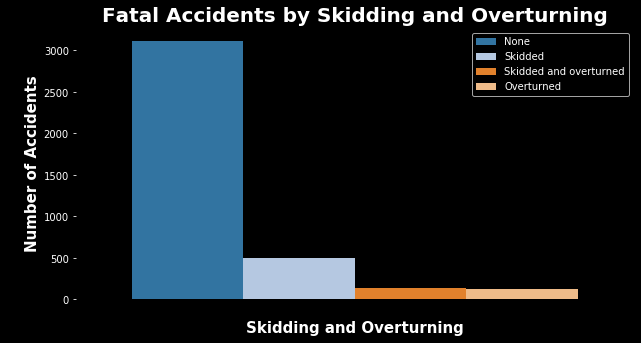

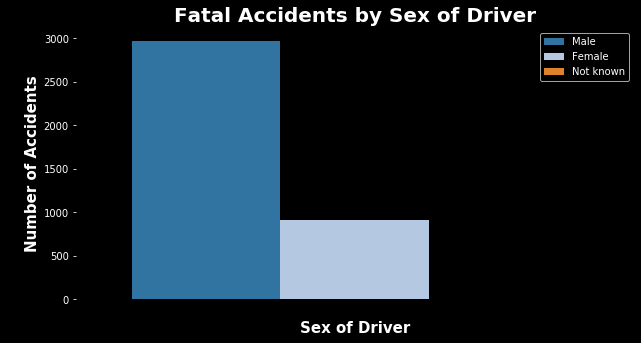

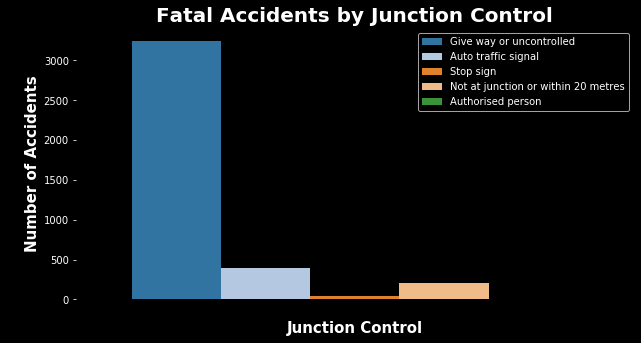

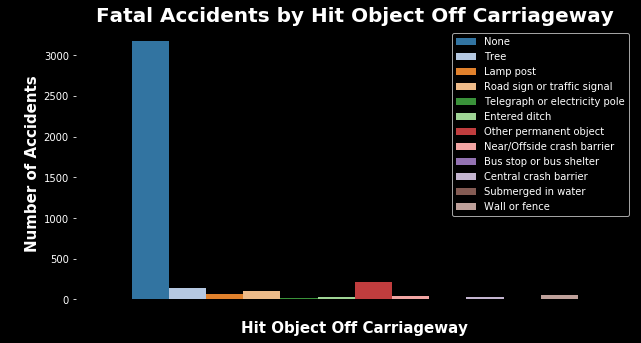

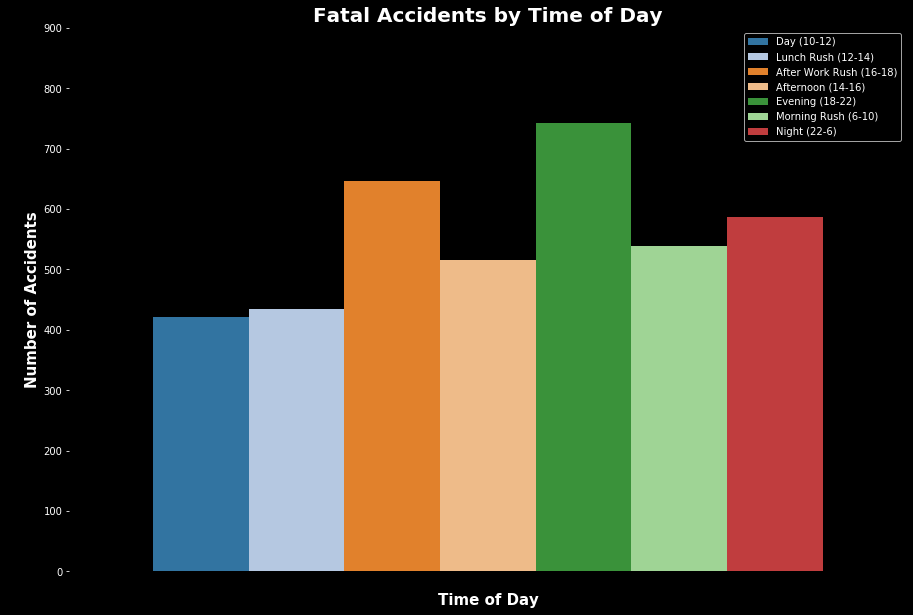

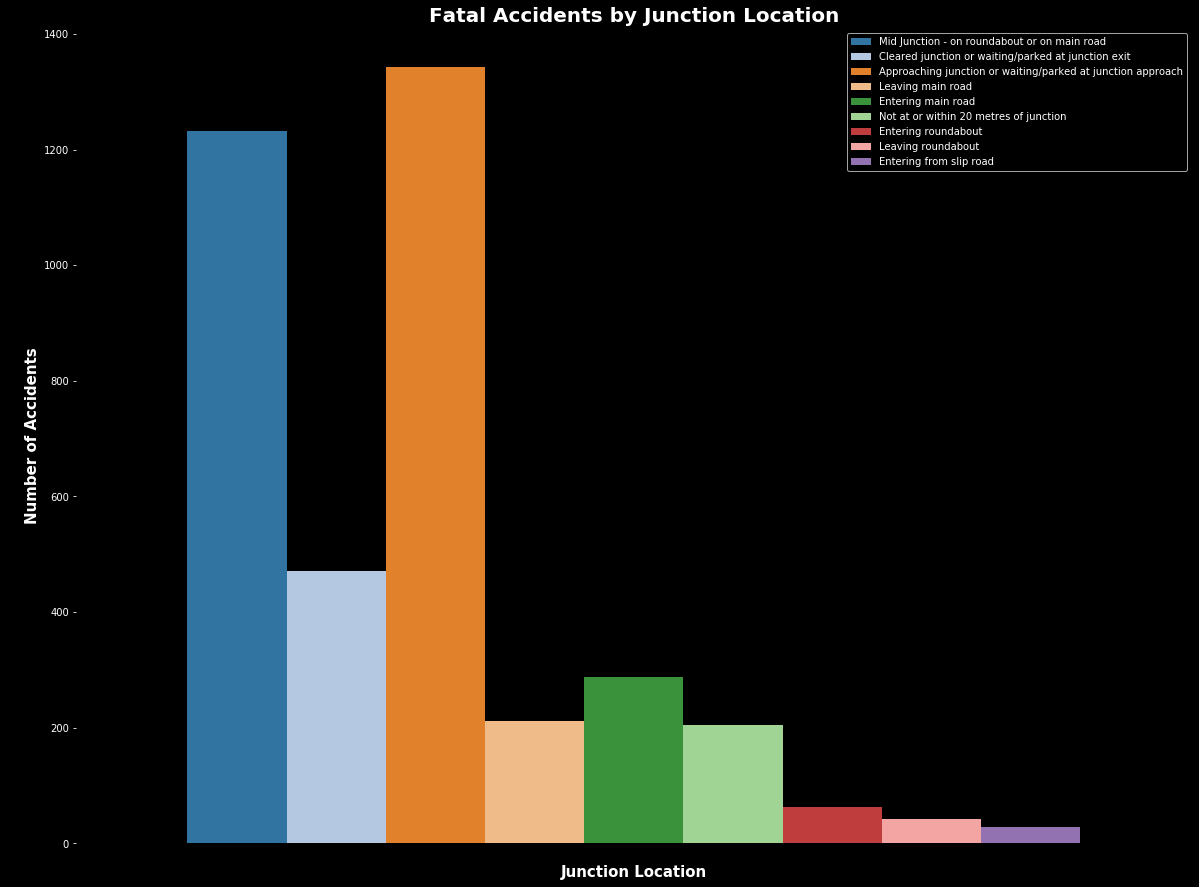

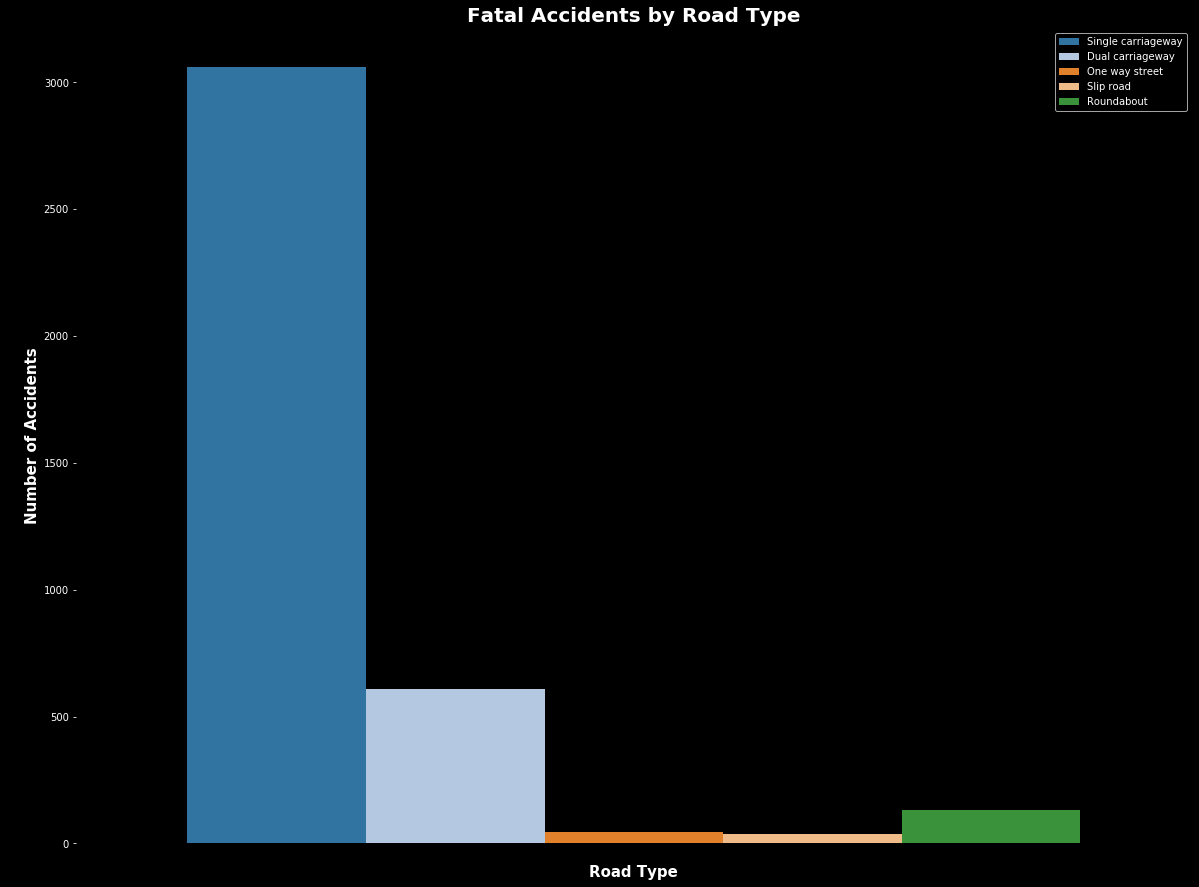

In [88]:
#number of vehicles vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="number_of_vehicles",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Number of Vehicles",
          fontsize=20, fontweight="bold")

plt.xlabel("\nNumber of Vehicles", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#weather_conditions vs accident severity
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="weather_conditions",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Weather Conditions",
          fontsize=20, fontweight="bold")

plt.xlabel("\nWeather Conditions", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

#road_surface_conditions vs accident severity
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="road_surface_conditions",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Road Surface Conditions",
          fontsize=20, fontweight="bold")

plt.xlabel("\nRoad Surface Conditions", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#light_conditions vs accident severity
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="light_conditions",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Light Conditions",
          fontsize=20, fontweight="bold")

plt.xlabel("\nLight Conditions", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#speed_limit
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="speed_limit",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Speed Limit",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSpeed Limit", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#Vehicles Leaving Carriageway
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="vehicle_leaving_carriageway",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Vehicles Leaving Carriageway",
          fontsize=20, fontweight="bold")

plt.xlabel("\nVehicles Leaving Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#skidding_and_overturning
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="skidding_and_overturning",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Skidding and Overturning",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSkidding and Overturning", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#sex_of_driver
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="sex_of_driver",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Sex of Driver",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSex of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#junction_control
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="junction_control",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Junction Control",
          fontsize=20, fontweight="bold")

plt.xlabel("\nJunction Control", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


#hit_object_off_carriageway
plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="hit_object_off_carriageway",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Hit Object Off Carriageway",
          fontsize=20, fontweight="bold")

plt.xlabel("\nHit Object Off Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#time_of_day
plt.figure(figsize=(15,10))
sns.countplot("accident_severity", hue="time_of_day",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Time of Day",
          fontsize=20, fontweight="bold")

plt.xlabel("\nTime of Day", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.yticks(np.arange(0, 1000, 100)) 
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#junction_location
plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="junction_location",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Junction Location",
          fontsize=20, fontweight="bold")

plt.xlabel("\nJunction Location", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



#road_type
plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="road_type",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Road Type",
          fontsize=20, fontweight="bold")

plt.xlabel("\nRoad Type", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


### Serious Accidents Analysis

In [92]:
print(serious.groupby(['x1st_point_of_impact'])['junction_detail'].count())
print('\n')
print(serious.groupby(['junction_detail'])['x1st_point_of_impact'].count())

x1st_point_of_impact
Back               5388
Did not impact     2626
Front             35089
Nearside           9755
Offside           11589
Name: junction_detail, dtype: int64


junction_detail
Crossroads                             10559
Mini-roundabout                          946
More than 4 arms (not roundabout)        931
Not at junction or within 20 metres     1443
Other junction                          2309
Private drive or entrance               4356
Roundabout                              6646
Slip road                               1571
T or staggered junction                35686
Name: x1st_point_of_impact, dtype: int64


In [93]:
print(fatal.groupby(['x1st_point_of_impact'])['junction_detail'].count())
print('\n')
print(fatal.groupby(['junction_detail'])['x1st_point_of_impact'].count())

x1st_point_of_impact
Back               222
Did not impact     177
Front             2390
Nearside           462
Offside            633
Name: junction_detail, dtype: int64


junction_detail
Crossroads                              565
Mini-roundabout                          34
More than 4 arms (not roundabout)        40
Not at junction or within 20 metres     202
Other junction                          176
Private drive or entrance               331
Roundabout                              190
Slip road                               177
T or staggered junction                2169
Name: x1st_point_of_impact, dtype: int64


In [94]:
print(df.groupby(['x1st_point_of_impact'])['junction_detail'].count())
print('\n')
print(df.groupby(['junction_detail'])['x1st_point_of_impact'].count())

x1st_point_of_impact
Back              104433
Did not impact     15595
Front             275785
Nearside           78489
Offside            86833
Name: junction_detail, dtype: int64


junction_detail
Crossroads                              95356
Mini-roundabout                         11140
More than 4 arms (not roundabout)        9282
Not at junction or within 20 metres      9366
Other junction                          19440
Private drive or entrance               31295
Roundabout                              84344
Slip road                               16239
T or staggered junction                284673
Name: x1st_point_of_impact, dtype: int64


In [90]:
serious.groupby(['junction_detail'])['x1st_point_of_impact'].count()

junction_detail
Crossroads                             10559
Mini-roundabout                          946
More than 4 arms (not roundabout)        931
Not at junction or within 20 metres     1443
Other junction                          2309
Private drive or entrance               4356
Roundabout                              6646
Slip road                               1571
T or staggered junction                35686
Name: x1st_point_of_impact, dtype: int64

T or staggered junction is causing most serious accidents along with front collisions. This is very similar to fatal accidents.

In [91]:
df.groupby(['junction_detail'])['x1st_point_of_impact'].count()

junction_detail
Crossroads                              95356
Mini-roundabout                         11140
More than 4 arms (not roundabout)        9282
Not at junction or within 20 metres      9366
Other junction                          19440
Private drive or entrance               31295
Roundabout                              84344
Slip road                               16239
T or staggered junction                284673
Name: x1st_point_of_impact, dtype: int64

In [56]:
#create junction_detail groupings
s_miniround = serious[(serious['junction_detail']=='Mini-roundabout')]
s_more4arms = serious[(serious['junction_detail']=='More than 4 arms (not roundabout)')]
s_notjunction = serious[(serious['junction_detail']=='Not at junction or within 20 metres')]
s_otherjunction = serious[(serious['junction_detail']=='Other junction')]
s_private = serious[(serious['junction_detail']=='Private drive or entrance')]
s_roundabout = serious[(serious['junction_detail']=='Roundabout')]
s_sliproad = serious[(serious['junction_detail']=='Slip road')]
s_tstaggered = serious[(serious['junction_detail']=='T or staggered junction')]

In [69]:
#setup groupings for impact points
s_front = serious[(serious['x1st_point_of_impact']=='Front')]
s_nearside = serious[(serious['x1st_point_of_impact']=='Nearside')]
s_back = serious[(serious['x1st_point_of_impact']=='Back')]
s_offside = serious[(serious['x1st_point_of_impact']=='Offside')]
s_noimpact = serious[(serious['x1st_point_of_impact']=='Did not impact')]

### Manuevers in Serious Accidents

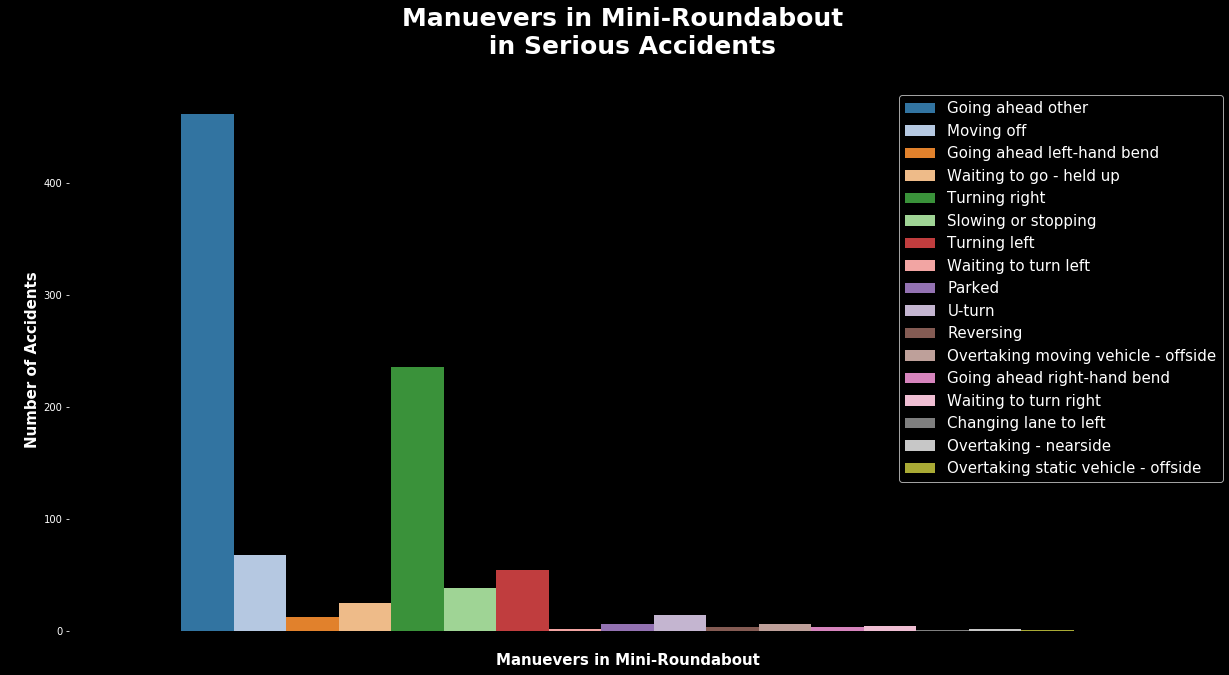

In [74]:
#Manuevers in Mini-Roundabout
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_miniround)

plt.style.use('dark_background')
plt.title("Manuevers in Mini-Roundabout \n in Serious Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers in Mini-Roundabout", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

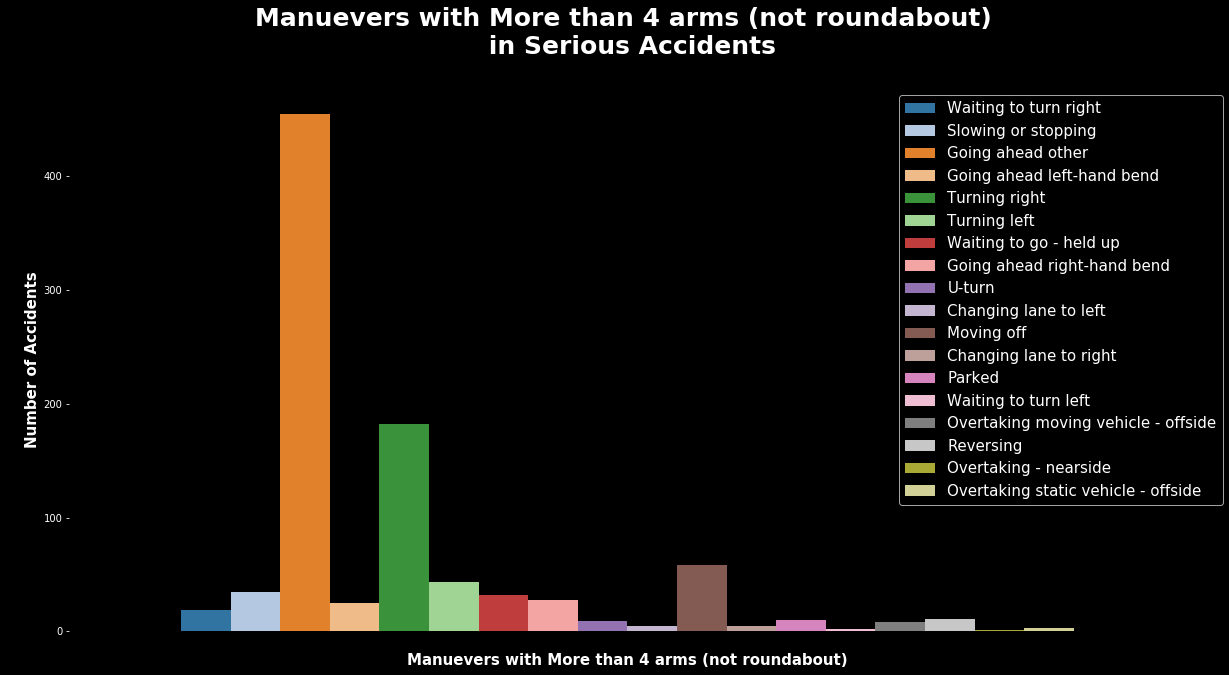

In [73]:
#Manuevers with More than 4 arms (not roundabout)
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_more4arms)

plt.style.use('dark_background')
plt.title("Manuevers with More than 4 arms (not roundabout) \n in Serious Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers with More than 4 arms (not roundabout)", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

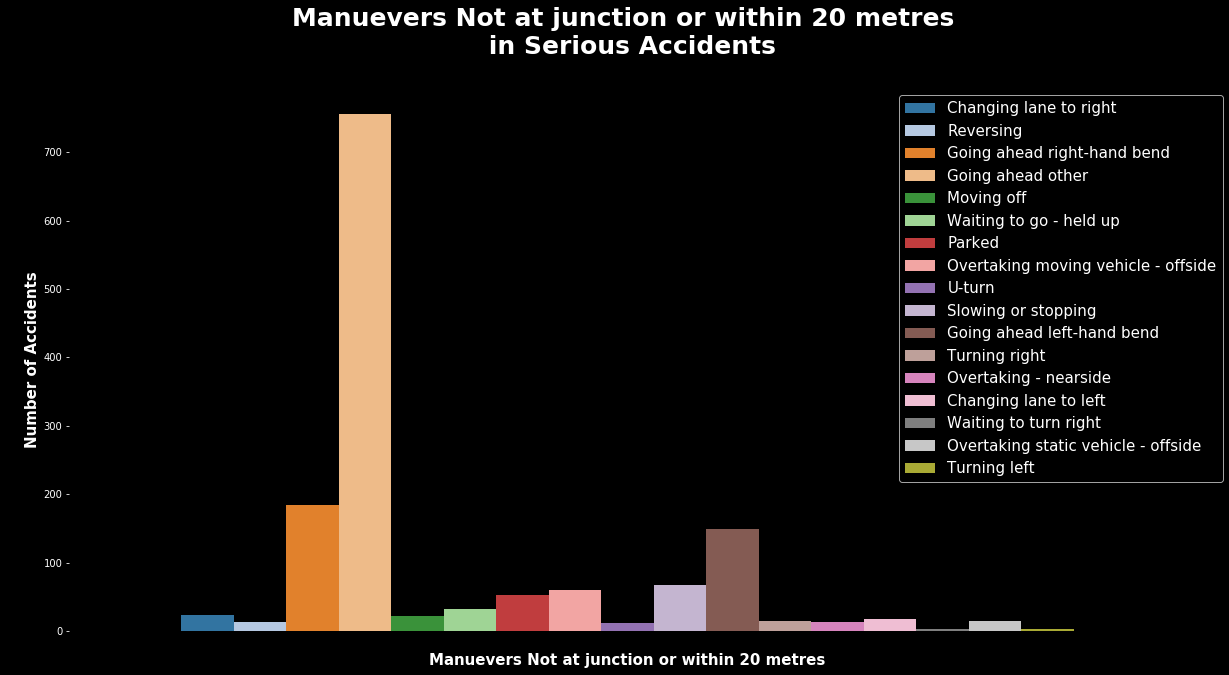

In [72]:
#Manuevers Not at junction or within 20 metres
plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_notjunction)

plt.style.use('dark_background')
plt.title("Manuevers Not at junction or within 20 metres \n in Serious Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers Not at junction or within 20 metres", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

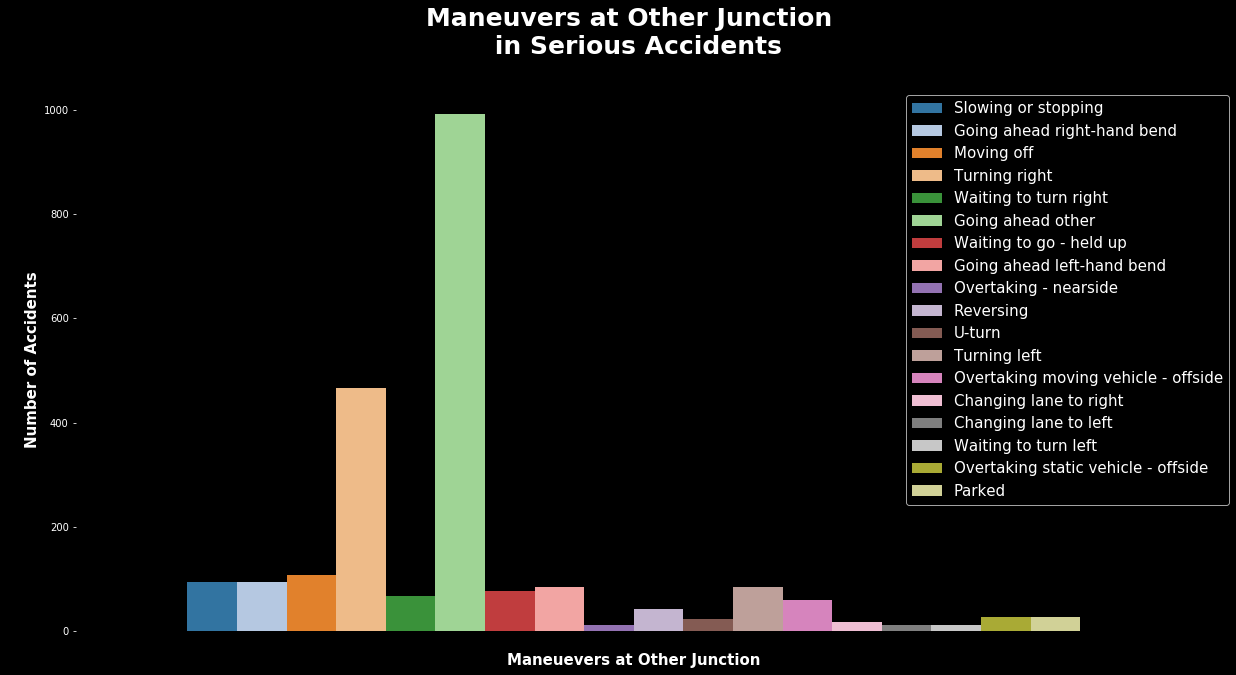

In [71]:
#Maneuevers at Other Junction

plt.figure(figsize=(20,10))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_otherjunction)
plt.style.use('dark_background')
plt.title("Maneuvers at Other Junction \n in Serious Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManeuevers at Other Junction", fontsize=15, fontweight="bold")
plt.legend(fontsize='15', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

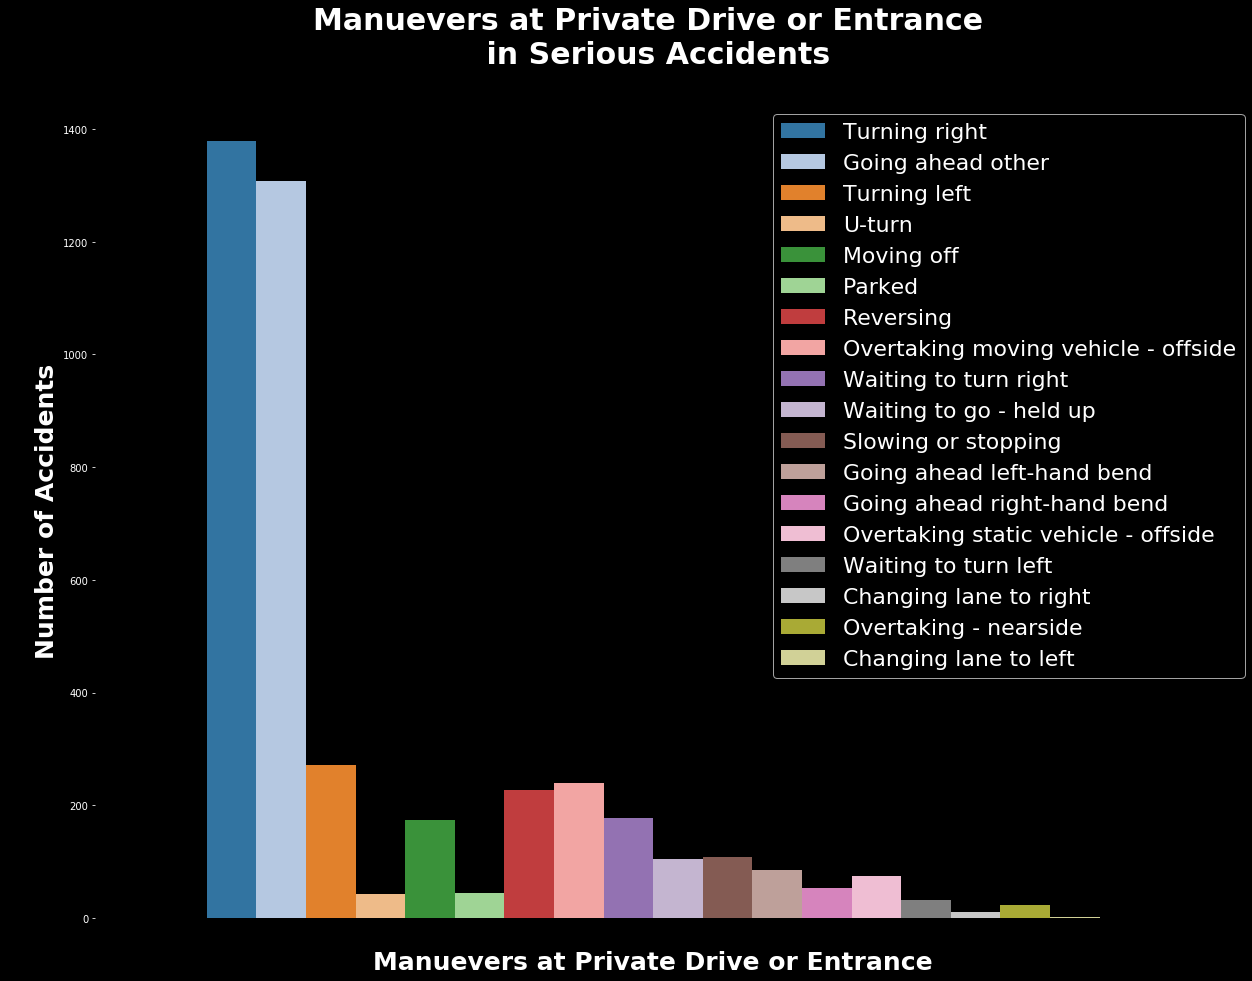

In [90]:
#Manuevers at Private drive or entrance
plt.figure(figsize=(20,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_private)

plt.style.use('dark_background')
plt.title("Manuevers at Private Drive or Entrance \n in Serious Accidents\n",
          fontsize=30, fontweight="bold")
plt.xlabel("\nManuevers at Private Drive or Entrance", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=25, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

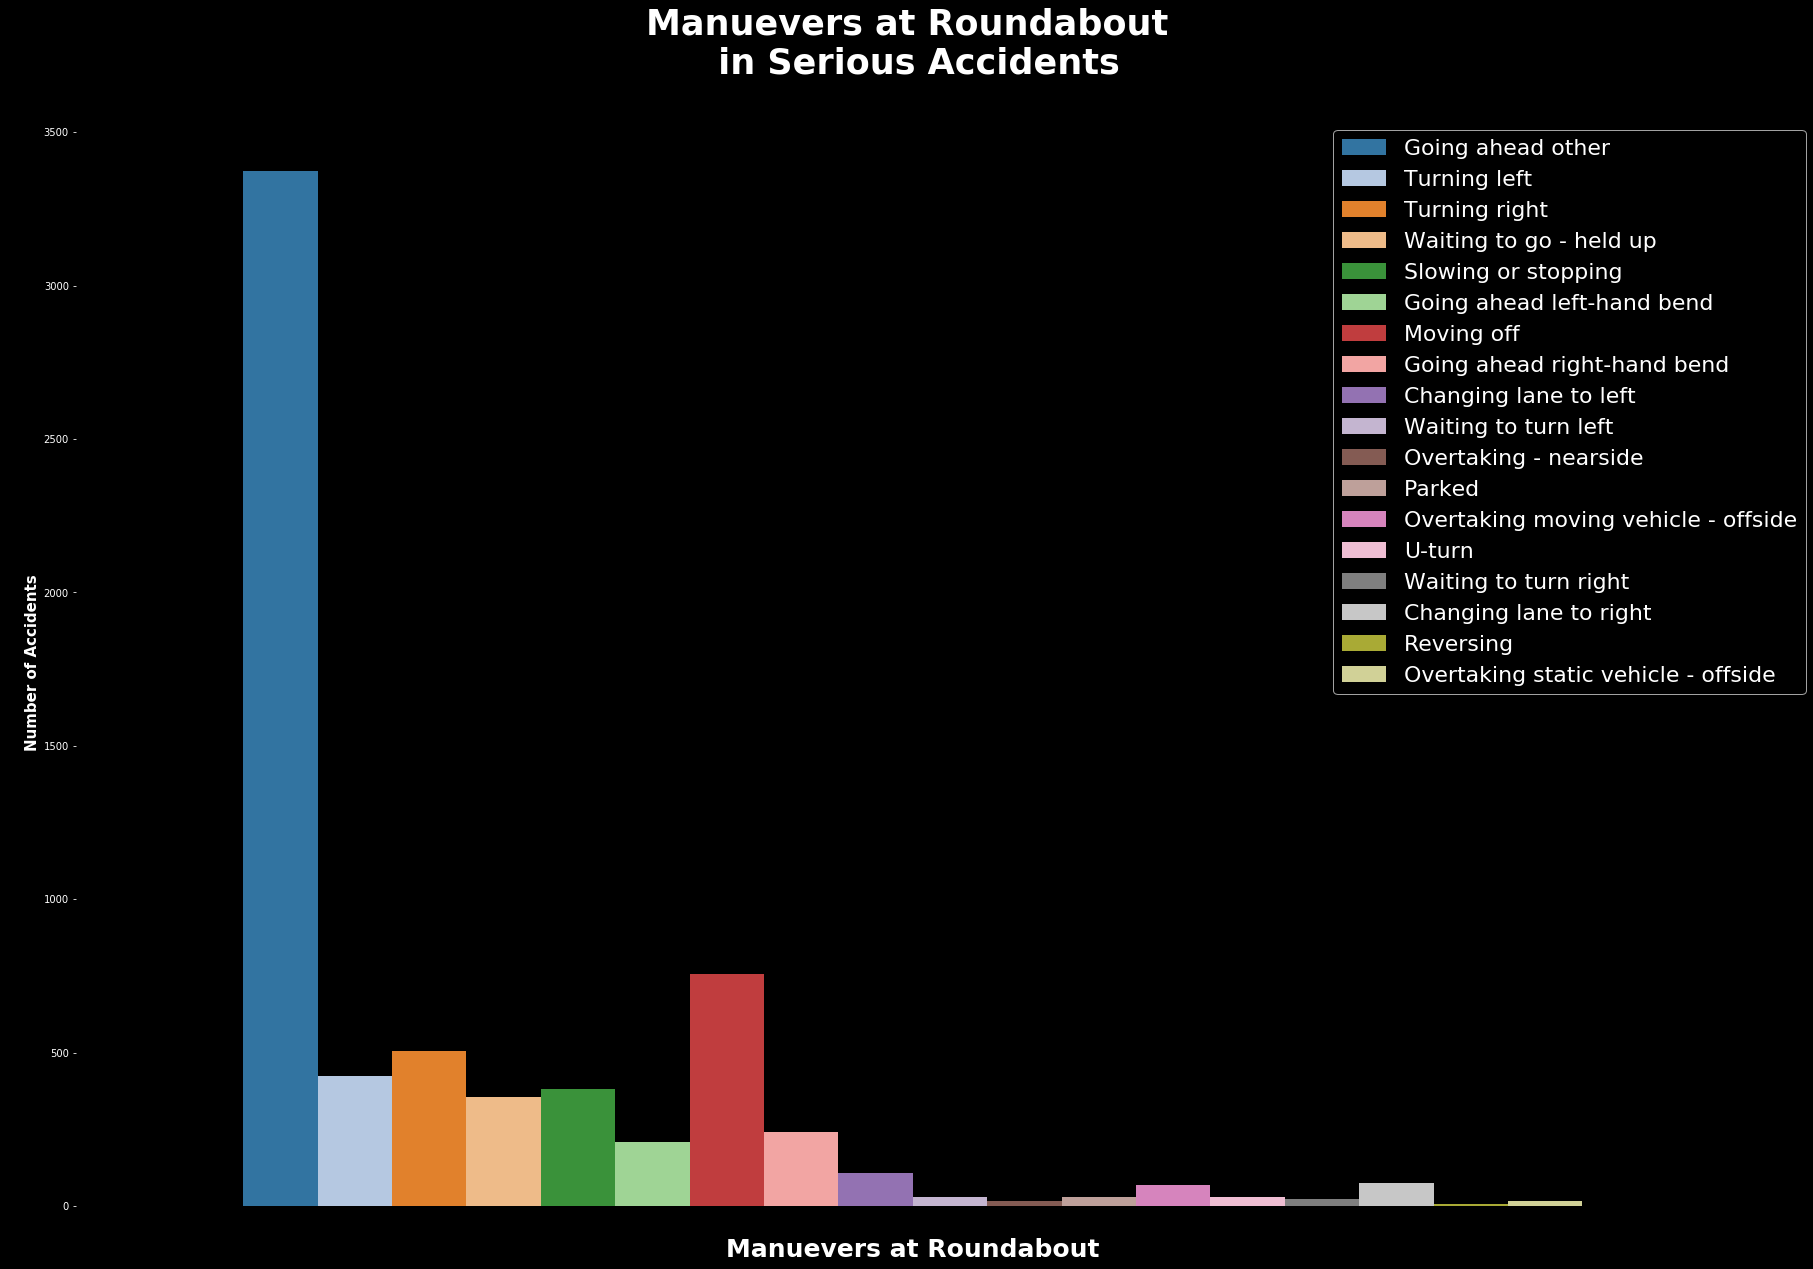

In [92]:
#Roundabout

plt.figure(figsize=(30,20))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_roundabout)

plt.style.use('dark_background')
plt.title("Manuevers at Roundabout \n in Serious Accidents\n",fontsize=35,fontweight="bold")
plt.xlabel("\nManuevers at Roundabout", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

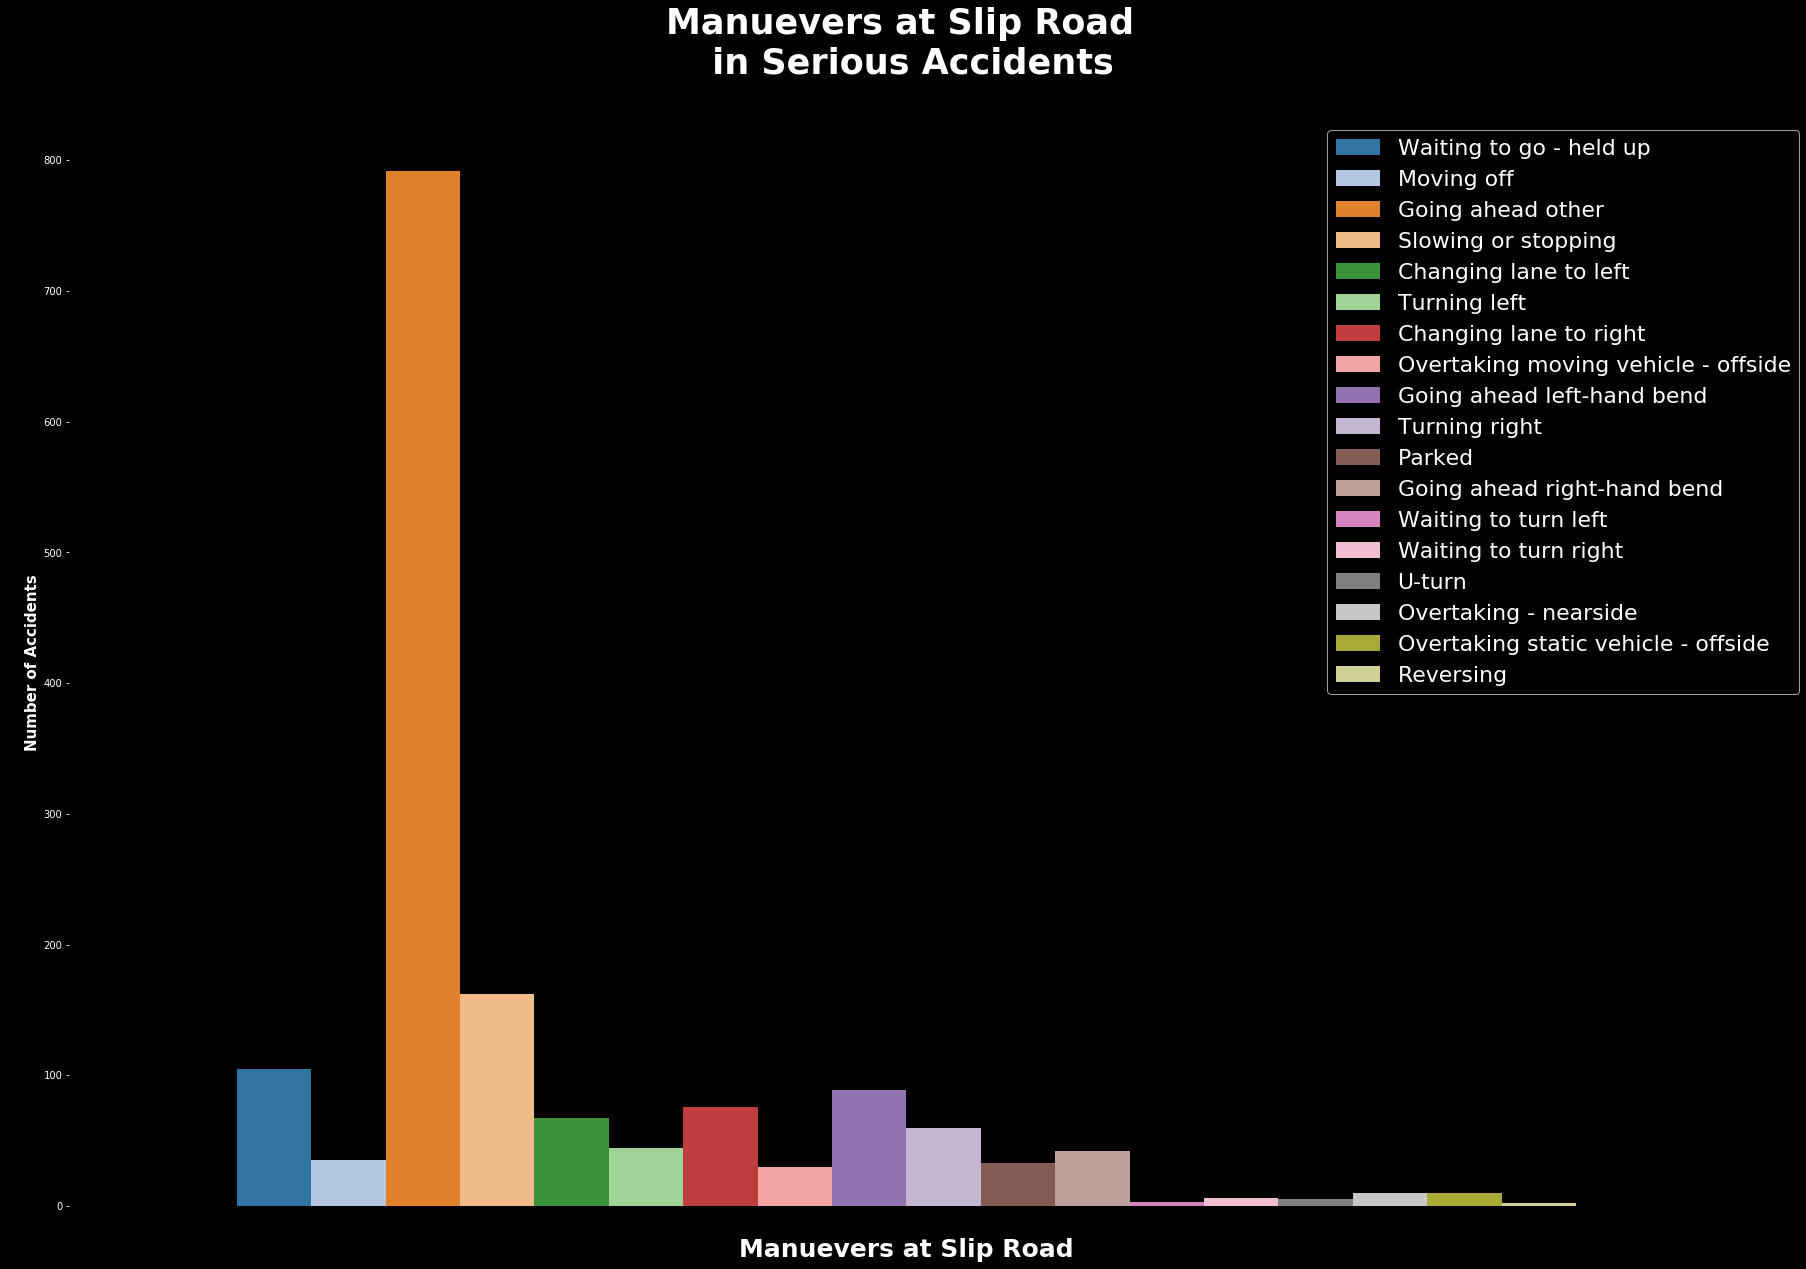

In [93]:
plt.figure(figsize=(30,20))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_sliproad )

plt.style.use('dark_background')
plt.title("Manuevers at Slip Road \n in Serious Accidents\n",fontsize=35,fontweight="bold")
plt.xlabel("\nManuevers at Slip Road", fontsize=25, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

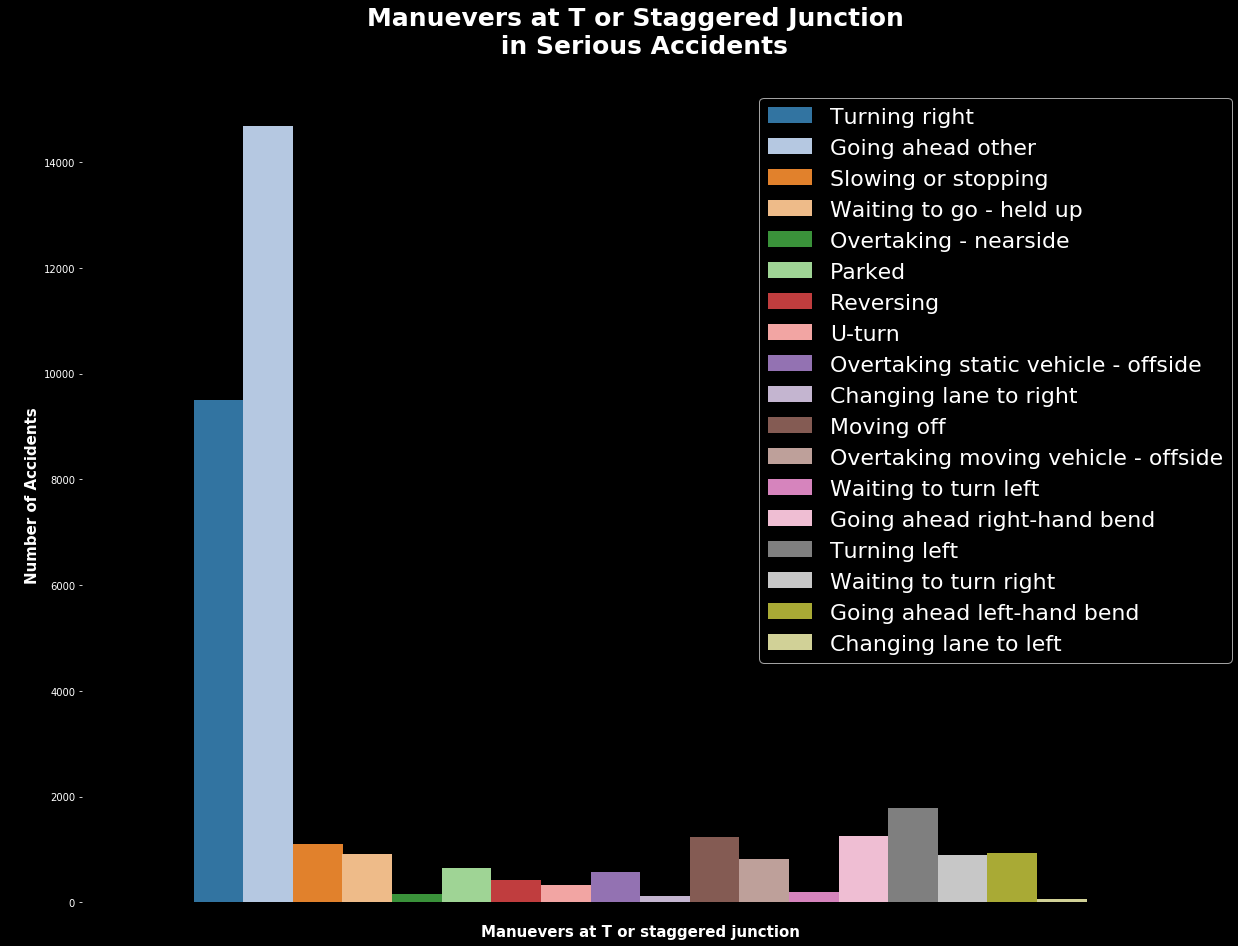

In [95]:
#tstaggered
plt.figure(figsize=(20,15))
sns.countplot("junction_detail", hue="vehicle_manoeuvre",
              palette="tab20", data=s_tstaggered)

plt.style.use('dark_background')
plt.title("Manuevers at T or Staggered Junction \n in Serious Accidents\n",fontsize=25,fontweight="bold")
plt.xlabel("\nManuevers at T or staggered junction", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend(fontsize='22', bbox_to_anchor=(1.04, 1), loc='upper right', ncol=1)
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()


### Junction Details vs 1st Point of Impact (Serious Accidents)

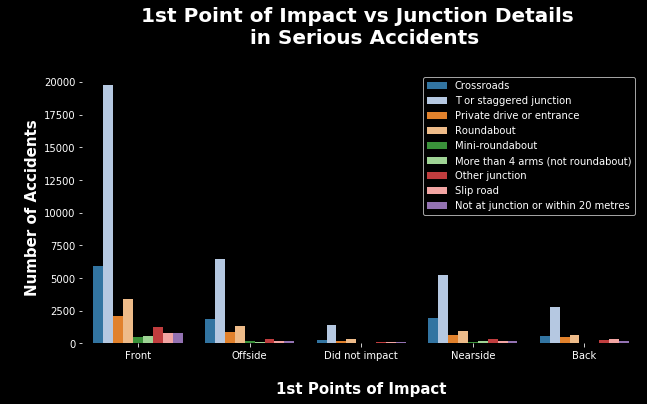

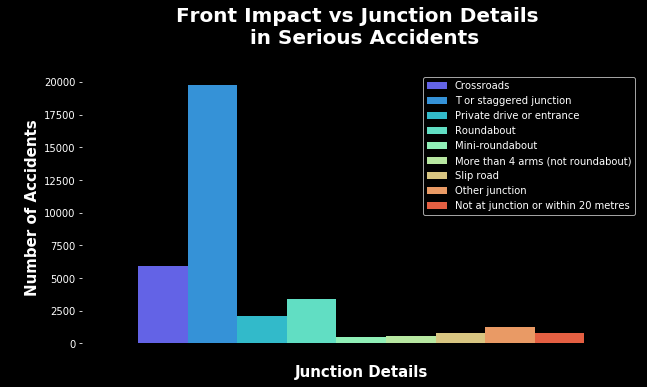

In [76]:
#x1st_point_of_impact vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("1st Point of Impact vs Junction Details \n in Serious Accidents\n",
          fontsize=20, fontweight="bold")

plt.xlabel("\n1st Points of Impact", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()



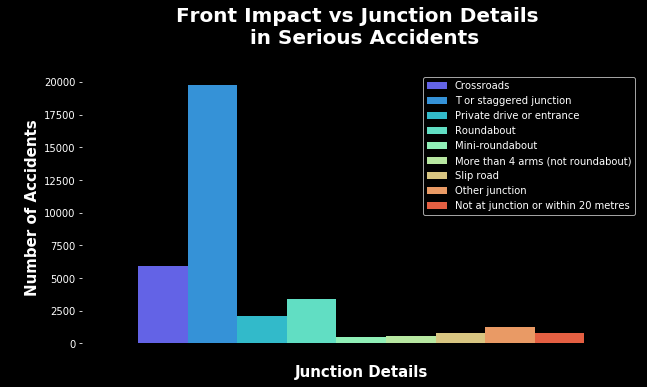

In [98]:
#front x1st_point_of_impact vs junction details

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=s_front)

plt.style.use('dark_background')
plt.title("Front Impact vs Junction Details \n in Serious Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

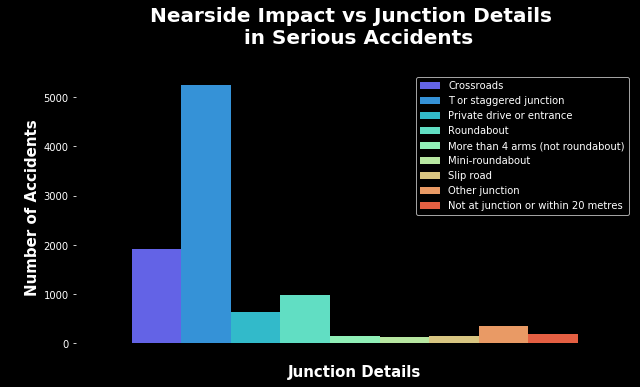

In [99]:
#nearside x1st_point_of_impact vs junction details

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=s_nearside)

plt.style.use('dark_background')
plt.title("Nearside Impact vs Junction Details \n in Serious Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

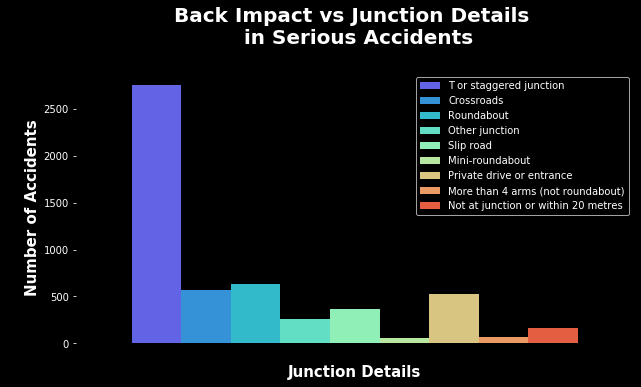

In [100]:
#back x1st_point_of_impact vs junction details

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=s_back)

plt.style.use('dark_background')
plt.title("Back Impact vs Junction Details \n in Serious Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

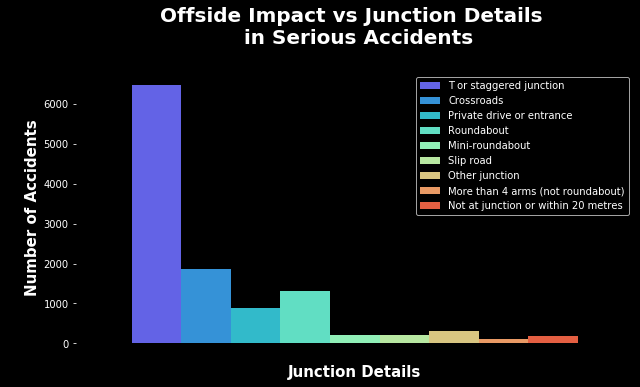

In [101]:
#offside x1st_point_of_impact vs junction details

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=s_offside)

plt.style.use('dark_background')
plt.title("Offside Impact vs Junction Details \n in Serious Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

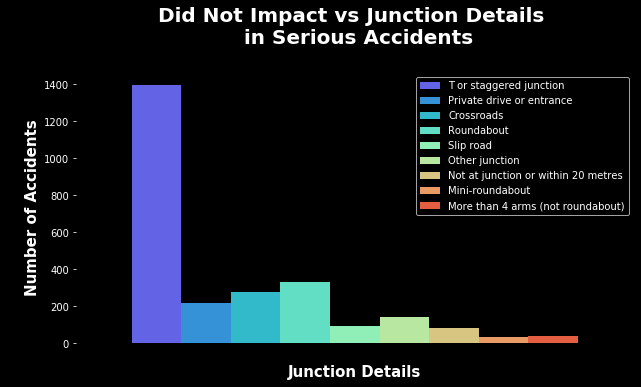

In [102]:
#noimpact x1st_point_of_impact vs junction details

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="junction_detail",
              palette="rainbow", data=s_noimpact)

plt.style.use('dark_background')
plt.title("Did Not Impact vs Junction Details \n in Serious Accidents\n",
          fontsize=20, fontweight="bold")
plt.xlabel("\nJunction Details", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

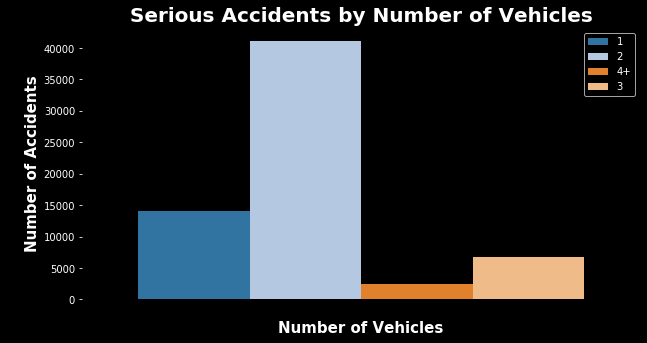

In [106]:
#number_of_vehicles vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="number_of_vehicles",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Number of Vehicles",
          fontsize=20, fontweight="bold")

plt.xlabel("\nNumber of Vehicles", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

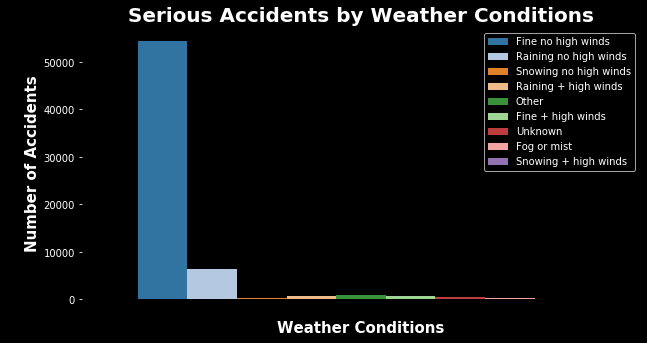

In [131]:
#weather_conditions vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="weather_conditions",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Weather Conditions",
          fontsize=20, fontweight="bold")

plt.xlabel("\nWeather Conditions", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

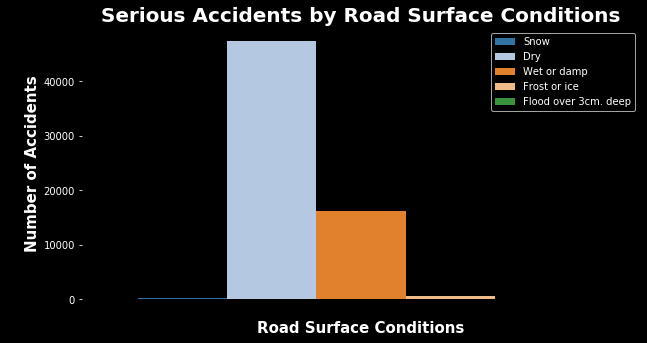

In [134]:
#road_surface_conditions vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="road_surface_conditions",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Road Surface Conditions",
          fontsize=20, fontweight="bold")

plt.xlabel("\nRoad Surface Conditions", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

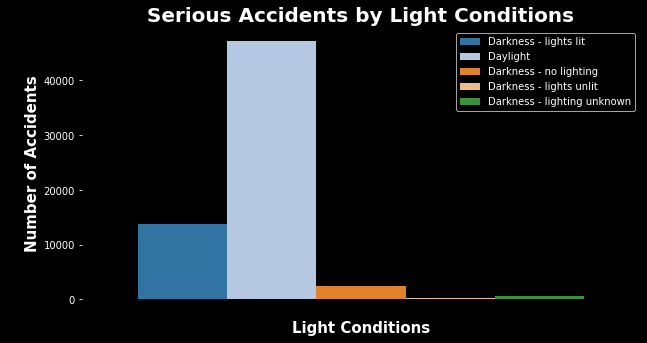

In [138]:
#light_conditions 


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="light_conditions",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Light Conditions",
          fontsize=20, fontweight="bold")

plt.xlabel("\nLight Conditions", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

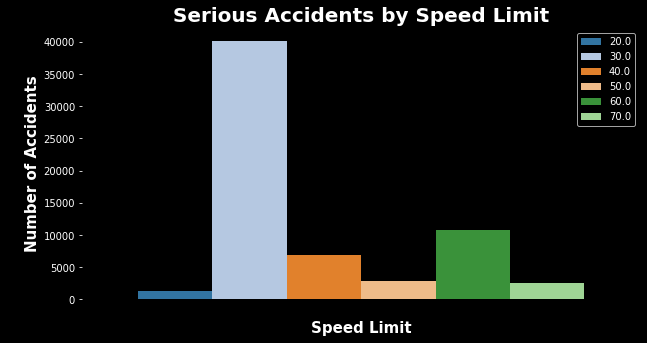

In [139]:
#light_conditions 


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="speed_limit",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Speed Limit",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSpeed Limit", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

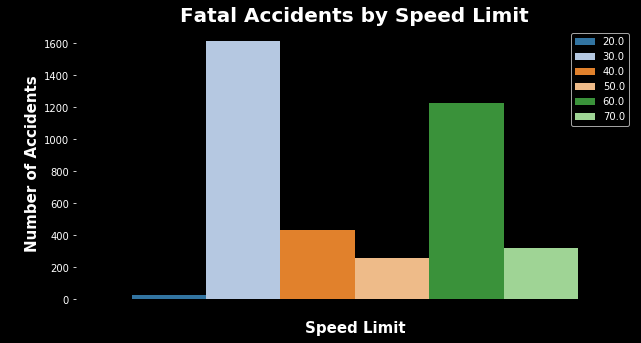

In [140]:
#speed_limit


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="speed_limit",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Speed Limit",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSpeed Limit", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

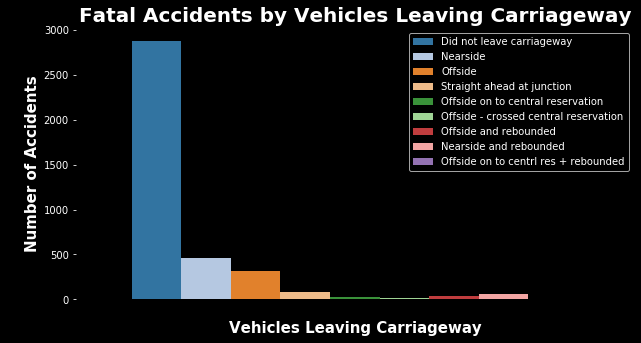

In [143]:
#Vehicles Leaving Carriageway


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="vehicle_leaving_carriageway",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Vehicles Leaving Carriageway",
          fontsize=20, fontweight="bold")

plt.xlabel("\nVehicles Leaving Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

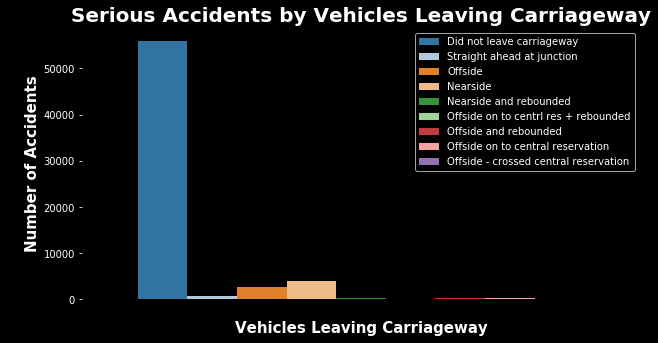

In [144]:
#Vehicles Leaving Carriageway


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="vehicle_leaving_carriageway",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Vehicles Leaving Carriageway",
          fontsize=20, fontweight="bold")

plt.xlabel("\nVehicles Leaving Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

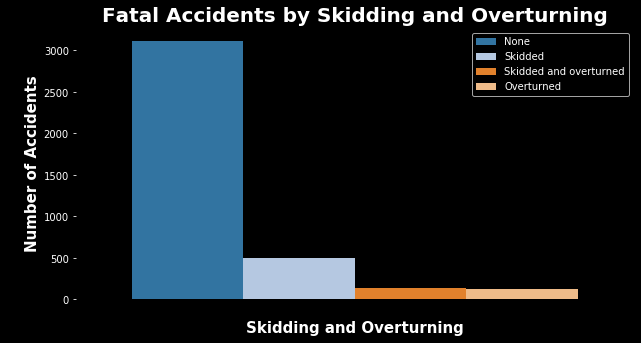

In [145]:
#skidding_and_overturning


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="skidding_and_overturning",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Skidding and Overturning",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSkidding and Overturning", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

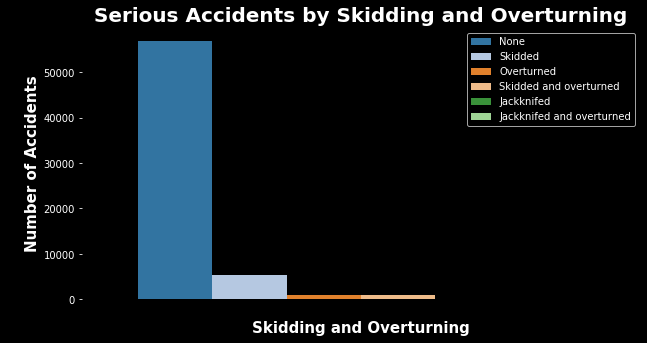

In [147]:
#skidding_and_overturning


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="skidding_and_overturning",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Skidding and Overturning",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSkidding and Overturning", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

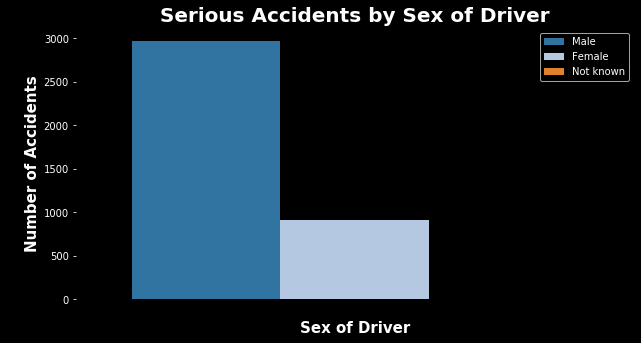

In [151]:
#sex_of_driver


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="sex_of_driver",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Serious Accidents by Sex of Driver",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSex of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

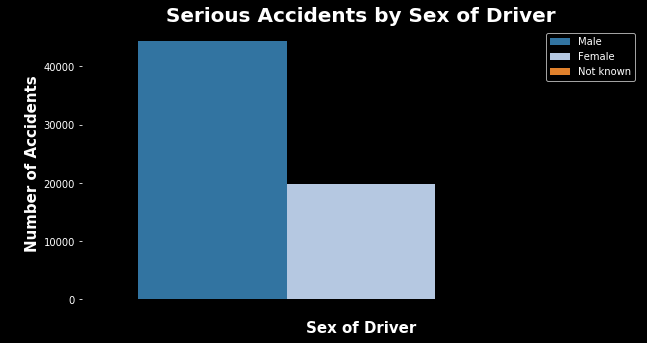

In [148]:
#sex_of_driver


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="sex_of_driver",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Sex of Driver",
          fontsize=20, fontweight="bold")

plt.xlabel("\nSex of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

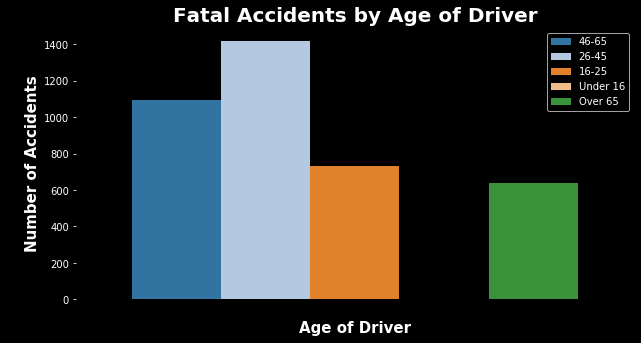

In [153]:
#sex_of_driver


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="age_band_of_driver",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Age of Driver",
          fontsize=20, fontweight="bold")

plt.xlabel("\nAge of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

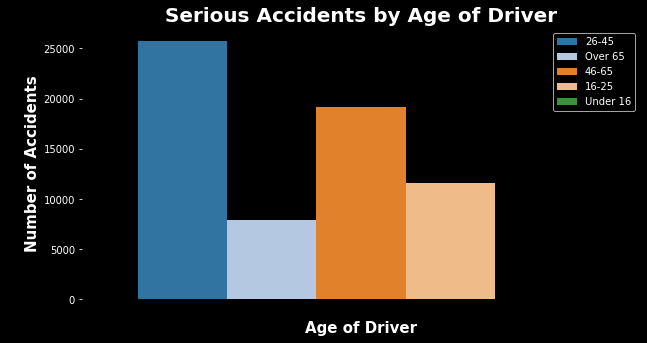

In [152]:
#sex_of_driver


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="age_band_of_driver",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Age of Driver",
          fontsize=20, fontweight="bold")

plt.xlabel("\nAge of Driver", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

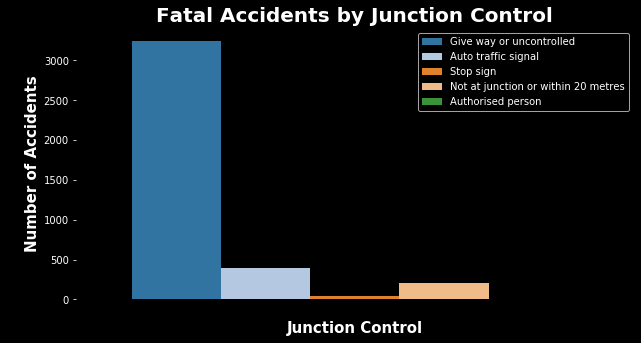

In [155]:
#junction_control


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="junction_control",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Junction Control",
          fontsize=20, fontweight="bold")

plt.xlabel("\nJunction Control", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

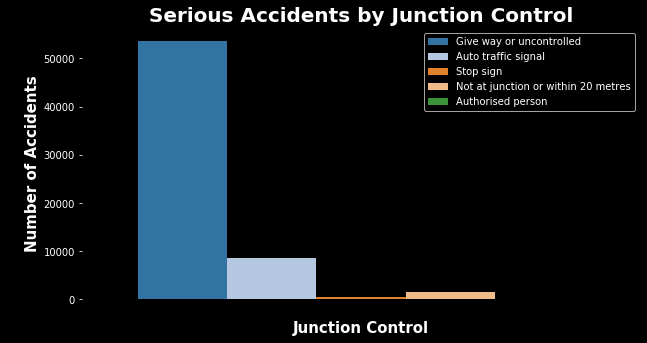

In [156]:
#junction_control


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="junction_control",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Junction Control",
          fontsize=20, fontweight="bold")

plt.xlabel("\nJunction Control", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

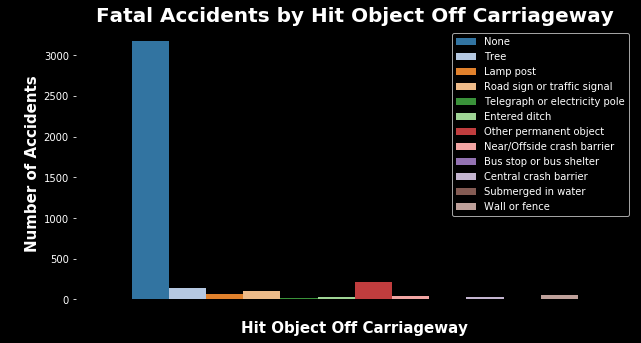

In [158]:
#hit_object_off_carriageway


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="hit_object_off_carriageway",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Hit Object Off Carriageway",
          fontsize=20, fontweight="bold")

plt.xlabel("\nHit Object Off Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

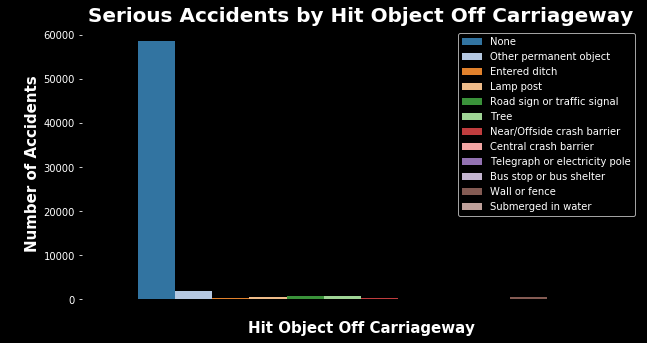

In [175]:
#hit_object_off_carriageway


plt.figure(figsize=(10,5))
sns.countplot("accident_severity", hue="hit_object_off_carriageway",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Hit Object Off Carriageway",
          fontsize=20, fontweight="bold")

plt.xlabel("\nHit Object Off Carriageway", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [194]:
#create time of day feature with Morning Rush, Day, Noon Rush, Afternoon, After Work Rush, Night

#time of day dictionary
timeofdaygroups = {"1": "Morning Rush (6-10)",
                   "2": "Day (10-12)",
                   "3": "Lunch Rush (12-14)",
                   "4": "Afternoon (14-16)",
                   "5": "After Work Rush (16-18)",
                   "6": "Evening (18-22)",
                   "7": "Night (22-6)"}

fatal['time_of_day']=fatal['time_of_day'].map(timeofdaygroups)
serious['time_of_day']=serious['time_of_day'].map(timeofdaygroups)


isweekend = {1:"Yes", 0:"No"}
fatal['weekend'] = fatal['weekend'].map(isweekend)
serious['weekend'] = serious['weekend'].map(isweekend)

#replace 1, 2, 3 in did_police_officer_attend_scene_of_accident with Yes, No,Self-reported
policeattend = {1: "Yes", 2:"No", 3:"Self-Reported"}
serious['did_police_officer_attend_scene_of_accident']=serious['did_police_officer_attend_scene_of_accident'].map(policeattend)
fatal['did_police_officer_attend_scene_of_accident']=fatal['did_police_officer_attend_scene_of_accident'].map(policeattend)

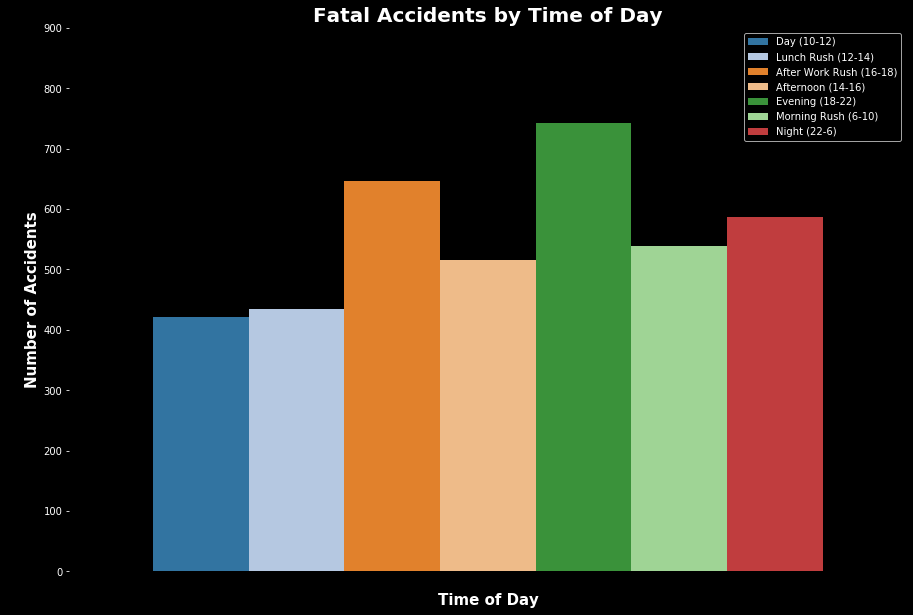

In [185]:
#time_of_day


plt.figure(figsize=(15,10))
sns.countplot("accident_severity", hue="time_of_day",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Time of Day",
          fontsize=20, fontweight="bold")

plt.xlabel("\nTime of Day", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.yticks(np.arange(0, 1000, 100)) 
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

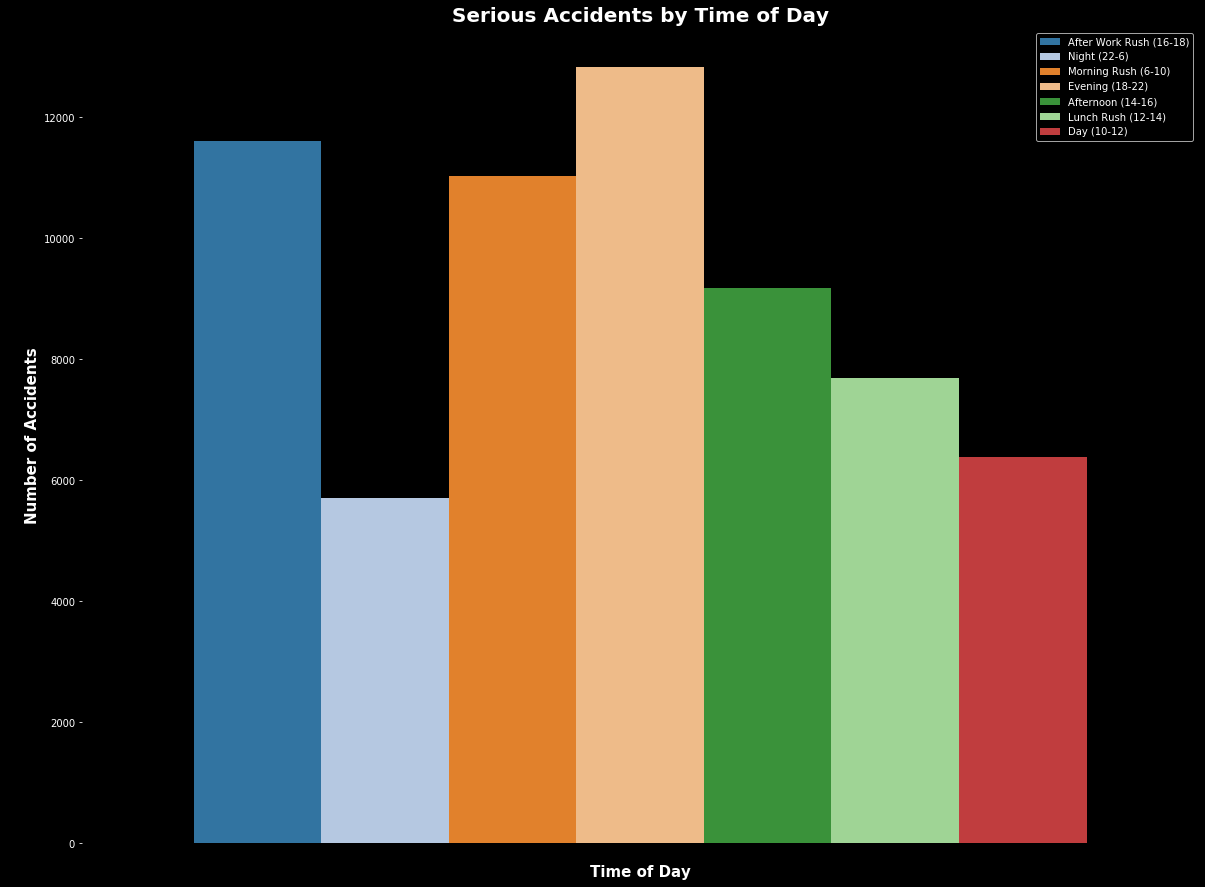

In [191]:
#time_of_day


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="time_of_day",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Time of Day",
          fontsize=20, fontweight="bold")

plt.xlabel("\nTime of Day", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

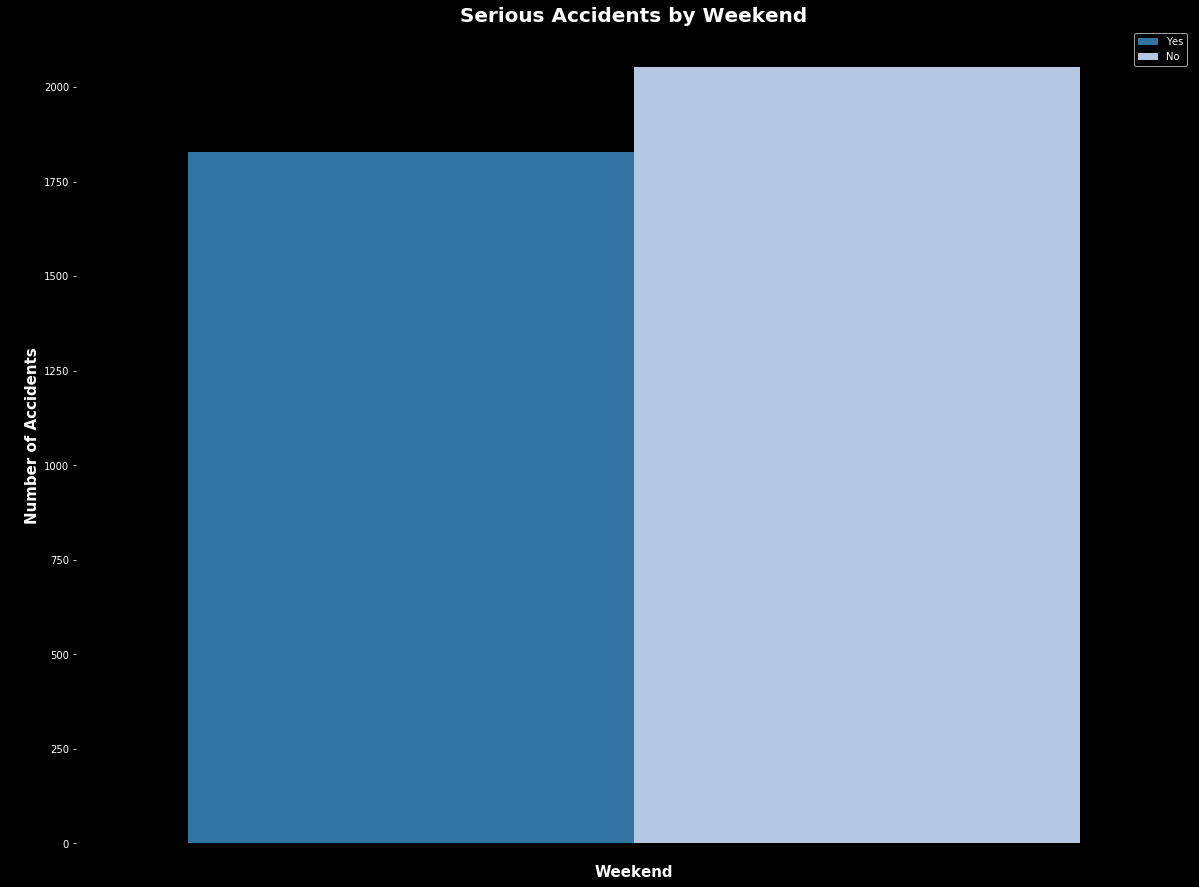

In [212]:
#weekend


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="weekend",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Serious Accidents by Weekend",
          fontsize=20, fontweight="bold")

plt.xlabel("\nWeekend", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

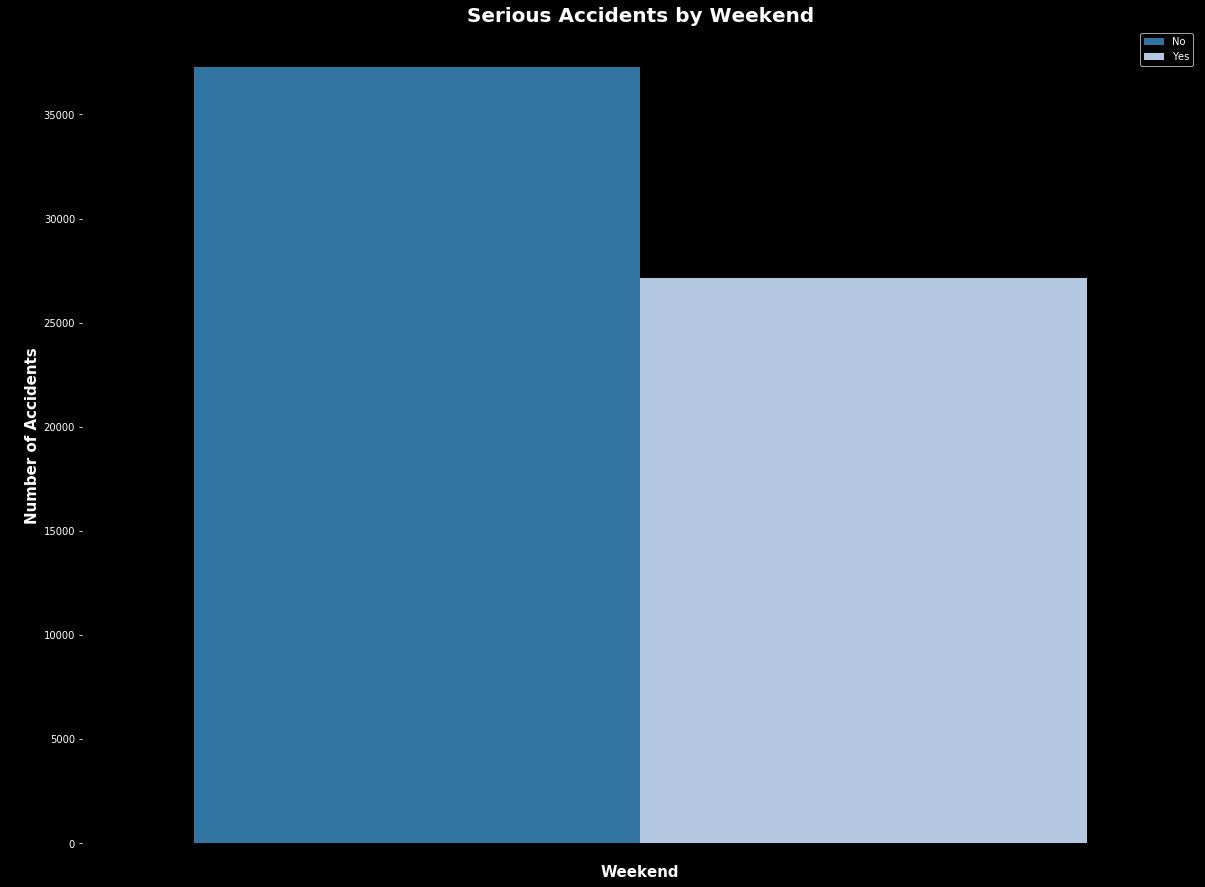

In [195]:
#weekend


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="weekend",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Weekend",
          fontsize=20, fontweight="bold")

plt.xlabel("\nWeekend", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

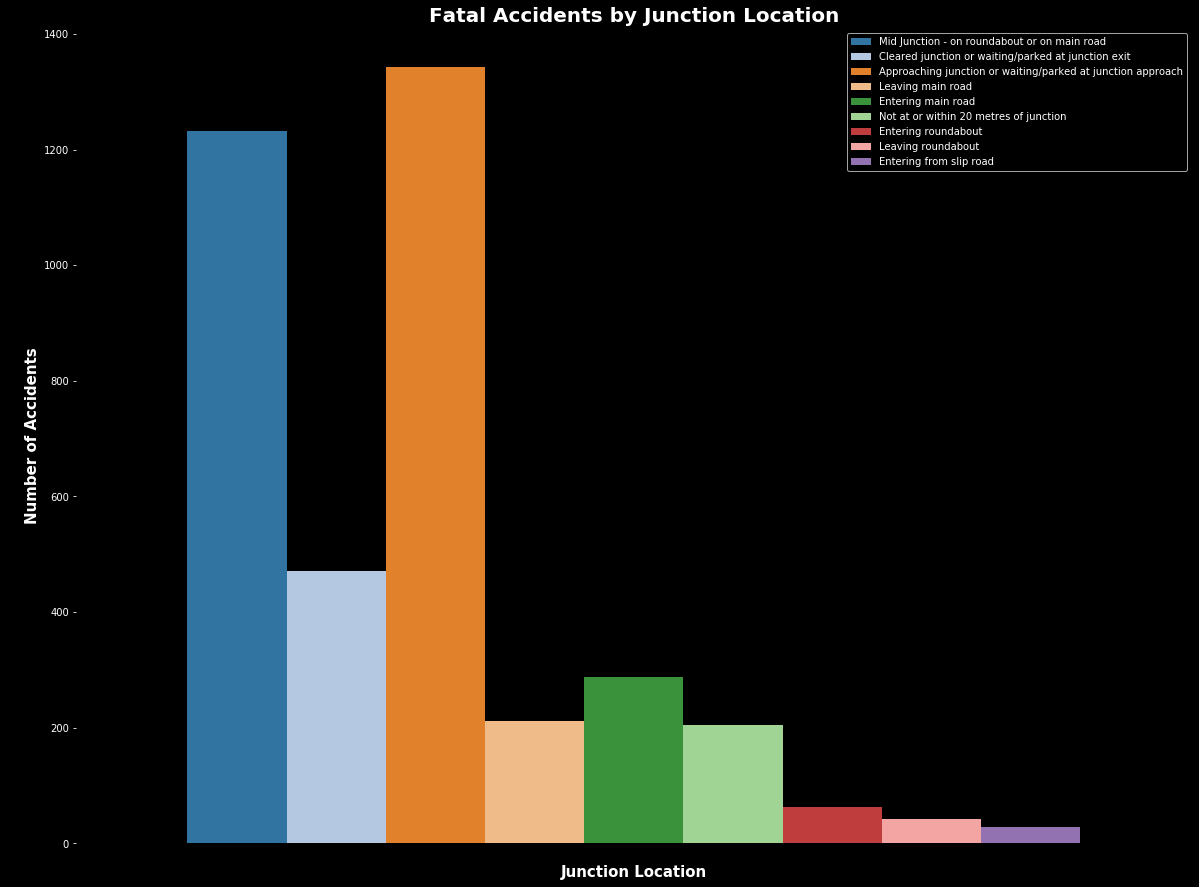

In [198]:
#junction_location


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="junction_location",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Junction Location",
          fontsize=20, fontweight="bold")

plt.xlabel("\nJunction Location", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

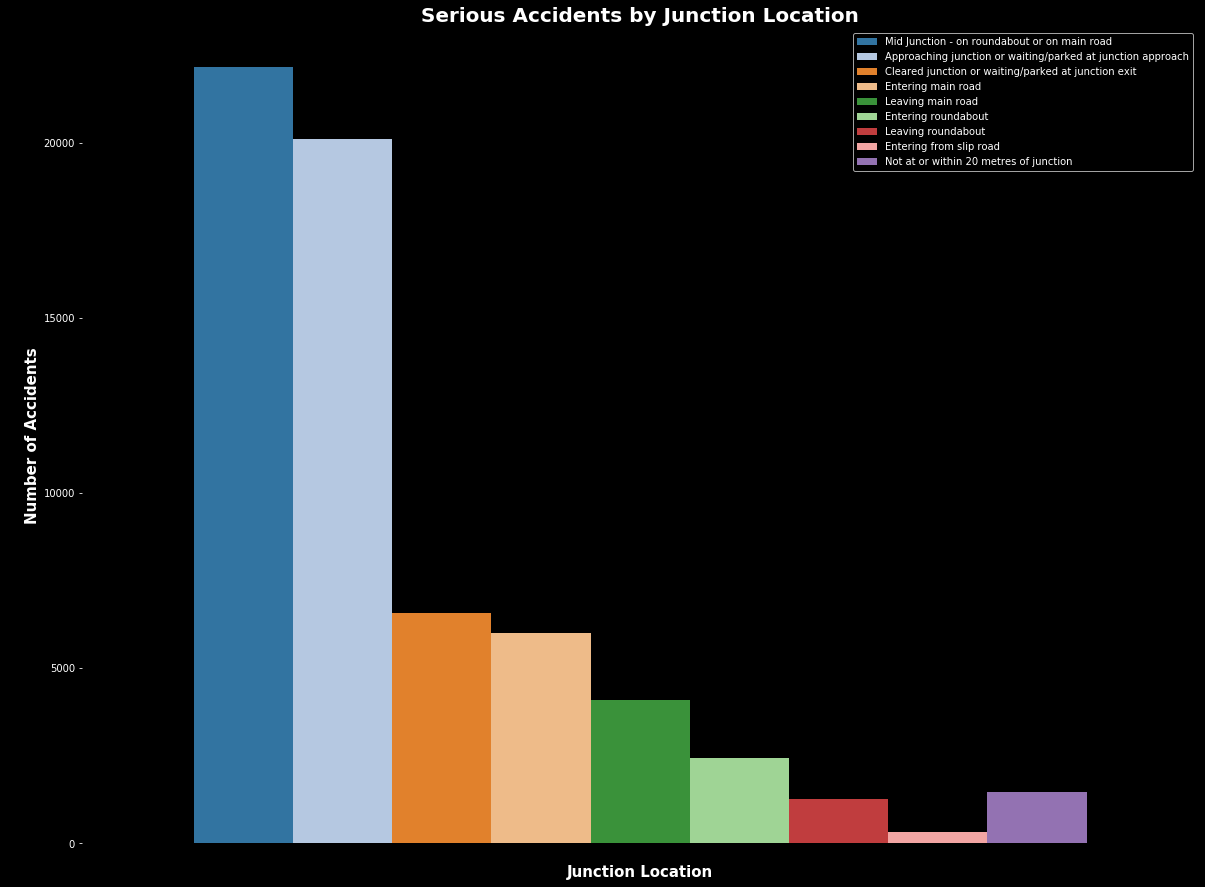

In [197]:
#junction_location


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="junction_location",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Junction Location",
          fontsize=20, fontweight="bold")

plt.xlabel("\nJunction Location", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

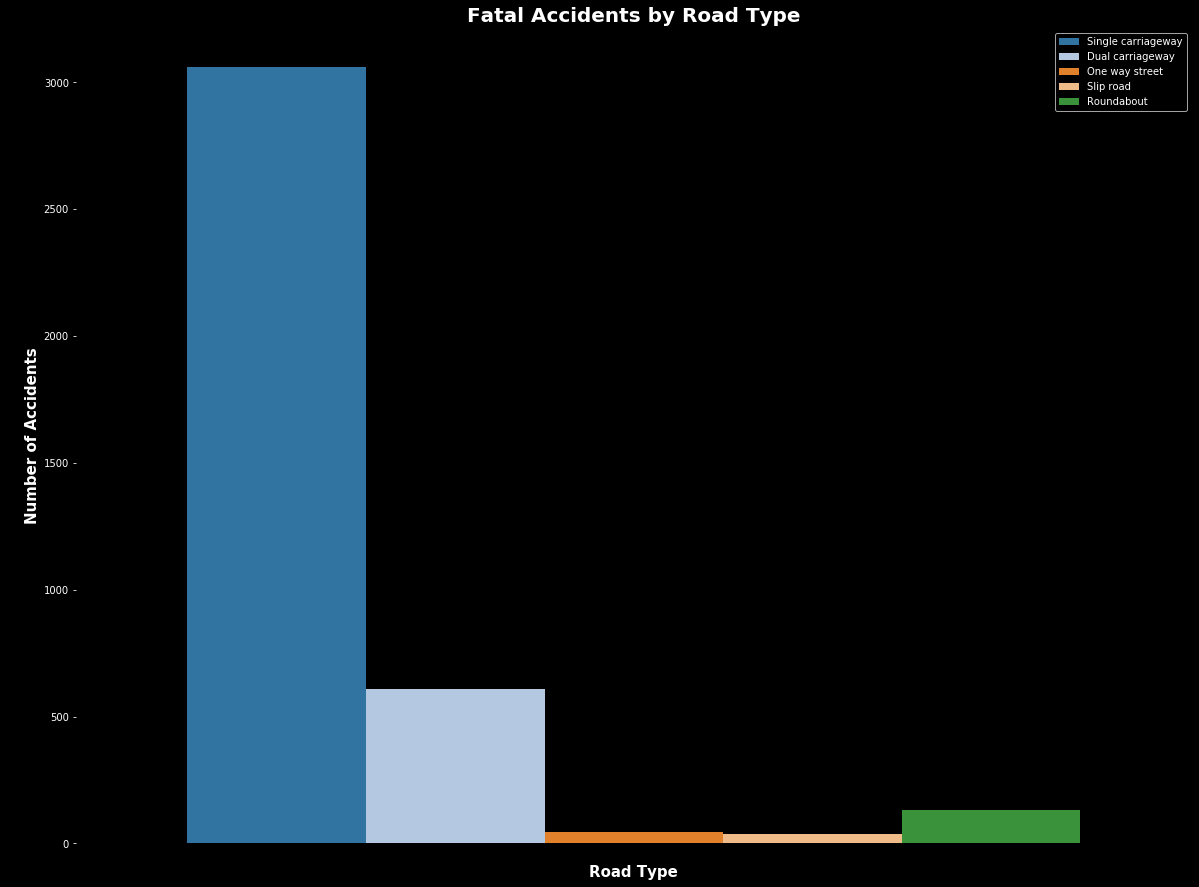

In [199]:
#road_type


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="road_type",
              palette="tab20", data=fatal)

plt.style.use('dark_background')
plt.title("Fatal Accidents by Road Type",
          fontsize=20, fontweight="bold")

plt.xlabel("\nRoad Type", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

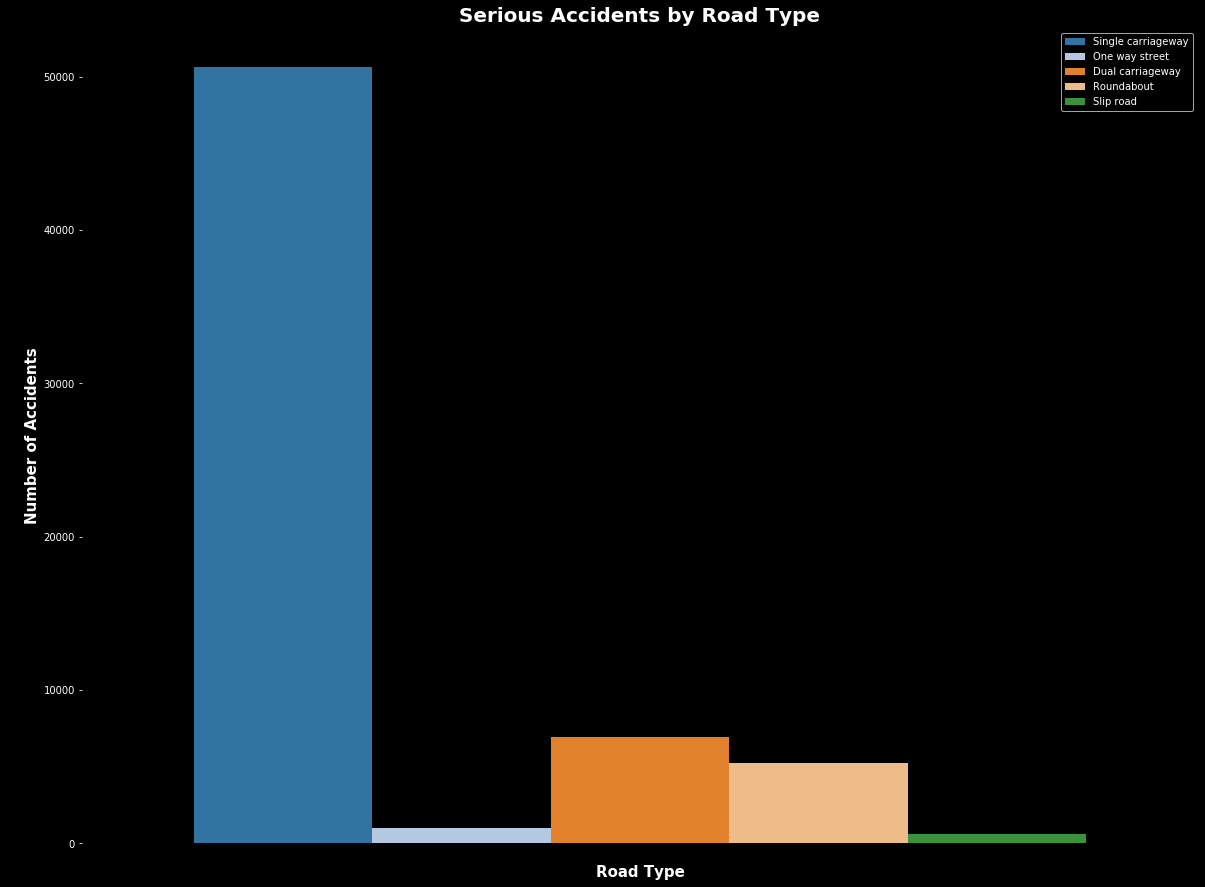

In [8]:
#road_type


plt.figure(figsize=(20,15))
sns.countplot("accident_severity", hue="road_type",
              palette="tab20", data=serious)

plt.style.use('dark_background')
plt.title("Serious Accidents by Road Type",
          fontsize=20, fontweight="bold")

plt.xlabel("\nRoad Type", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.legend( loc = 'upper right')
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")

plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

Fatal Accidents Summary:
 The majority of fatal accident occur from front impact accidents in T or staggered junctions.
 T or Staggered junctions were the top locations of accidents in all other fatal impacts as well.
 Most fatal accidents involved two people.
 Weather conditions did not impact these accidents as most occured during fine weather with no high winds.
 Road surfaces also did not effect severity here (dry highest).
 Most occured during daylight
 
 
 

In [ ]:
Serious Accidents Summary:
    

In [ ]:
Most serious and fatal accidents occur on singl carriageway roads.


In [ ]:
fatal.groupby(['junction_detail','vehicle_manoeuvre'])['vehicle_manoeuvre'].count()

In [ ]:
fatal.groupby(['vehicle_manoeuvre','junction_detail'])['vehicle_manoeuvre'].count()

urban_or_rural_area                            1.000000
driver_home_area_type                          0.355313
pedestrian_crossing-physical_facilities        0.212687
1st_road_class                                 0.152420
police_force                                   0.092886
accident_severity                              0.071467
time_of_day                                    0.064973
longitude                                      0.062241
vehicle_manoeuvre                              0.044731
x1st_point_of_impact                           0.043502
did_police_officer_attend_scene_of_accident    0.041135
junction_location                              0.035989
hour                                           0.035878
time                                           0.035570
pedestrian_crossing-human_control              0.029518
propulsion_code                                0.024738
vehicle_locationrestricted_lane                0.018610
make                                           0

In [127]:
#driver_home_area_type
df.groupby(['driver_home_area_type','urban_or_rural_area'])['urban_or_rural_area'].count()

driver_home_area_type  urban_or_rural_area
Rural                  Rural                   39272
                       Urban                   20541
Small town             Rural                   30019
                       Urban                   17479
Urban area             Rural                   96675
                       Urban                  357149
Name: urban_or_rural_area, dtype: int64

In [ ]:
#x1st_point_of_impact vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("x1st_point_of_impact", hue="accident_severity",  
              palette="PuBu", data=df)

plt.style.use('dark_background')
plt.title("1st Point of Impact vs Accident Severity",fontsize=20,fontweight="bold")
plt.xlabel("\nSeverity", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.ylabel("\n1st Point of Impact Count", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [ ]:
#speed_limit vs accident severity

plt.figure(figsize=(10,5))
sns.countplot("speed_limit", hue="accident_severity",  
              palette="PuBu", data=df)

plt.style.use('dark_background')
plt.title("Speed Limit vs Accident Severity",fontsize=20,fontweight="bold")
plt.xlabel("\nSeverity", fontsize=15, fontweight="bold")
plt.legend().set_title('')
plt.ylabel("\nSpeed Limit Count", fontsize=15, fontweight="bold")
sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

In [ ]:
#road_type vs accident_severity

plt.figure(figsize=(10,5))
sns.countplot("road_type", hue="accident_severity",
              palette="PuBu",data=df)
plt.title("Road Type vs Accident Severity",fontsize=12,fontweight="bold")
plt.xlabel("")
plt.ylabel("")
plt.show()

In [ ]:
# df.info()

In [ ]:
mldf=df.apply(LabelEncoder().fit_transform)

In [ ]:
#Use Random Forest to find top important features
rfc = ensemble.RandomForestClassifier()


In [ ]:
#First set up of X and Y
X= mldf.drop(['accident_severity'],1)
Y= mldf['accident_severity']

In [ ]:
#fitting
rfc.fit(X,Y)

In [ ]:
#finding important features
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
#top 30 features
feature_importances.importance.head(130)

In [123]:
print("Distinct responses for age_band_of_driver:\n", set(df['driver_home_area_type']))



Distinct responses for age_band_of_driver:
 {'Small town', 'Rural', 'Urban area'}


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

